# Video Classification with Transformers

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/06/08<br>
**Last modified:** 2023/22/07<br>
**Description:** Training a video classifier with hybrid transformers.

This example is a follow-up to the
[Video Classification with a CNN-RNN Architecture](https://keras.io/examples/vision/video_classification/)
example. This time, we will be using a Transformer-based model
([Vaswani et al.](https://arxiv.org/abs/1706.03762)) to classify videos. You can follow
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11)
in case you need an introduction to Transformers (with code). After reading this
example, you will know how to develop hybrid Transformer-based models for video
classification that operate on CNN feature maps.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [27]:
import tensorflow as tf

## Data collection

As done in the [predecessor](https://keras.io/examples/vision/video_classification/) to
this example, we will be using a subsampled version of the
[UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php),
a well-known benchmark dataset. In case you want to operate on a larger subsample or
even the entire dataset, please refer to
[this notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb).

In [2]:
!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar -xf ucf101_top5.tar.gz

## Setup

In [51]:
import os
import keras
from keras import layers
from keras.applications.densenet import DenseNet121

from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_curve

## Define hyperparameters

In [52]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 10

## Data preparation

We will mostly be following the same data preparation steps in this example, except for
the following changes:

* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network,
we use a pre-trained
[DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

First, let's load up the
[DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [53]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[tf.newaxis, ...])
    cropped = tf.squeeze(cropped).numpy()
    return cropped

# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0, offload_to_cpu=False):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]
            frame = crop_center(frame)
            if offload_to_cpu and keras.backend.backend() == "torch":
                frame = frame.to("cpu")
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total videos for training: 594
Total videos for testing: 224
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes to
complete. For this reason, to save time, here we download already preprocessed NumPy arrays:

In [6]:
!!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!!tar -xf top5_data_prepared.tar.gz

[]

In [54]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Building the Transformer-based model

We will be building on top of the code shared in
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of
[Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python)
by François Chollet.

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [55]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.backend.cast(inputs, self.compute_dtype)
        length = keras.backend.shape(inputs)[1]
        positions = keras.backend.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions


Now, we can create a subclassed layer for the Transformer.

In [56]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


## Utility functions for training

In [57]:

def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model ,history


## Model training and inference

In [58]:
trained_model, history = run_experiment()

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 2.4085 - accuracy: 0.5734
Epoch 1: val_loss improved from inf to 0.34286, saving model to /tmp/video_classifier.weights.h5
16/16 [==============================] - 12s 551ms/step - loss: 2.4085 - accuracy: 0.5734 - val_loss: 0.3429 - val_accuracy: 0.8556
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9365
Epoch 2: val_loss did not improve from 0.34286
16/16 [==============================] - 8s 536ms/step - loss: 0.2061 - accuracy: 0.9365 - val_loss: 0.4851 - val_accuracy: 0.8111
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9881
Epoch 3: val_loss did not improve from 0.34286
16/16 [==============================] - 7s 449ms/step - loss: 0.0499 - accuracy: 0.9881 - val_loss: 0.9949 - val_accuracy: 0.6889
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9921
Epoch 4: val_loss did not improve from 

In [ ]:
from tensorflow.keras.models import save_model
from google.colab import files

# Assuming 'trained_model' is your trained model variable
# Replace 'output_path' with the desired path and filename
output_path = 'content/tfmodel.keras'

save_model(trained_model, output_path)
print("Model saved successfully.")
files.download(output_path)

**Note**: This model has ~4.23 Million parameters, which is way more than the sequence
model (99918 parameters) we used in the prequel of this example.  This kind of
Transformer model works best with a larger dataset and a longer pre-training schedule.

Test video path: v_ShavingBeard_g03_c01.avi
1/1 [==============================] - 0s 45ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


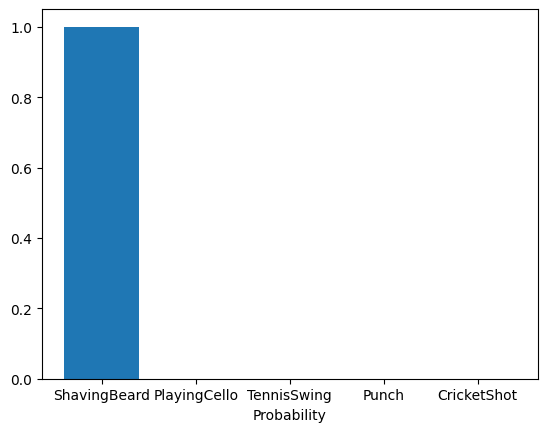

AttributeError: module 'IPython.display' has no attribute 'embed_file'

In [135]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path), offload_to_cpu=True)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    y_pred = {class_vocab[i]: probabilities[i] for i in range(len(class_vocab))}
    max_class = max(y_pred, key=y_pred.get)

    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("class_label")
    plt.xlabel("Probability")
    plt.show()

    return max_class, frames

# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
y_true = test_df.loc[test_df['video_name'] == test_video, 'tag'].iloc[0]

print(f"Test video path: {test_video}")
y_pred, test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

print("Ground truth:", y_true)
print("Predicted probabilities:", y_pred)

Test video path: v_CricketShot_g01_c01.avi
1/1 [==============================] - 0s 66ms/step
  CricketShot: 89.94%
  TennisSwing: 10.05%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


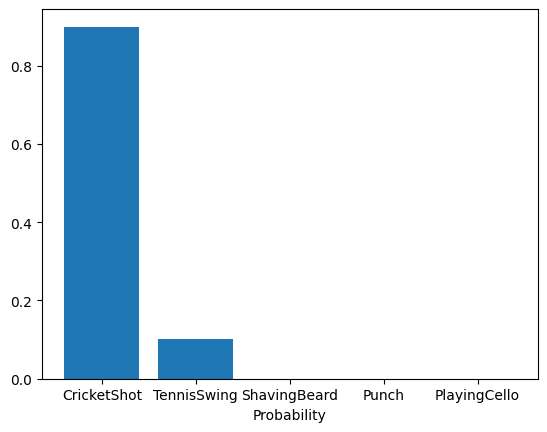

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g01_c02.avi
1/1 [==============================] - 0s 31ms/step
  CricketShot: 95.88%
  TennisSwing:  4.12%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


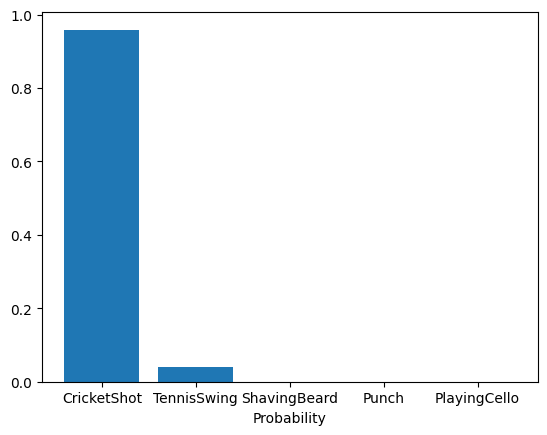

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g01_c03.avi
1/1 [==============================] - 0s 34ms/step
  CricketShot: 95.12%
  TennisSwing:  4.88%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


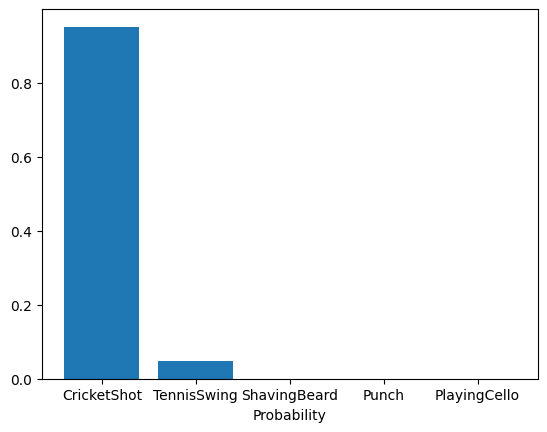

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g01_c04.avi
1/1 [==============================] - 0s 45ms/step
  CricketShot: 97.47%
  TennisSwing:  2.53%
  ShavingBeard:  0.00%
  PlayingCello:  0.00%
  Punch:  0.00%


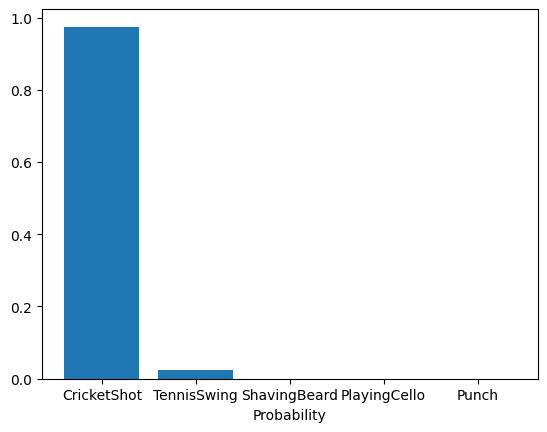

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g01_c05.avi
1/1 [==============================] - 0s 39ms/step
  CricketShot: 92.85%
  TennisSwing:  7.15%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


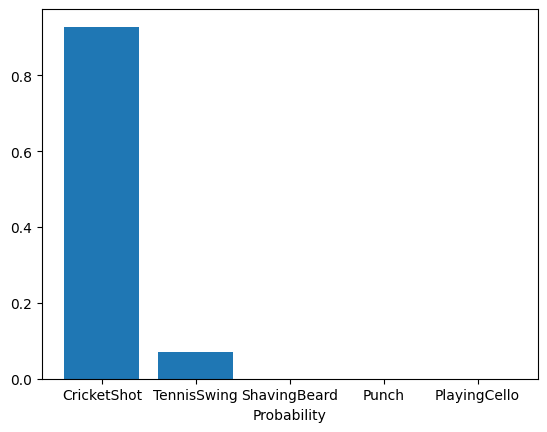

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g01_c06.avi
1/1 [==============================] - 0s 30ms/step
  CricketShot: 94.64%
  TennisSwing:  5.35%
  ShavingBeard:  0.02%
  Punch:  0.00%
  PlayingCello:  0.00%


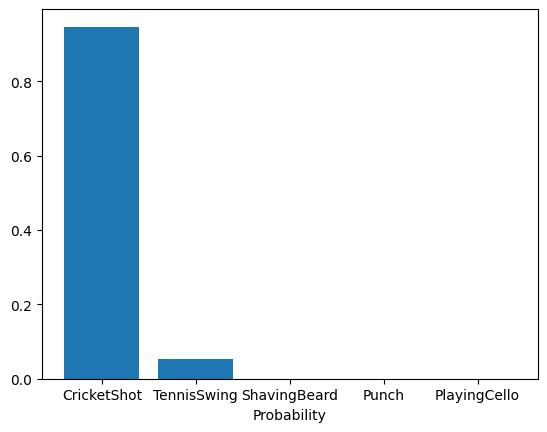

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g01_c07.avi
1/1 [==============================] - 0s 33ms/step
  CricketShot: 96.93%
  TennisSwing:  3.07%
  ShavingBeard:  0.00%
  PlayingCello:  0.00%
  Punch:  0.00%


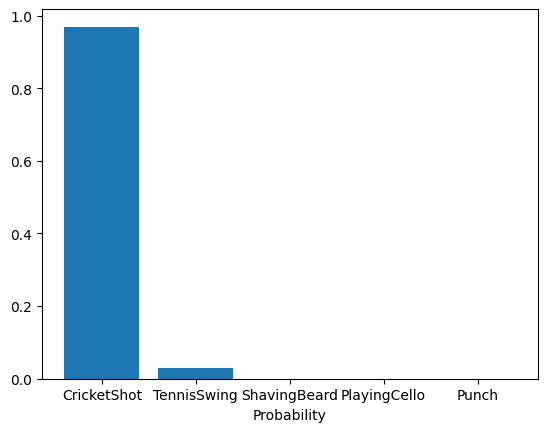

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g02_c01.avi
1/1 [==============================] - 0s 32ms/step
  TennisSwing: 62.62%
  CricketShot: 37.38%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


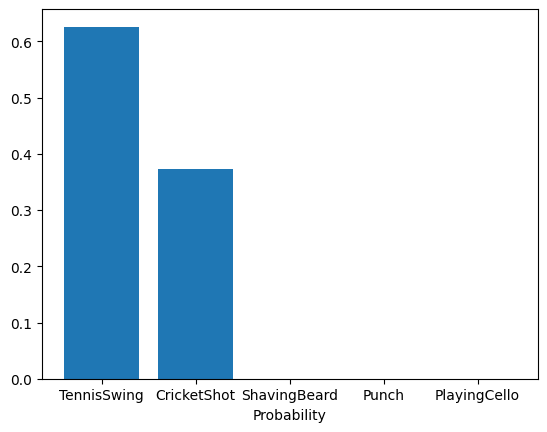

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g02_c02.avi
1/1 [==============================] - 0s 43ms/step
  CricketShot: 59.56%
  TennisSwing: 40.44%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


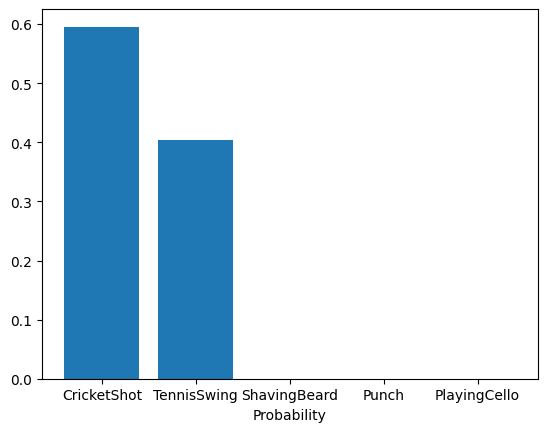

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g02_c03.avi
1/1 [==============================] - 0s 29ms/step
  CricketShot: 57.28%
  TennisSwing: 42.71%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


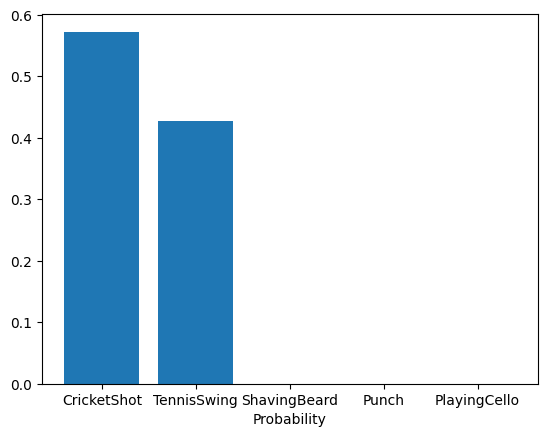

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g02_c04.avi
1/1 [==============================] - 0s 32ms/step
  CricketShot: 51.60%
  TennisSwing: 48.39%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


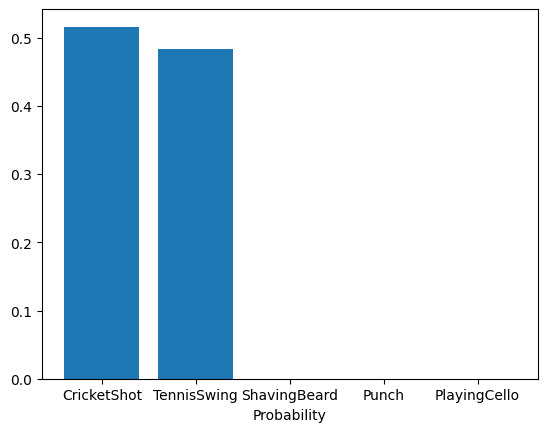

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g02_c05.avi
1/1 [==============================] - 0s 30ms/step
  TennisSwing: 54.30%
  CricketShot: 45.69%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


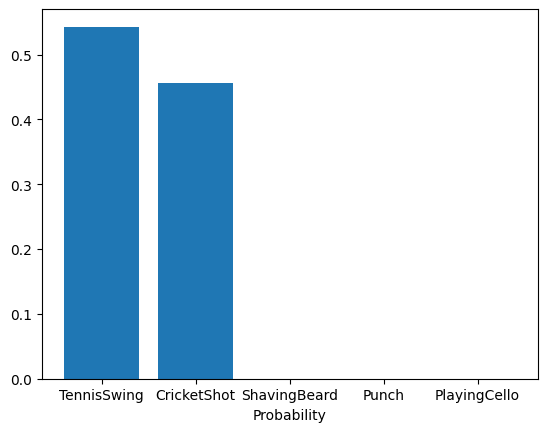

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g02_c06.avi
1/1 [==============================] - 0s 37ms/step
  TennisSwing: 57.60%
  CricketShot: 42.39%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


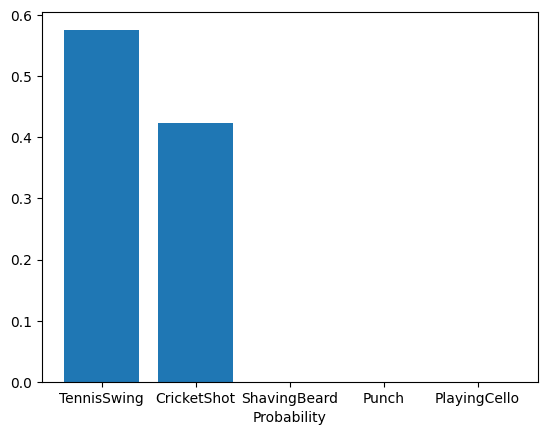

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g02_c07.avi
1/1 [==============================] - 0s 54ms/step
  CricketShot: 59.06%
  TennisSwing: 40.94%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


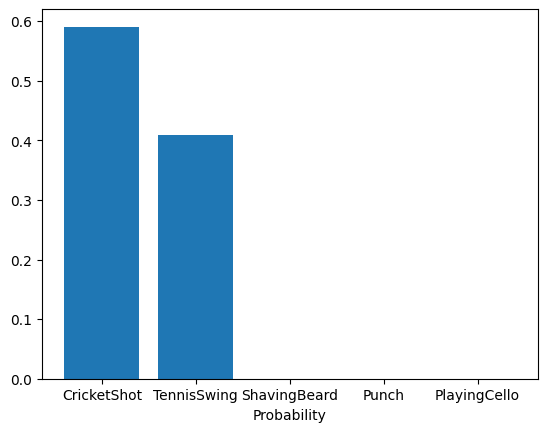

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g03_c01.avi
1/1 [==============================] - 0s 37ms/step
  CricketShot: 81.33%
  TennisSwing: 18.67%
  PlayingCello:  0.00%
  ShavingBeard:  0.00%
  Punch:  0.00%


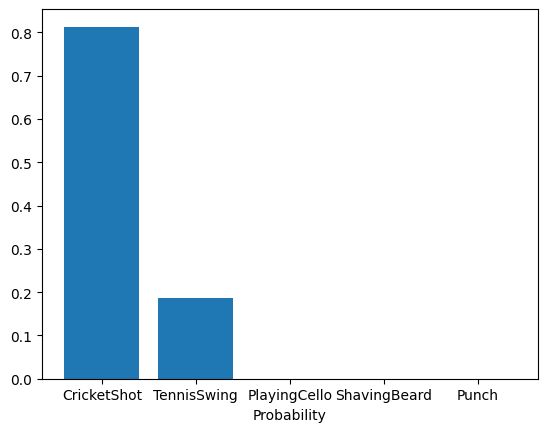

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g03_c02.avi
1/1 [==============================] - 0s 36ms/step
  CricketShot: 94.53%
  TennisSwing:  5.47%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


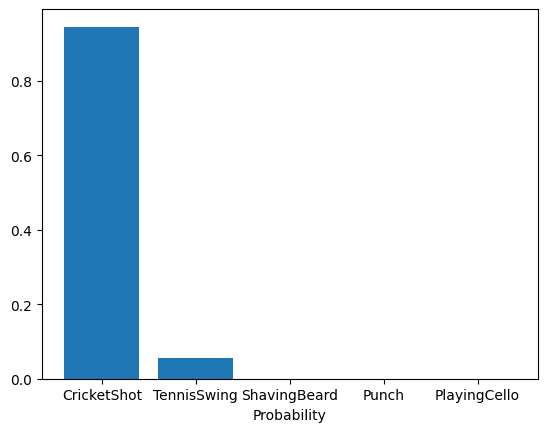

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g03_c03.avi
1/1 [==============================] - 0s 36ms/step
  CricketShot: 84.95%
  TennisSwing: 15.05%
  PlayingCello:  0.00%
  ShavingBeard:  0.00%
  Punch:  0.00%


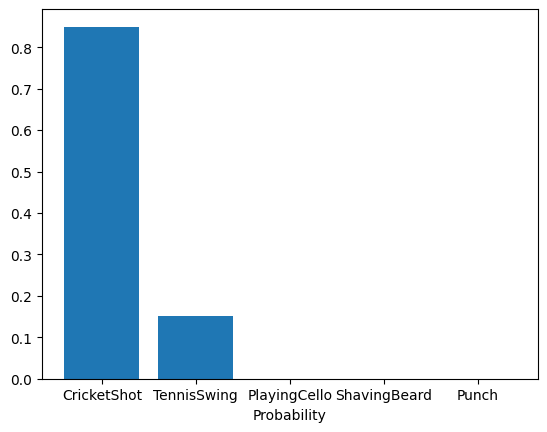

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g03_c04.avi
1/1 [==============================] - 0s 35ms/step
  CricketShot: 86.81%
  TennisSwing: 13.19%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


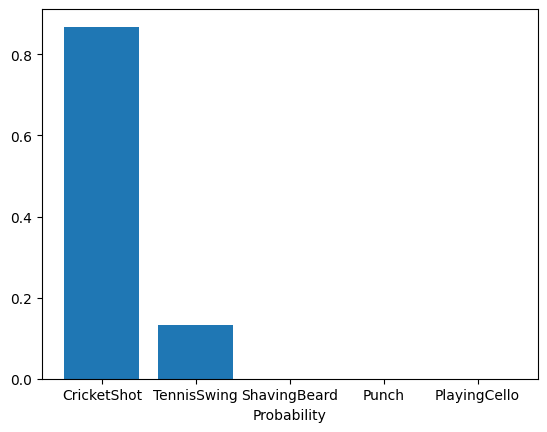

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g03_c05.avi
1/1 [==============================] - 0s 34ms/step
  CricketShot: 71.10%
  TennisSwing: 28.89%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


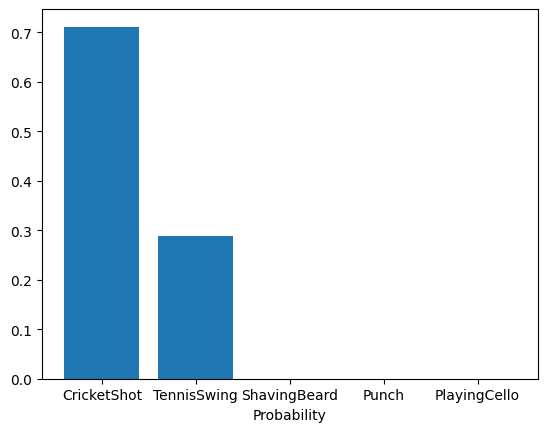

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g03_c06.avi
1/1 [==============================] - 0s 37ms/step
  CricketShot: 97.34%
  TennisSwing:  2.66%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


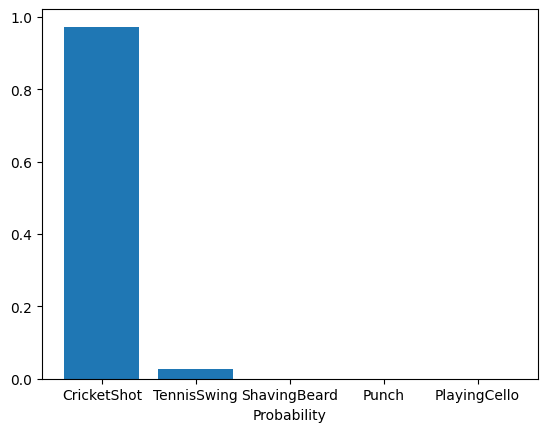

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g03_c07.avi
1/1 [==============================] - 0s 63ms/step
  CricketShot: 89.89%
  TennisSwing: 10.11%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


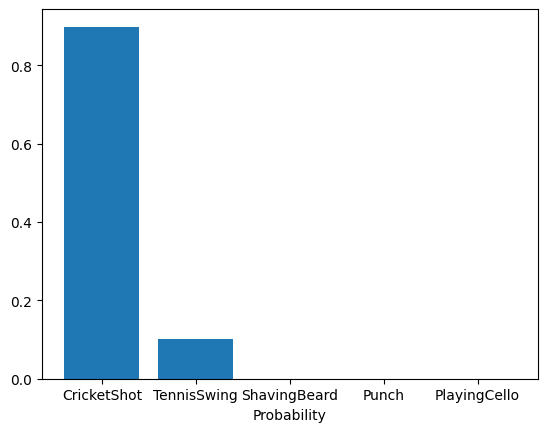

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g04_c01.avi
1/1 [==============================] - 0s 149ms/step
  CricketShot: 93.50%
  TennisSwing:  6.14%
  ShavingBeard:  0.36%
  PlayingCello:  0.00%
  Punch:  0.00%


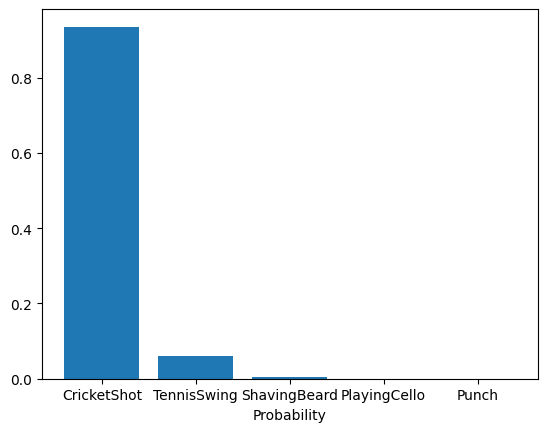

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g04_c02.avi
1/1 [==============================] - 0s 59ms/step
  CricketShot: 95.68%
  TennisSwing:  4.22%
  ShavingBeard:  0.07%
  PlayingCello:  0.03%
  Punch:  0.00%


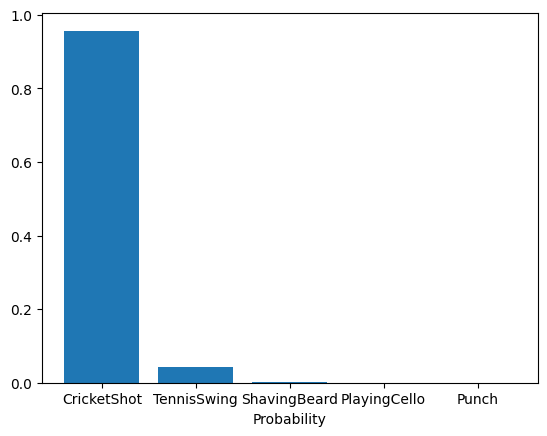

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g04_c03.avi
1/1 [==============================] - 0s 33ms/step
  CricketShot: 95.55%
  TennisSwing:  4.39%
  ShavingBeard:  0.06%
  PlayingCello:  0.00%
  Punch:  0.00%


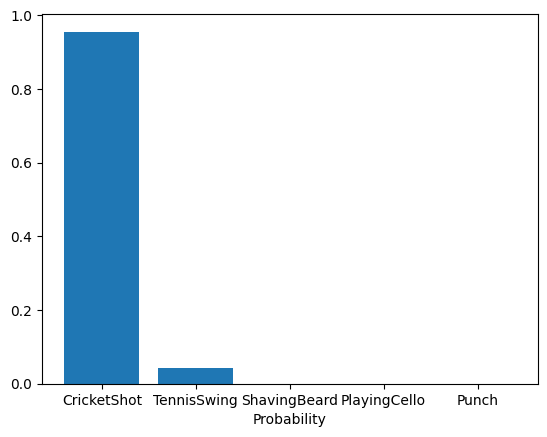

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g04_c04.avi
1/1 [==============================] - 0s 33ms/step
  CricketShot: 84.75%
  TennisSwing: 14.58%
  ShavingBeard:  0.39%
  PlayingCello:  0.25%
  Punch:  0.02%


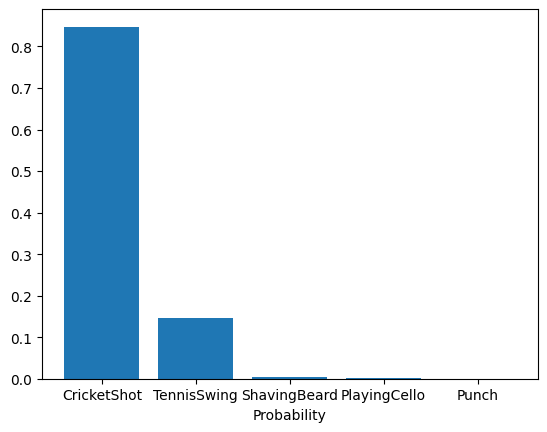

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g04_c05.avi
1/1 [==============================] - 0s 31ms/step
  CricketShot: 93.41%
  TennisSwing:  5.60%
  ShavingBeard:  0.71%
  PlayingCello:  0.24%
  Punch:  0.05%


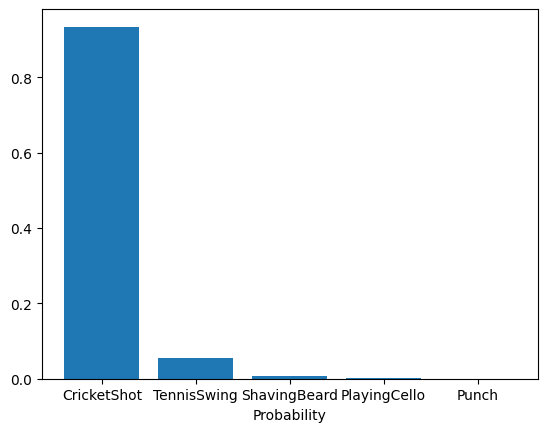

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g04_c06.avi
1/1 [==============================] - 0s 34ms/step
  CricketShot: 84.85%
  TennisSwing: 15.07%
  ShavingBeard:  0.04%
  PlayingCello:  0.03%
  Punch:  0.00%


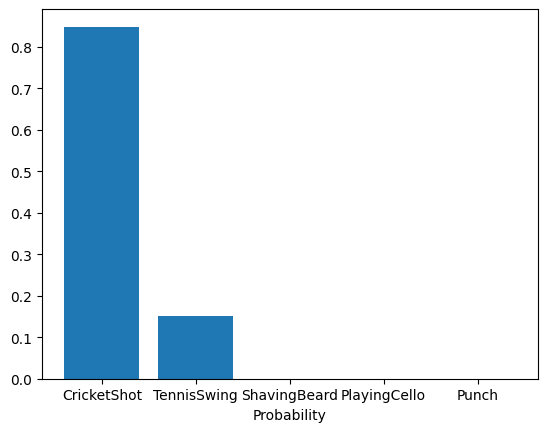

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g04_c07.avi
1/1 [==============================] - 0s 54ms/step
  CricketShot: 71.42%
  TennisSwing: 27.80%
  ShavingBeard:  0.53%
  PlayingCello:  0.21%
  Punch:  0.03%


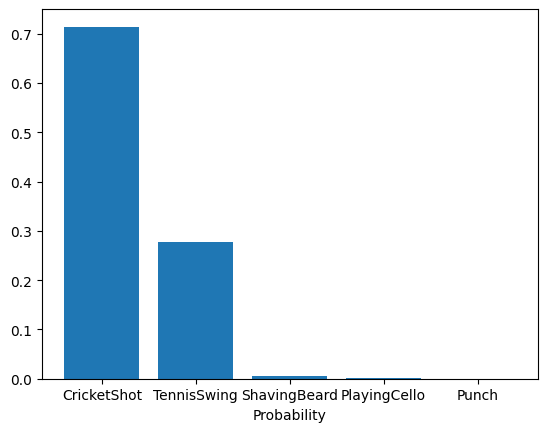

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g05_c01.avi
1/1 [==============================] - 0s 35ms/step
  CricketShot: 79.31%
  TennisSwing: 20.68%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


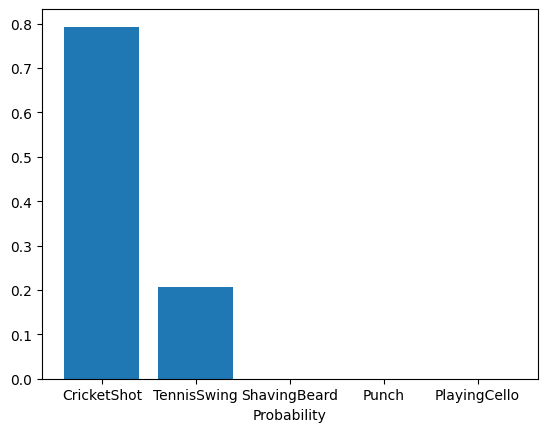

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g05_c02.avi
1/1 [==============================] - 0s 35ms/step
  CricketShot: 84.85%
  TennisSwing: 14.88%
  ShavingBeard:  0.27%
  Punch:  0.00%
  PlayingCello:  0.00%


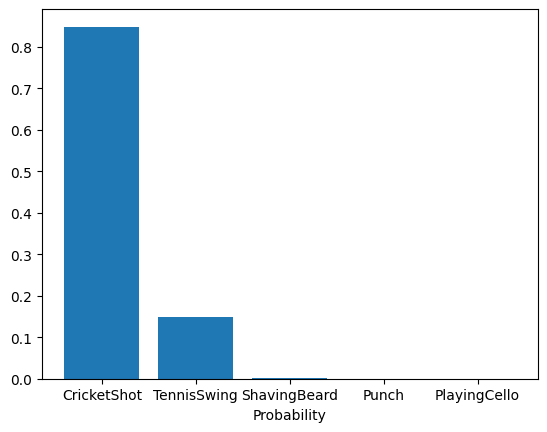

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g05_c03.avi
1/1 [==============================] - 0s 40ms/step
  CricketShot: 69.08%
  TennisSwing: 30.87%
  ShavingBeard:  0.03%
  Punch:  0.02%
  PlayingCello:  0.00%


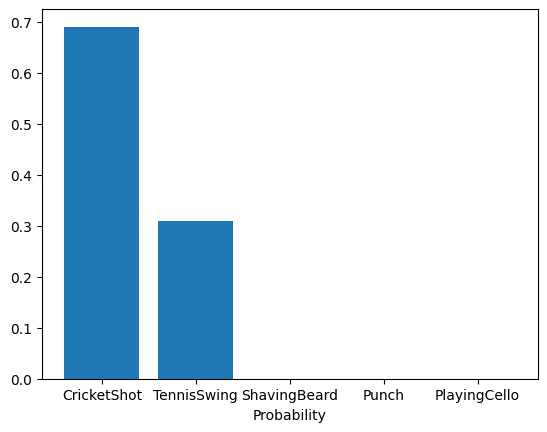

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g05_c04.avi
1/1 [==============================] - 0s 32ms/step
  CricketShot: 81.02%
  TennisSwing: 18.69%
  ShavingBeard:  0.28%
  Punch:  0.01%
  PlayingCello:  0.00%


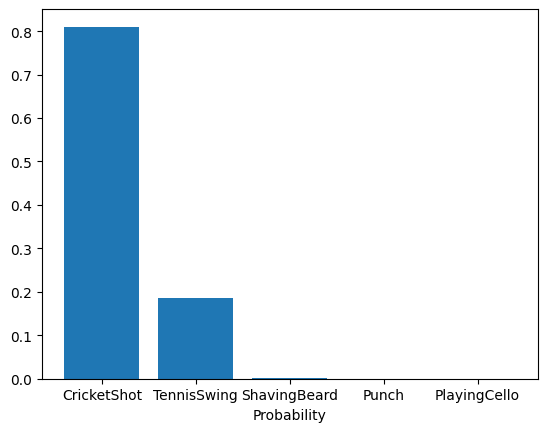

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g05_c05.avi
1/1 [==============================] - 0s 42ms/step
  CricketShot: 80.40%
  TennisSwing: 19.47%
  ShavingBeard:  0.13%
  Punch:  0.00%
  PlayingCello:  0.00%


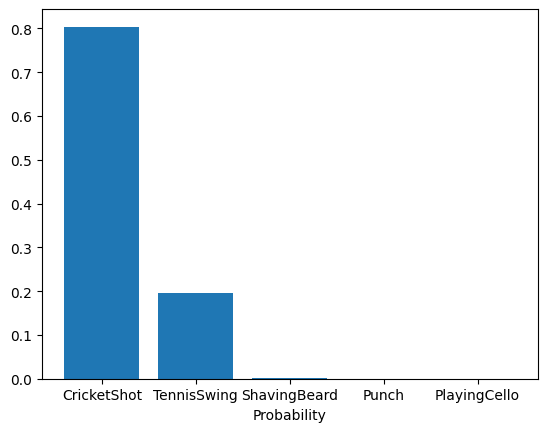

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g05_c06.avi
1/1 [==============================] - 0s 31ms/step
  CricketShot: 75.42%
  TennisSwing: 24.47%
  ShavingBeard:  0.09%
  Punch:  0.01%
  PlayingCello:  0.00%


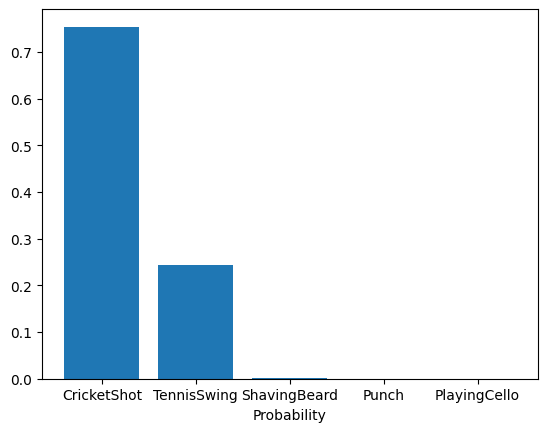

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g05_c07.avi
1/1 [==============================] - 0s 31ms/step
  CricketShot: 93.09%
  TennisSwing:  6.70%
  ShavingBeard:  0.20%
  Punch:  0.01%
  PlayingCello:  0.00%


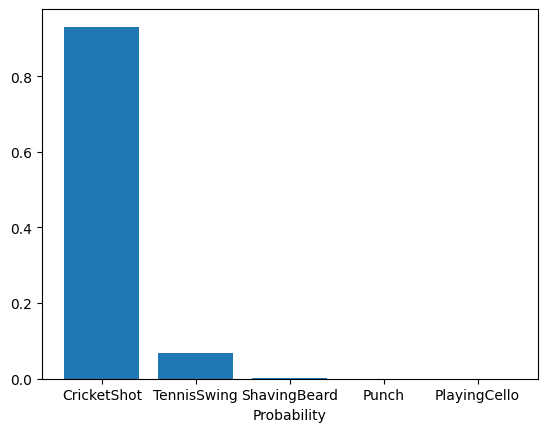

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g06_c01.avi
1/1 [==============================] - 0s 30ms/step
  CricketShot: 52.03%
  TennisSwing: 47.61%
  ShavingBeard:  0.34%
  Punch:  0.01%
  PlayingCello:  0.00%


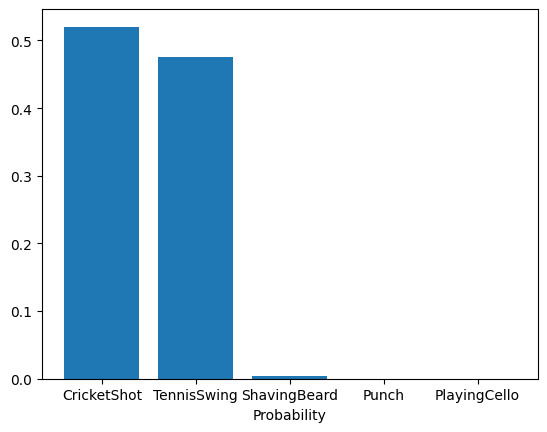

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g06_c02.avi
1/1 [==============================] - 0s 32ms/step
  CricketShot: 77.93%
  TennisSwing: 22.01%
  ShavingBeard:  0.06%
  Punch:  0.00%
  PlayingCello:  0.00%


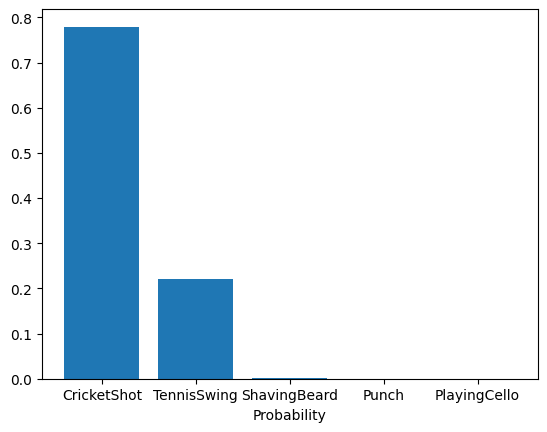

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g06_c03.avi
1/1 [==============================] - 0s 47ms/step
  TennisSwing: 66.47%
  CricketShot: 33.18%
  ShavingBeard:  0.33%
  Punch:  0.02%
  PlayingCello:  0.01%


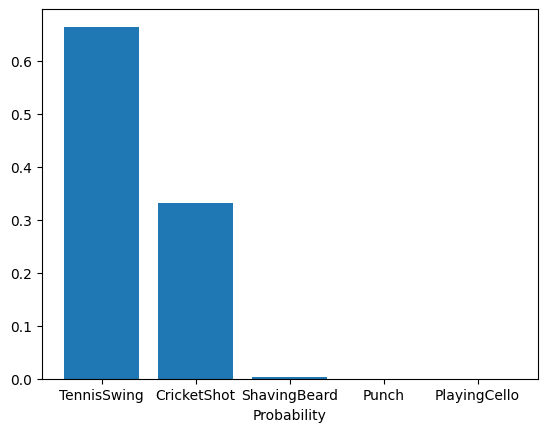

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g06_c04.avi
1/1 [==============================] - 0s 29ms/step
  TennisSwing: 59.60%
  CricketShot: 39.34%
  ShavingBeard:  0.86%
  PlayingCello:  0.13%
  Punch:  0.06%


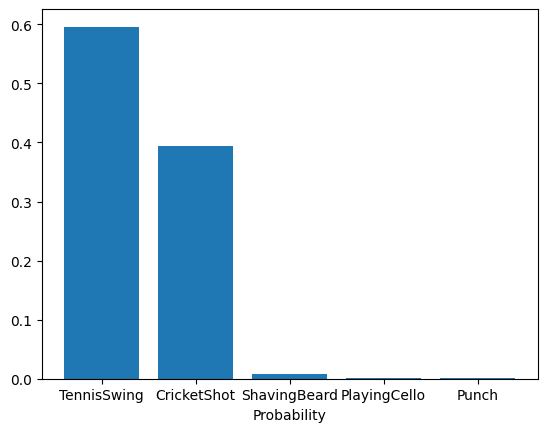

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g06_c05.avi
1/1 [==============================] - 0s 42ms/step
  CricketShot: 53.10%
  TennisSwing: 46.87%
  ShavingBeard:  0.03%
  Punch:  0.00%
  PlayingCello:  0.00%


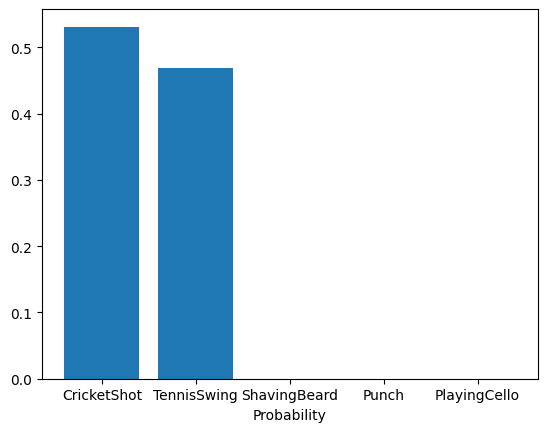

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g06_c06.avi
1/1 [==============================] - 0s 29ms/step
  CricketShot: 58.11%
  TennisSwing: 41.21%
  ShavingBeard:  0.67%
  Punch:  0.01%
  PlayingCello:  0.00%


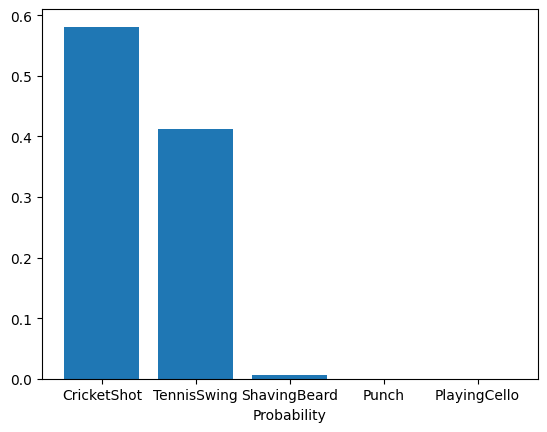

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g06_c07.avi
1/1 [==============================] - 0s 30ms/step
  CricketShot: 84.45%
  TennisSwing: 15.54%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


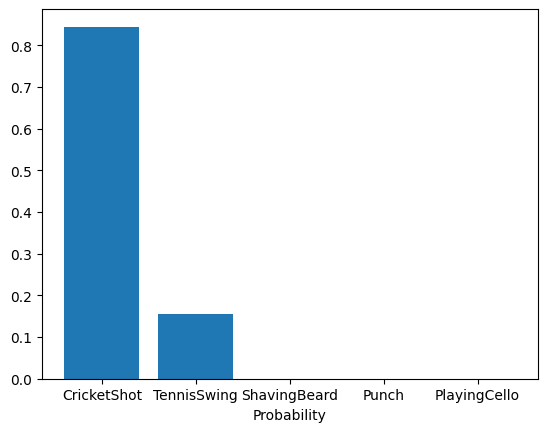

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g07_c01.avi
1/1 [==============================] - 0s 42ms/step
  TennisSwing: 58.68%
  CricketShot: 28.00%
  ShavingBeard: 13.00%
  Punch:  0.31%
  PlayingCello:  0.01%


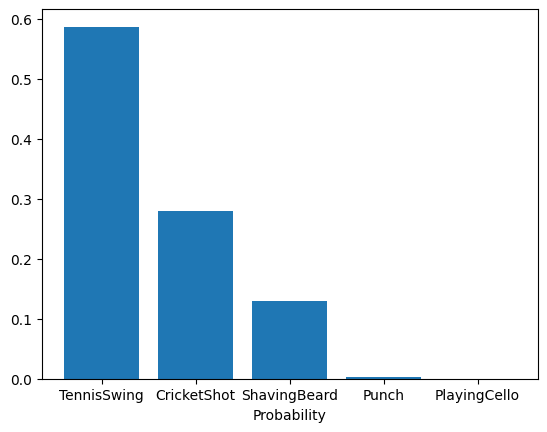

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g07_c02.avi
1/1 [==============================] - 0s 41ms/step
  TennisSwing: 66.63%
  CricketShot: 29.93%
  ShavingBeard:  3.05%
  Punch:  0.31%
  PlayingCello:  0.08%


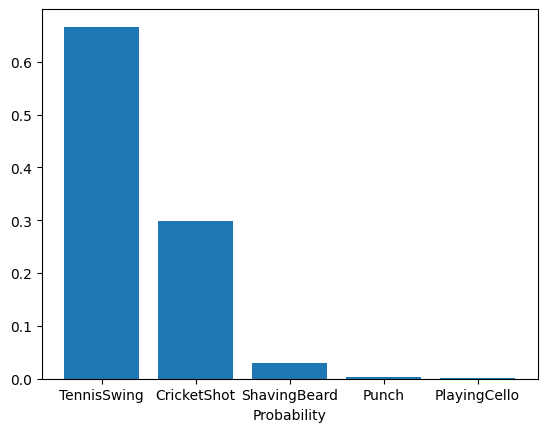

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g07_c03.avi
1/1 [==============================] - 0s 30ms/step
  CricketShot: 57.63%
  TennisSwing: 42.22%
  ShavingBeard:  0.14%
  Punch:  0.01%
  PlayingCello:  0.00%


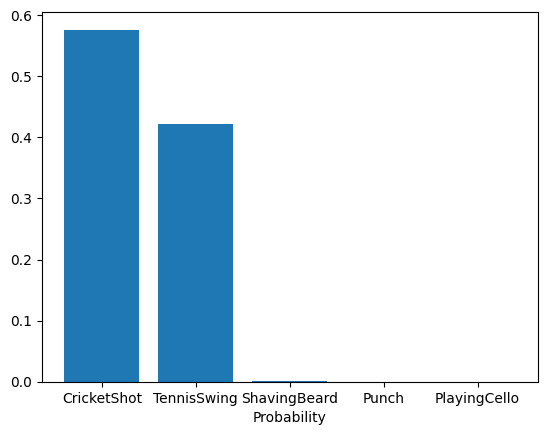

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g07_c04.avi
1/1 [==============================] - 0s 29ms/step
  TennisSwing: 60.56%
  CricketShot: 36.04%
  ShavingBeard:  3.38%
  Punch:  0.02%
  PlayingCello:  0.01%


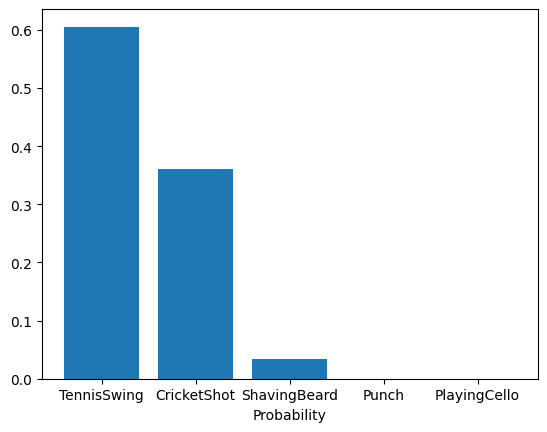

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g07_c05.avi
1/1 [==============================] - 0s 29ms/step
  CricketShot: 87.06%
  TennisSwing: 12.88%
  ShavingBeard:  0.06%
  Punch:  0.00%
  PlayingCello:  0.00%


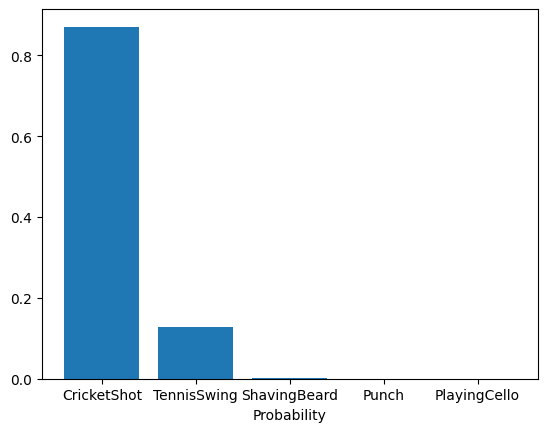

Ground truth: CricketShot
Predicted label: CricketShot


Test video path: v_CricketShot_g07_c06.avi
1/1 [==============================] - 0s 45ms/step
  TennisSwing: 72.10%
  CricketShot: 27.25%
  ShavingBeard:  0.63%
  Punch:  0.02%
  PlayingCello:  0.00%


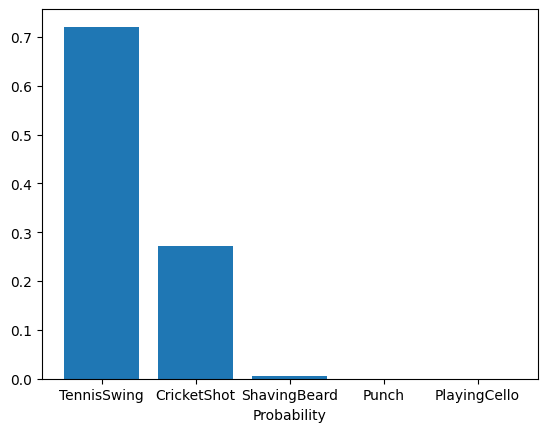

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_CricketShot_g07_c07.avi
1/1 [==============================] - 0s 36ms/step
  TennisSwing: 82.14%
  CricketShot: 17.68%
  ShavingBeard:  0.11%
  Punch:  0.04%
  PlayingCello:  0.03%


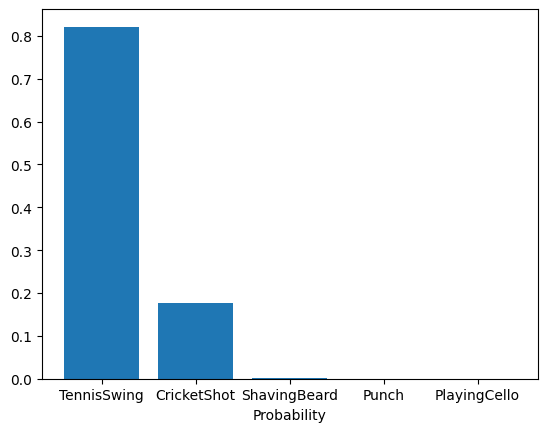

Ground truth: CricketShot
Predicted label: TennisSwing


Test video path: v_PlayingCello_g01_c01.avi
1/1 [==============================] - 0s 63ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


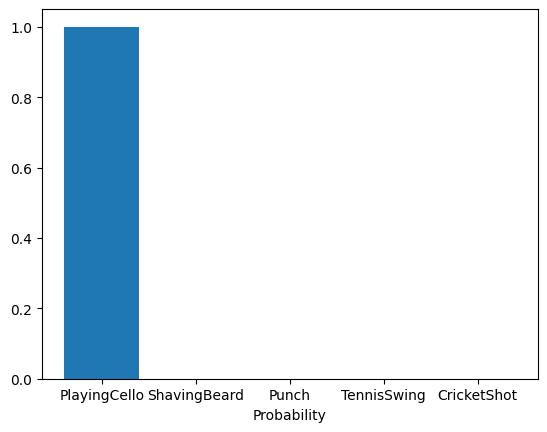

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g01_c02.avi
1/1 [==============================] - 0s 37ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


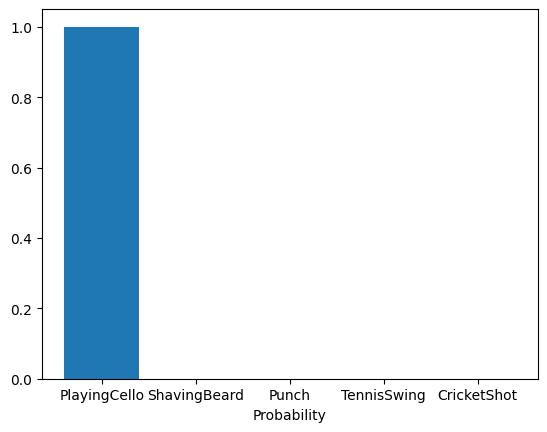

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g01_c03.avi
1/1 [==============================] - 0s 61ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


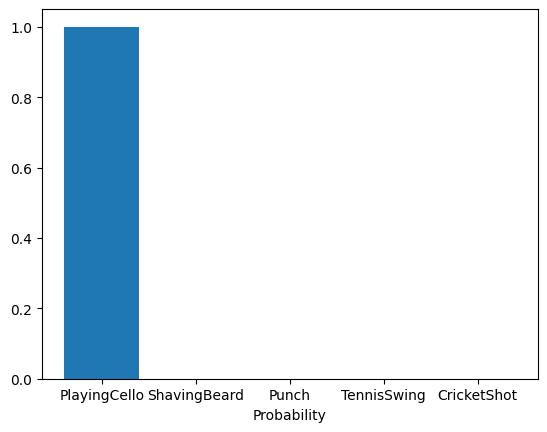

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g01_c04.avi
1/1 [==============================] - 0s 39ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


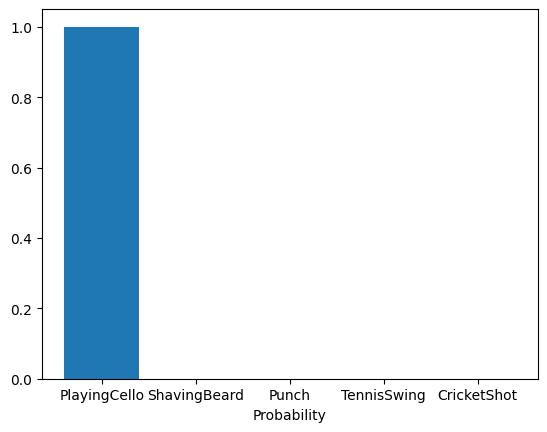

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g01_c05.avi
1/1 [==============================] - 0s 34ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


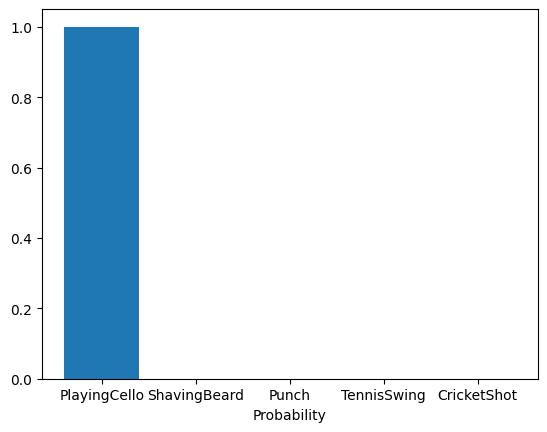

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g01_c06.avi
1/1 [==============================] - 0s 35ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


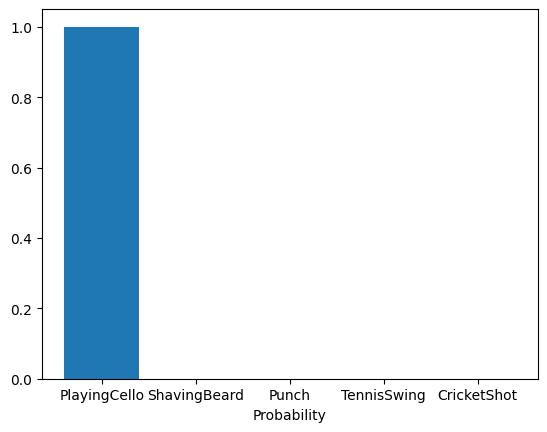

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g01_c07.avi
1/1 [==============================] - 0s 38ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


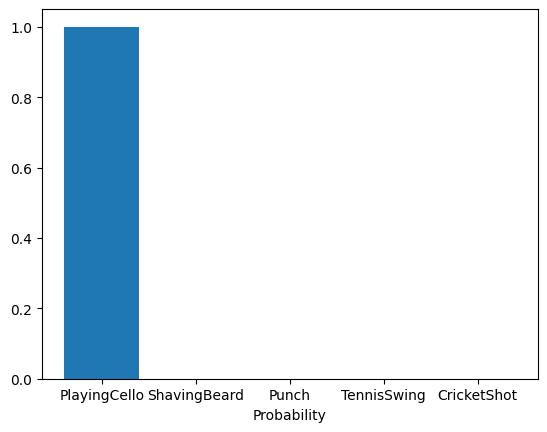

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g02_c01.avi
1/1 [==============================] - 0s 36ms/step
  PlayingCello: 99.57%
  ShavingBeard:  0.43%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


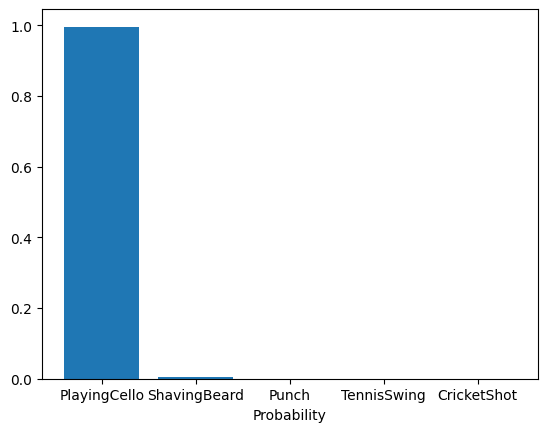

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g02_c02.avi
1/1 [==============================] - 0s 33ms/step
  PlayingCello: 99.44%
  ShavingBeard:  0.53%
  Punch:  0.02%
  TennisSwing:  0.01%
  CricketShot:  0.00%


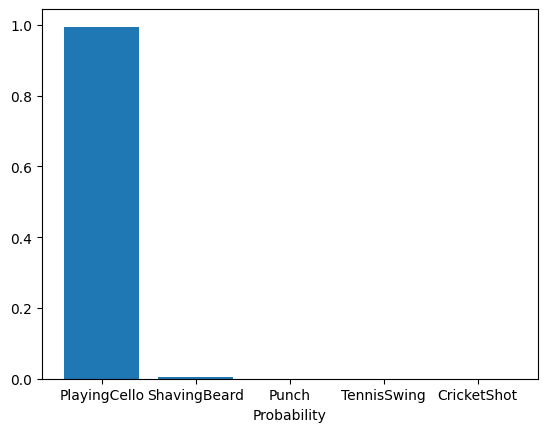

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g02_c03.avi
1/1 [==============================] - 0s 78ms/step
  PlayingCello: 85.78%
  ShavingBeard: 13.45%
  Punch:  0.62%
  TennisSwing:  0.13%
  CricketShot:  0.01%


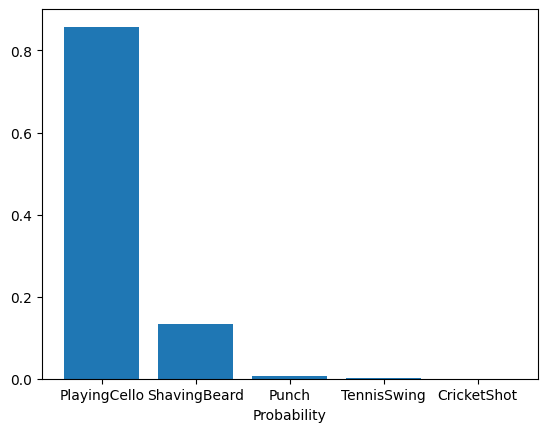

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g02_c04.avi
1/1 [==============================] - 0s 42ms/step
  PlayingCello: 61.58%
  ShavingBeard: 37.67%
  Punch:  0.69%
  TennisSwing:  0.06%
  CricketShot:  0.00%


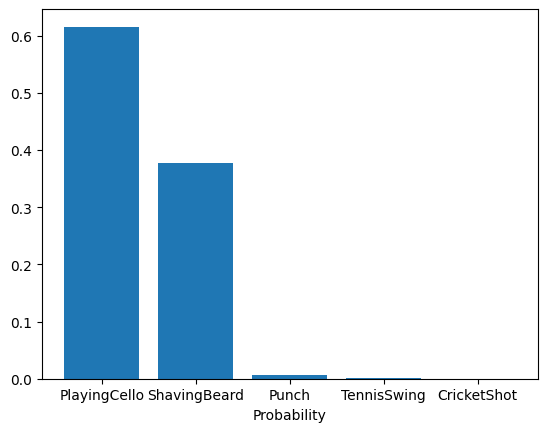

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g02_c05.avi
1/1 [==============================] - 0s 45ms/step
  PlayingCello: 95.57%
  Punch:  2.70%
  ShavingBeard:  1.41%
  TennisSwing:  0.31%
  CricketShot:  0.00%


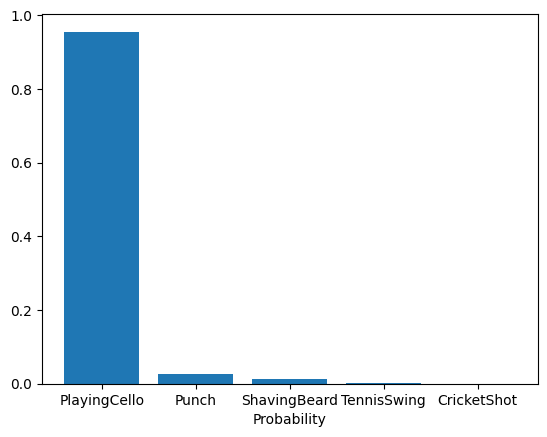

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g02_c06.avi
1/1 [==============================] - 0s 32ms/step
  PlayingCello: 94.18%
  ShavingBeard:  5.79%
  Punch:  0.03%
  TennisSwing:  0.00%
  CricketShot:  0.00%


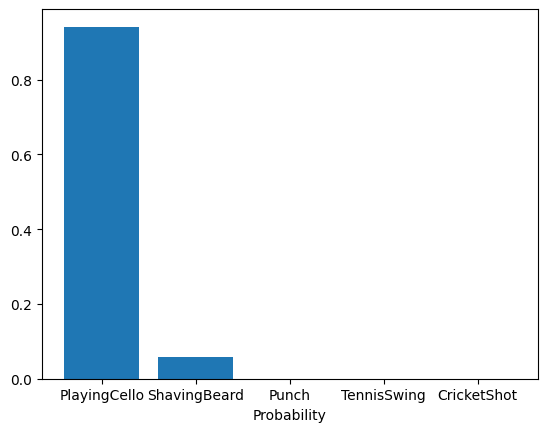

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g02_c07.avi
1/1 [==============================] - 0s 32ms/step
  PlayingCello: 96.21%
  ShavingBeard:  3.60%
  Punch:  0.18%
  TennisSwing:  0.01%
  CricketShot:  0.00%


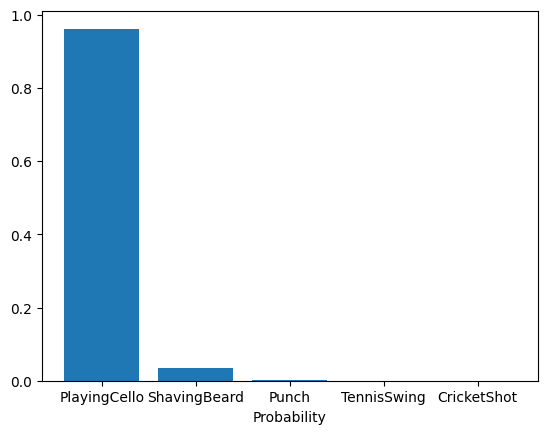

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g03_c01.avi
1/1 [==============================] - 0s 34ms/step
  PlayingCello: 99.99%
  ShavingBeard:  0.01%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


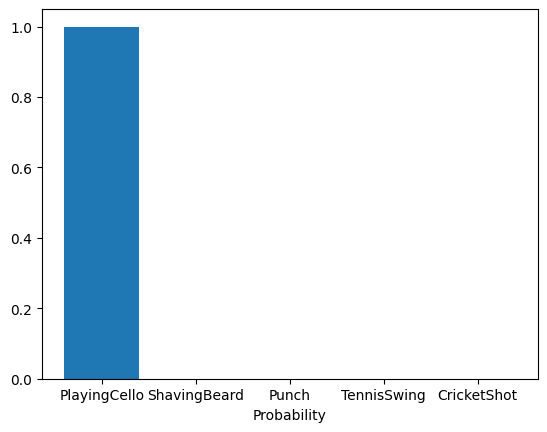

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g03_c02.avi
1/1 [==============================] - 0s 32ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


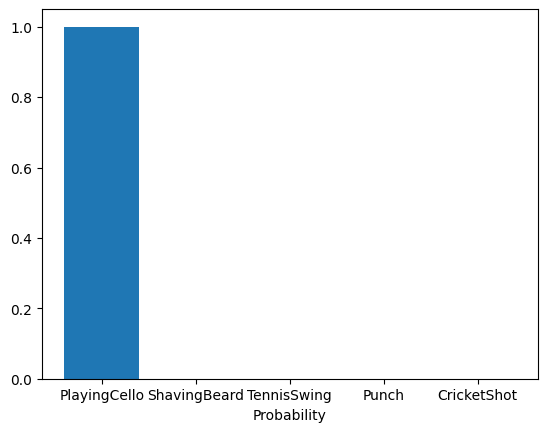

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g03_c03.avi
1/1 [==============================] - 0s 32ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


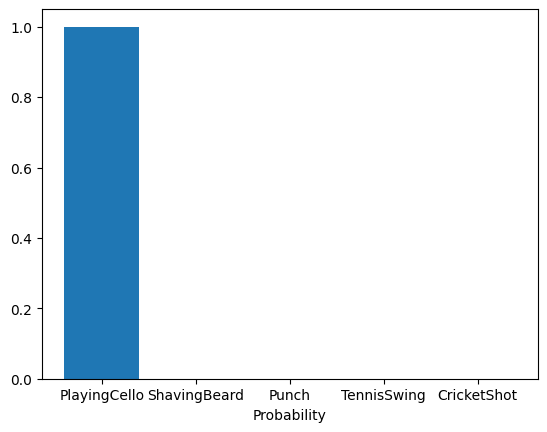

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g03_c04.avi
1/1 [==============================] - 0s 31ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


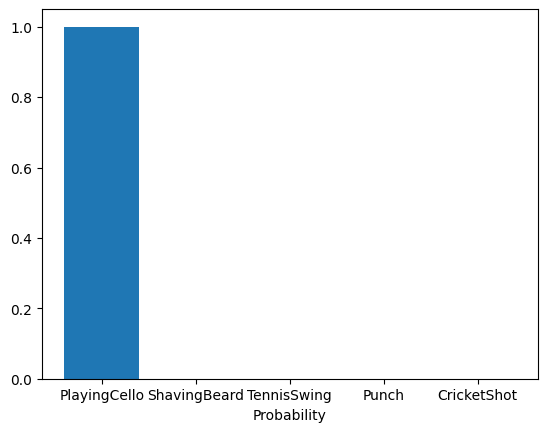

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g04_c01.avi
1/1 [==============================] - 0s 50ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


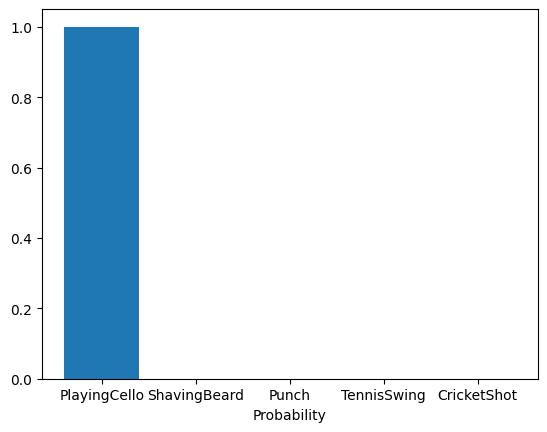

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g04_c02.avi
1/1 [==============================] - 0s 34ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


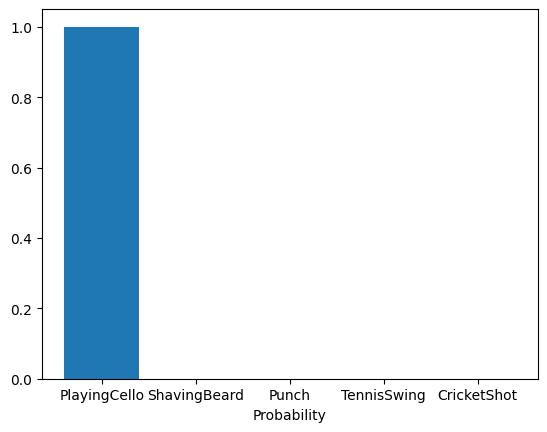

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g04_c03.avi
1/1 [==============================] - 0s 47ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


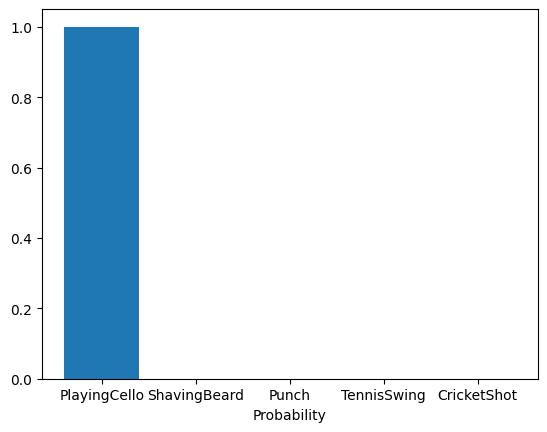

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g04_c04.avi
1/1 [==============================] - 0s 31ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


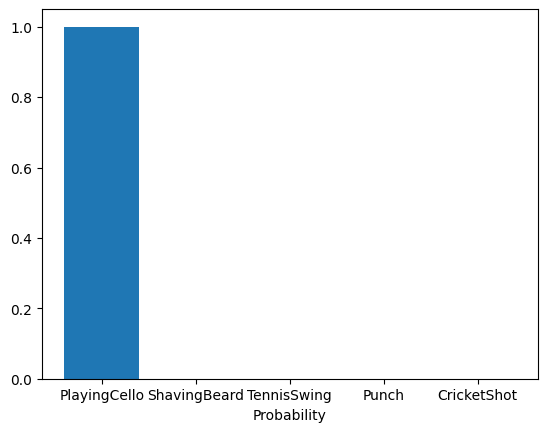

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g04_c05.avi
1/1 [==============================] - 0s 30ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


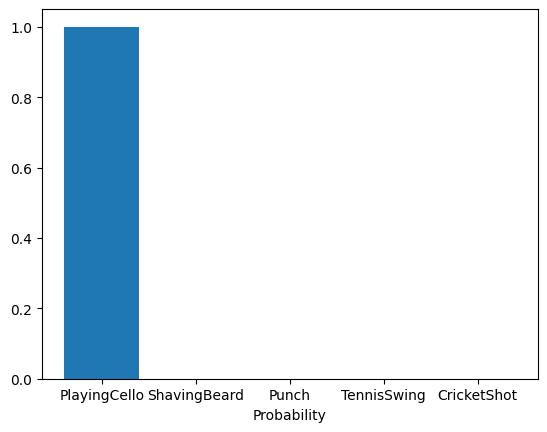

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g04_c06.avi
1/1 [==============================] - 0s 30ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


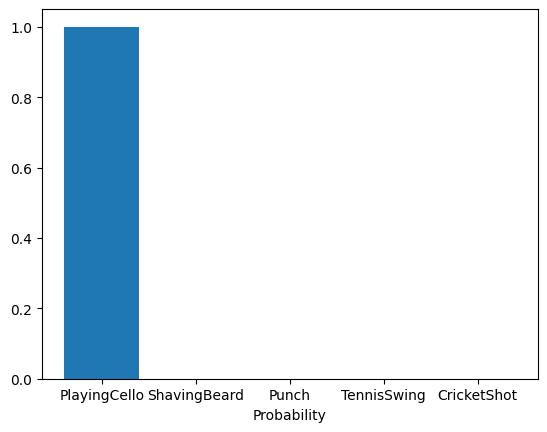

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g04_c07.avi
1/1 [==============================] - 0s 33ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


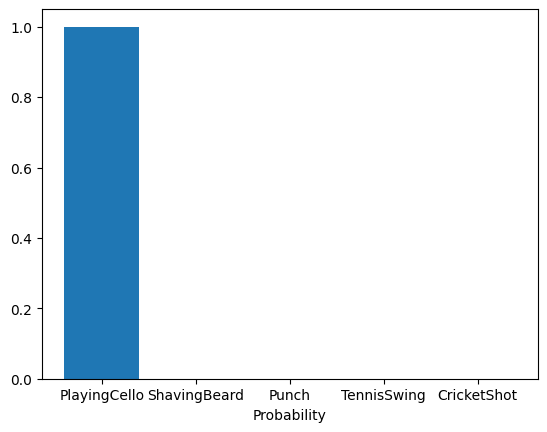

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g05_c01.avi
1/1 [==============================] - 0s 49ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


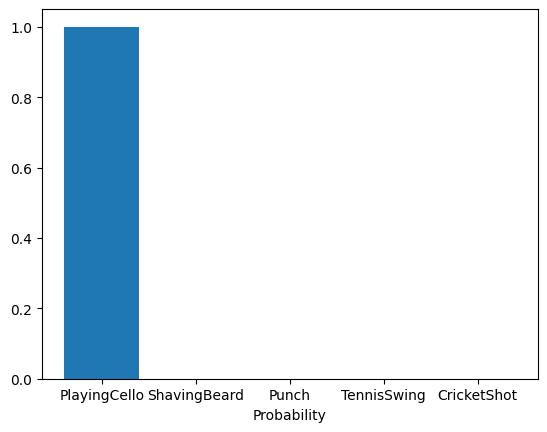

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g05_c02.avi
1/1 [==============================] - 0s 33ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


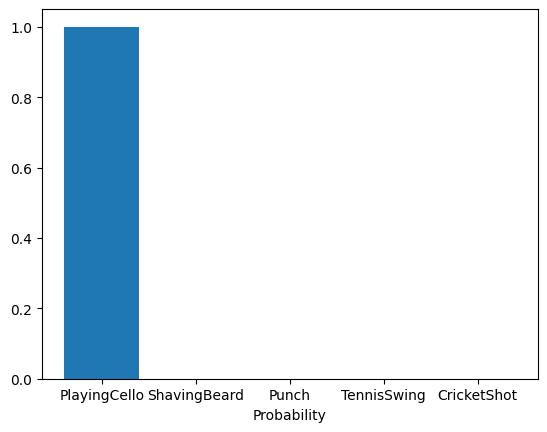

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g05_c03.avi
1/1 [==============================] - 0s 41ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


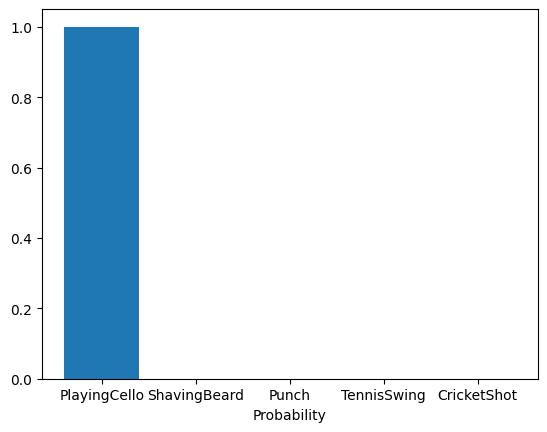

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g05_c04.avi
1/1 [==============================] - 0s 31ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


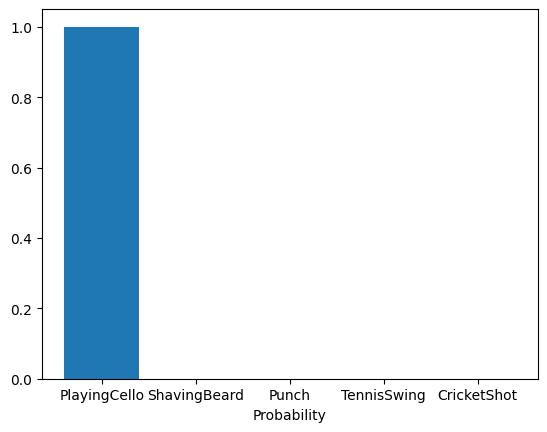

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g05_c05.avi
1/1 [==============================] - 0s 30ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


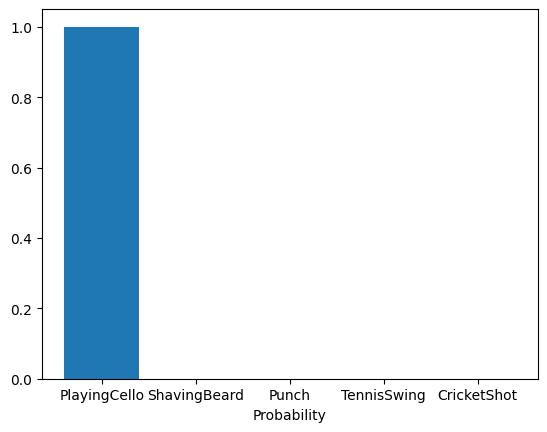

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g05_c06.avi
1/1 [==============================] - 0s 29ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


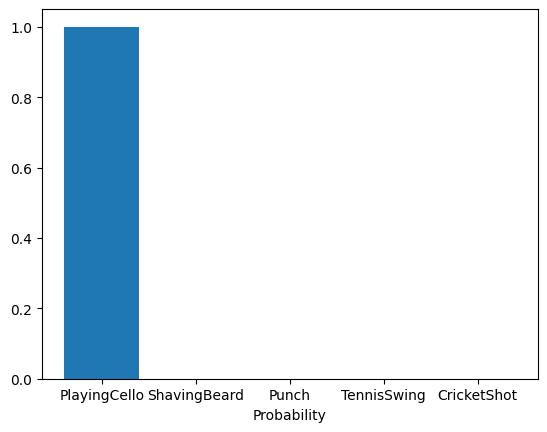

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g05_c07.avi
1/1 [==============================] - 0s 30ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


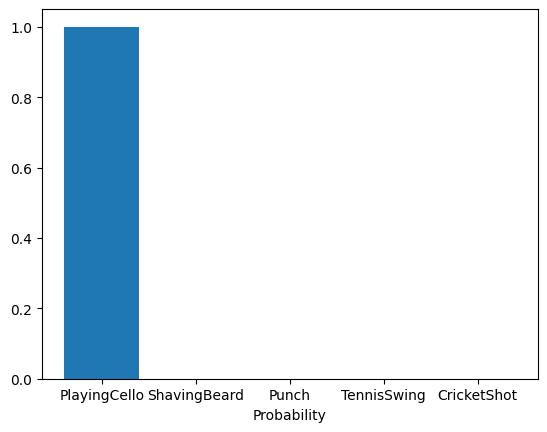

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g06_c01.avi
1/1 [==============================] - 0s 29ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


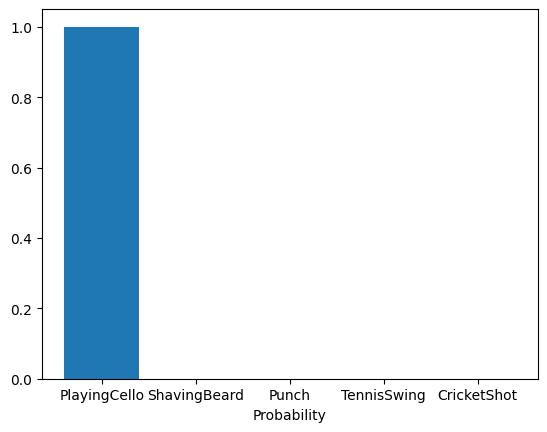

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g06_c02.avi
1/1 [==============================] - 0s 33ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


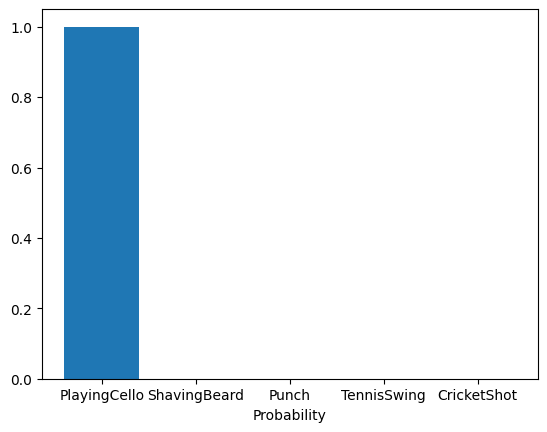

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g06_c03.avi
1/1 [==============================] - 0s 48ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


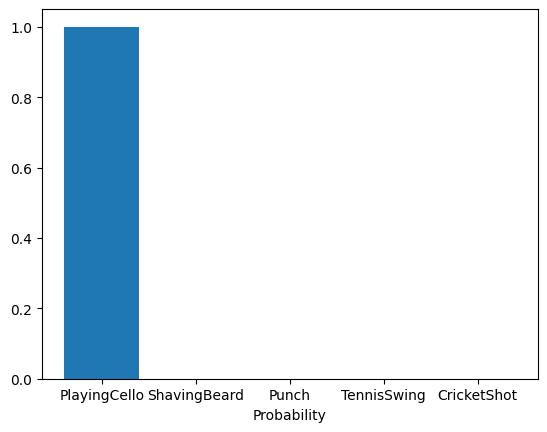

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g06_c04.avi
1/1 [==============================] - 0s 38ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


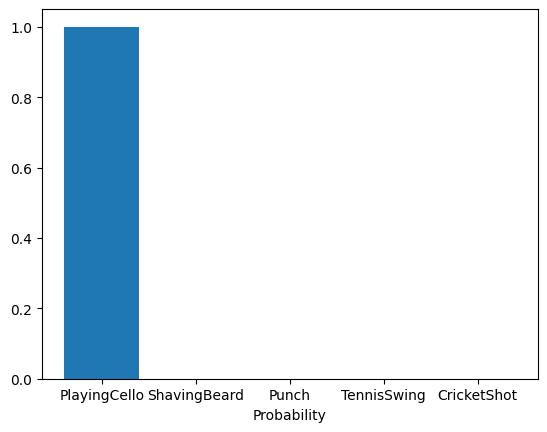

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g06_c05.avi
1/1 [==============================] - 0s 73ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


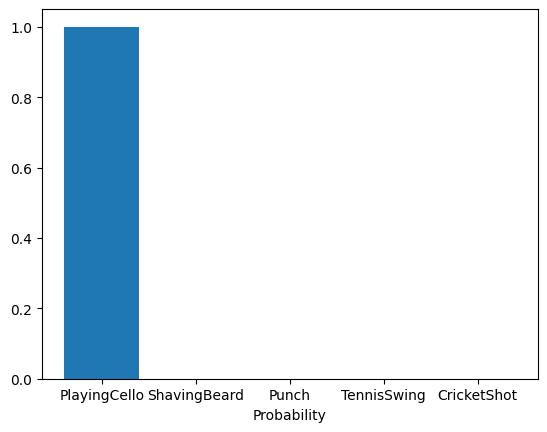

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g06_c06.avi
1/1 [==============================] - 0s 37ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


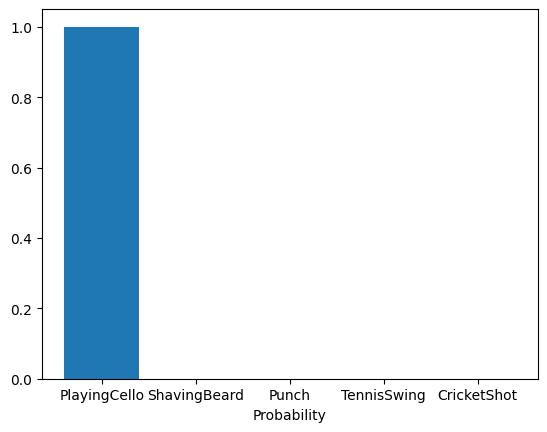

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g06_c07.avi
1/1 [==============================] - 0s 63ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


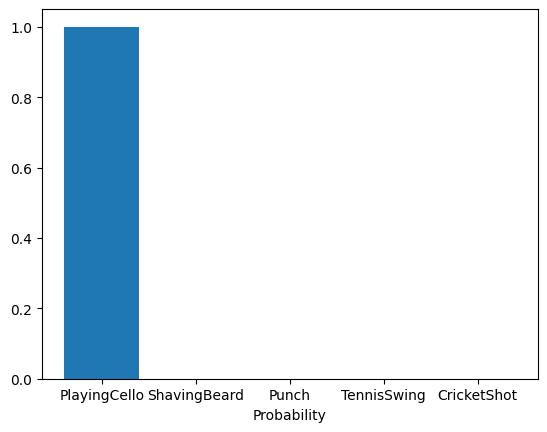

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g07_c01.avi
1/1 [==============================] - 0s 37ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


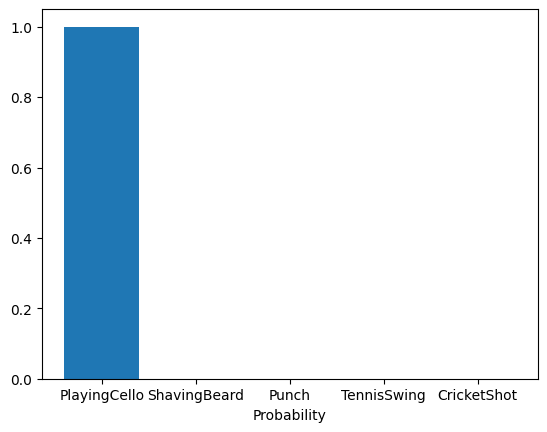

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g07_c02.avi
1/1 [==============================] - 0s 36ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


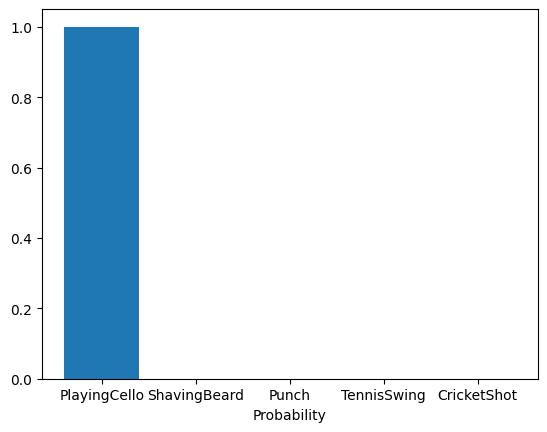

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g07_c03.avi
1/1 [==============================] - 0s 35ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


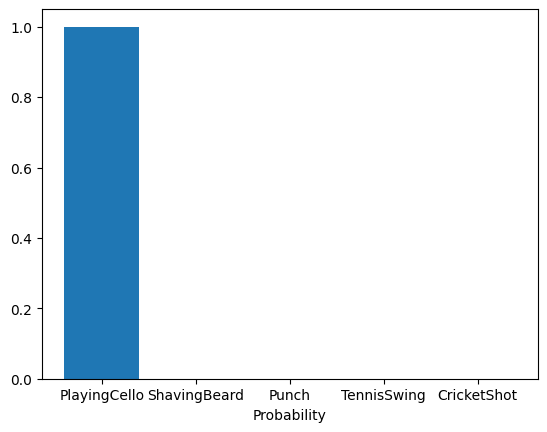

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g07_c04.avi
1/1 [==============================] - 0s 41ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


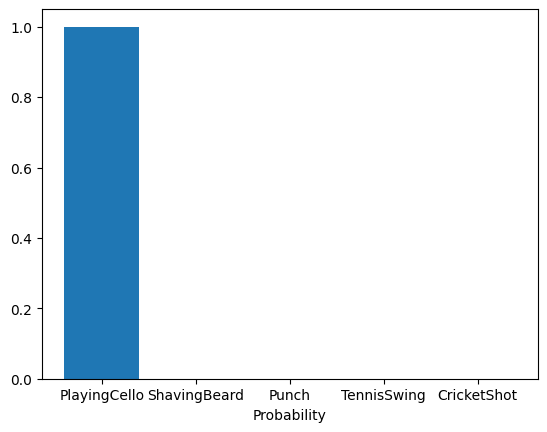

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_PlayingCello_g07_c05.avi
1/1 [==============================] - 0s 32ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


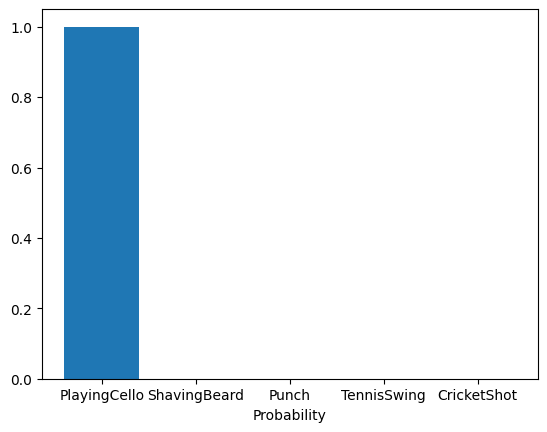

Ground truth: PlayingCello
Predicted label: PlayingCello


Test video path: v_Punch_g01_c01.avi
1/1 [==============================] - 0s 39ms/step
  ShavingBeard: 87.74%
  Punch:  8.43%
  TennisSwing:  2.69%
  CricketShot:  0.68%
  PlayingCello:  0.47%


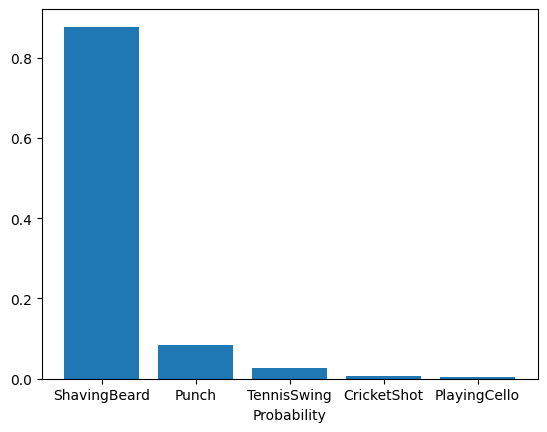

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g01_c02.avi
1/1 [==============================] - 0s 36ms/step
  Punch: 58.83%
  ShavingBeard: 39.10%
  TennisSwing:  1.71%
  CricketShot:  0.29%
  PlayingCello:  0.07%


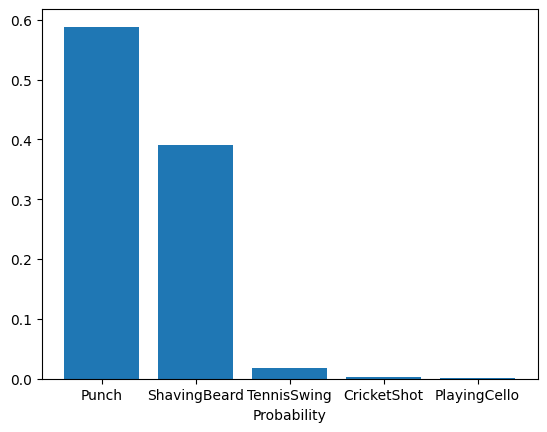

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g01_c03.avi
1/1 [==============================] - 0s 66ms/step
  ShavingBeard: 85.12%
  CricketShot: 13.10%
  TennisSwing:  1.48%
  Punch:  0.20%
  PlayingCello:  0.09%


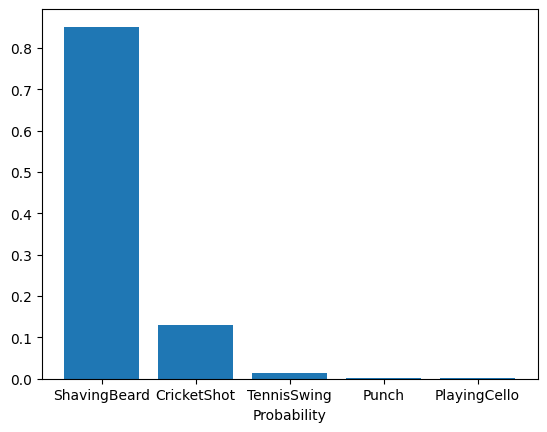

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g01_c04.avi
1/1 [==============================] - 0s 33ms/step
  ShavingBeard: 99.17%
  Punch:  0.52%
  TennisSwing:  0.29%
  PlayingCello:  0.02%
  CricketShot:  0.00%


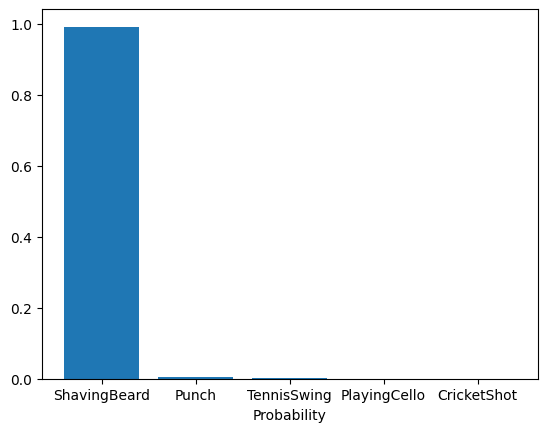

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g01_c05.avi
1/1 [==============================] - 0s 34ms/step
  PlayingCello: 48.27%
  Punch: 46.67%
  ShavingBeard:  4.89%
  TennisSwing:  0.16%
  CricketShot:  0.00%


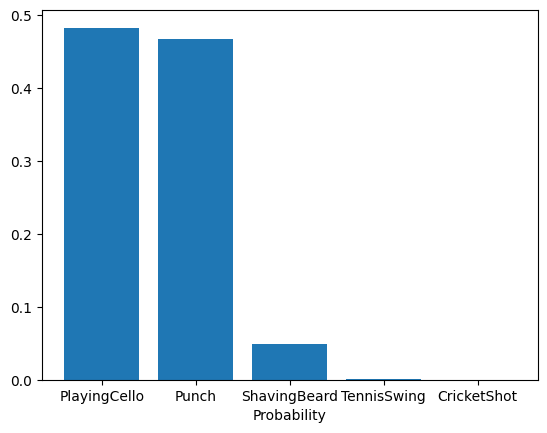

Ground truth: Punch
Predicted label: PlayingCello


Test video path: v_Punch_g02_c01.avi
1/1 [==============================] - 0s 31ms/step
  ShavingBeard: 99.26%
  PlayingCello:  0.71%
  TennisSwing:  0.02%
  Punch:  0.02%
  CricketShot:  0.00%


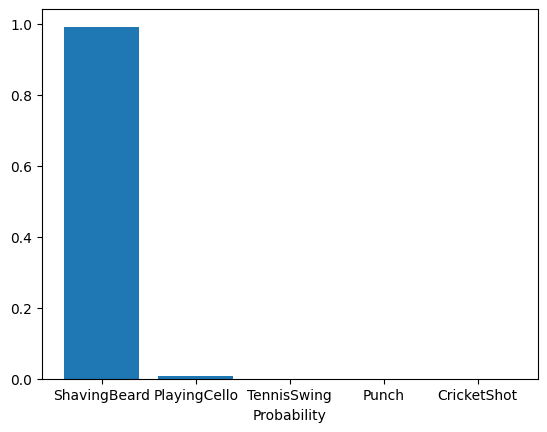

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g02_c02.avi
1/1 [==============================] - 0s 32ms/step
  ShavingBeard: 97.97%
  PlayingCello:  1.31%
  TennisSwing:  0.43%
  Punch:  0.29%
  CricketShot:  0.00%


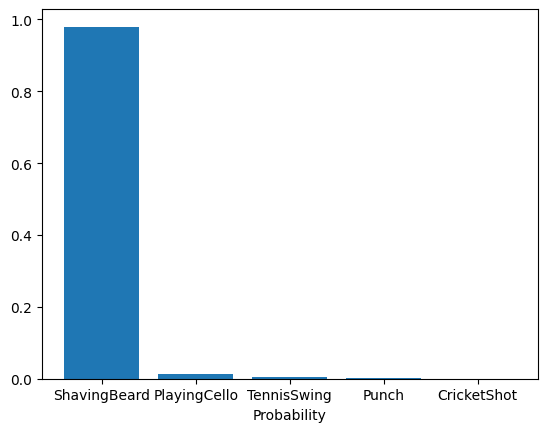

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g02_c03.avi
1/1 [==============================] - 0s 62ms/step
  ShavingBeard: 99.99%
  PlayingCello:  0.01%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


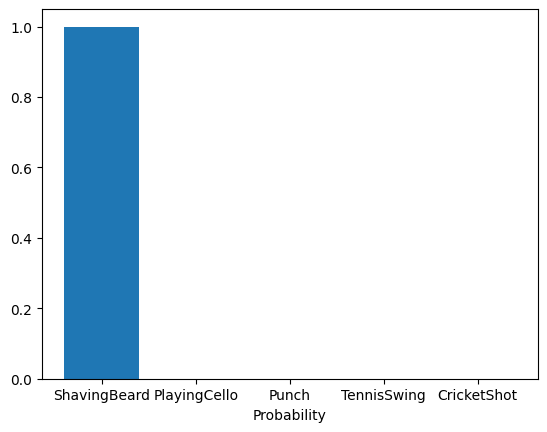

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g02_c04.avi
1/1 [==============================] - 0s 31ms/step
  TennisSwing: 92.71%
  Punch:  3.59%
  CricketShot:  2.18%
  PlayingCello:  0.84%
  ShavingBeard:  0.68%


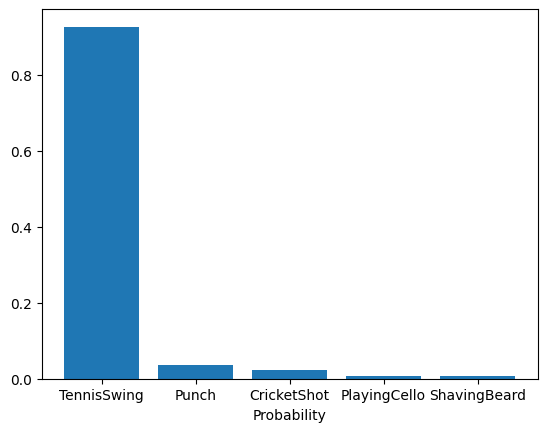

Ground truth: Punch
Predicted label: TennisSwing


Test video path: v_Punch_g03_c01.avi
1/1 [==============================] - 0s 35ms/step
  TennisSwing: 49.37%
  Punch: 46.75%
  PlayingCello:  3.08%
  CricketShot:  0.63%
  ShavingBeard:  0.17%


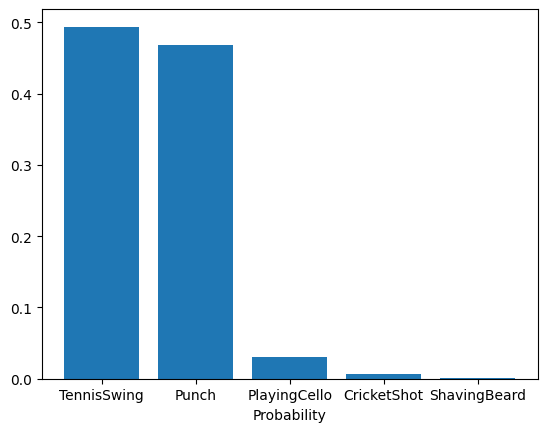

Ground truth: Punch
Predicted label: TennisSwing


Test video path: v_Punch_g03_c02.avi
1/1 [==============================] - 0s 35ms/step
  ShavingBeard: 74.03%
  Punch: 21.24%
  PlayingCello:  4.34%
  TennisSwing:  0.40%
  CricketShot:  0.00%


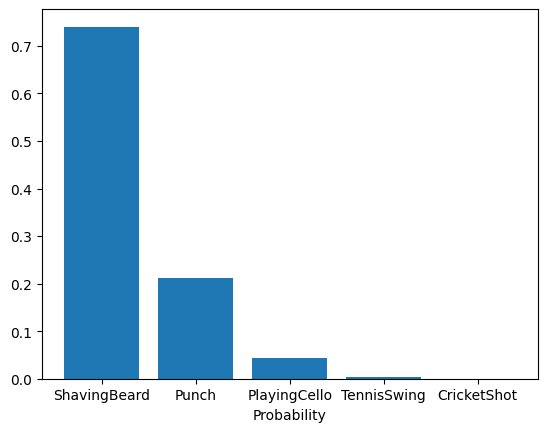

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g03_c03.avi
1/1 [==============================] - 0s 33ms/step
  ShavingBeard: 82.15%
  Punch: 10.81%
  PlayingCello:  4.07%
  TennisSwing:  2.94%
  CricketShot:  0.02%


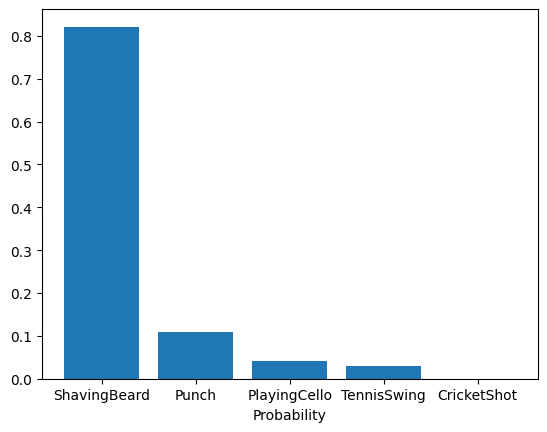

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g03_c04.avi
1/1 [==============================] - 0s 33ms/step
  ShavingBeard: 95.45%
  Punch:  2.54%
  PlayingCello:  1.78%
  TennisSwing:  0.22%
  CricketShot:  0.00%


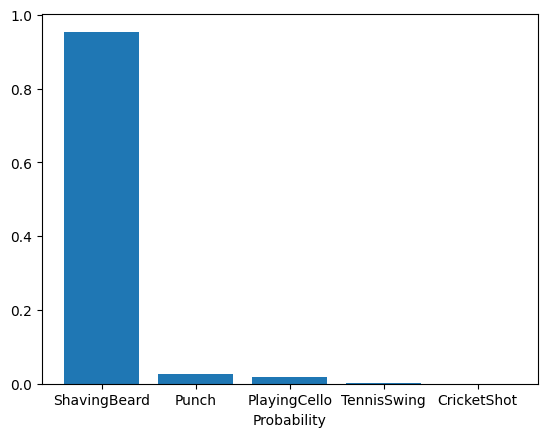

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g04_c01.avi
1/1 [==============================] - 0s 32ms/step
  ShavingBeard: 55.92%
  Punch: 39.38%
  PlayingCello:  4.49%
  TennisSwing:  0.21%
  CricketShot:  0.00%


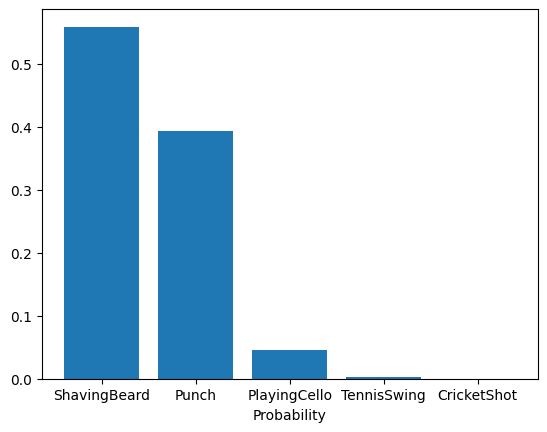

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g04_c02.avi
1/1 [==============================] - 0s 31ms/step
  ShavingBeard: 99.99%
  Punch:  0.01%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


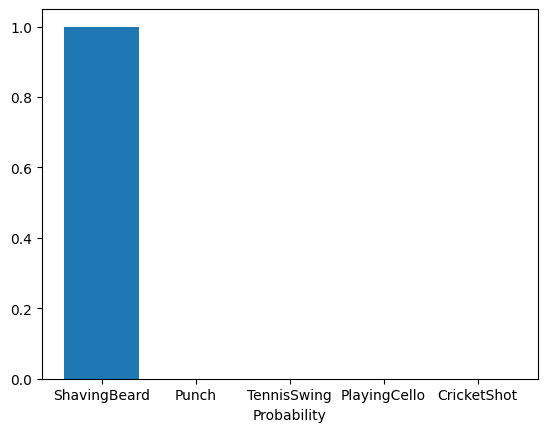

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g04_c03.avi
1/1 [==============================] - 0s 34ms/step
  Punch: 56.92%
  ShavingBeard: 38.58%
  PlayingCello:  4.28%
  TennisSwing:  0.22%
  CricketShot:  0.00%


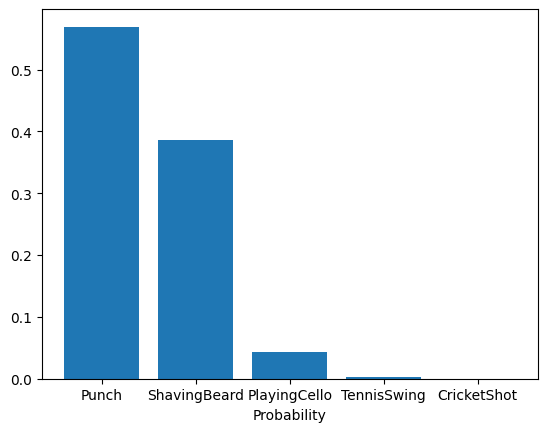

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g04_c04.avi
1/1 [==============================] - 0s 30ms/step
  ShavingBeard: 99.48%
  Punch:  0.46%
  PlayingCello:  0.04%
  TennisSwing:  0.03%
  CricketShot:  0.00%


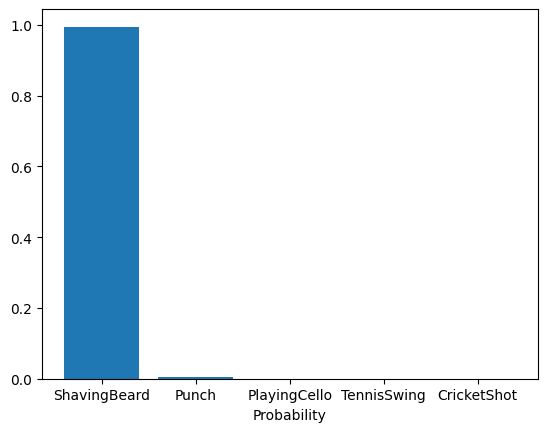

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g04_c05.avi
1/1 [==============================] - 0s 29ms/step
  Punch: 42.68%
  TennisSwing: 29.09%
  ShavingBeard: 14.35%
  PlayingCello: 13.23%
  CricketShot:  0.64%


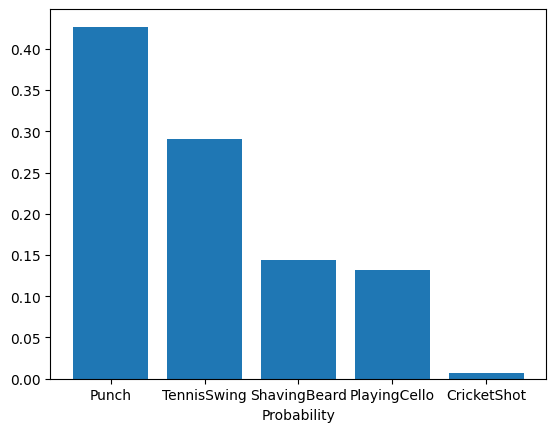

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g05_c01.avi
1/1 [==============================] - 0s 43ms/step
  Punch: 52.26%
  PlayingCello: 25.30%
  TennisSwing: 16.57%
  ShavingBeard:  5.83%
  CricketShot:  0.03%


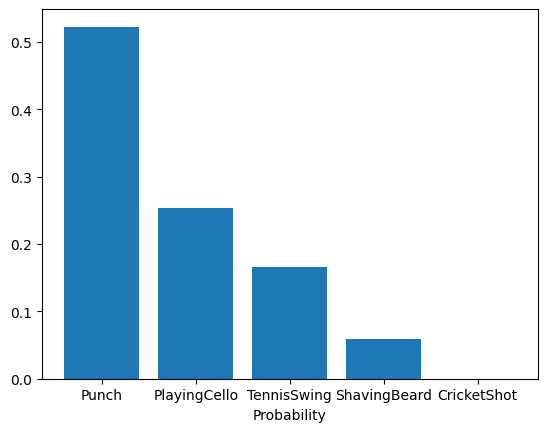

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g05_c02.avi
1/1 [==============================] - 0s 30ms/step
  Punch: 63.79%
  ShavingBeard: 24.03%
  PlayingCello: 11.61%
  TennisSwing:  0.57%
  CricketShot:  0.00%


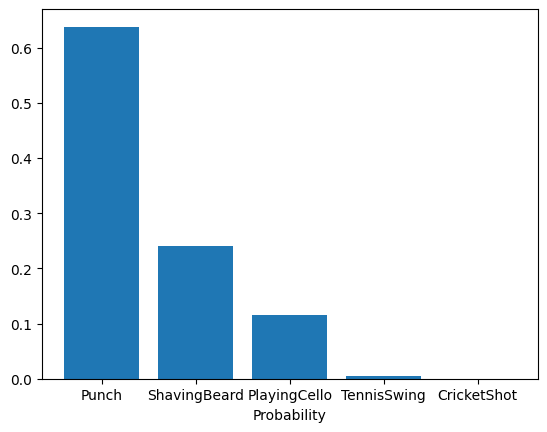

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g05_c03.avi
1/1 [==============================] - 0s 50ms/step
  Punch: 67.62%
  PlayingCello: 30.15%
  ShavingBeard:  1.79%
  TennisSwing:  0.44%
  CricketShot:  0.00%


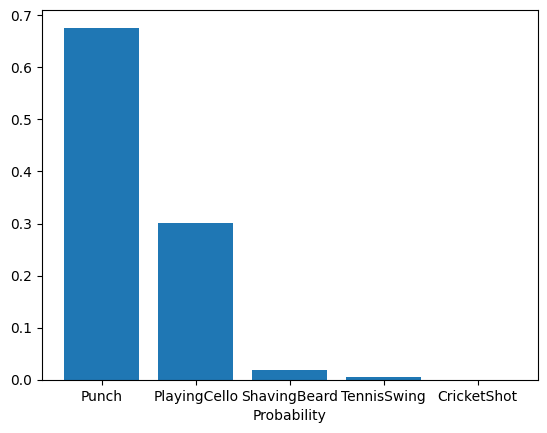

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g05_c04.avi
1/1 [==============================] - 0s 31ms/step
  ShavingBeard: 68.12%
  Punch: 25.27%
  PlayingCello:  6.15%
  TennisSwing:  0.46%
  CricketShot:  0.00%


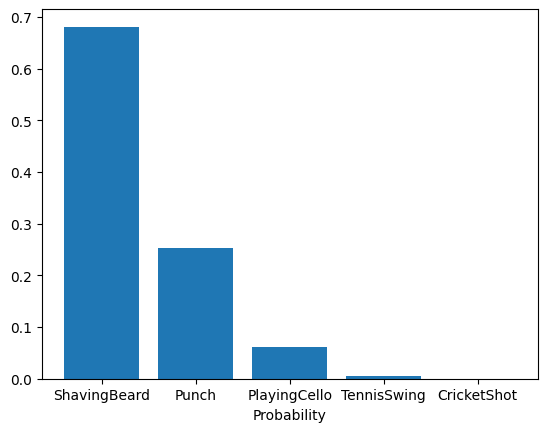

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g05_c05.avi
1/1 [==============================] - 0s 55ms/step
  ShavingBeard: 99.99%
  Punch:  0.01%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


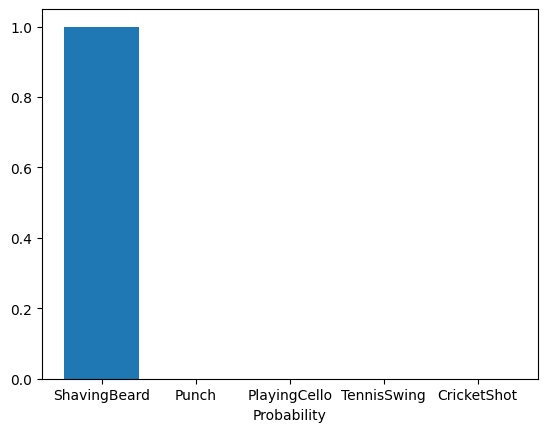

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g05_c06.avi
1/1 [==============================] - 0s 29ms/step
  Punch: 38.97%
  ShavingBeard: 38.10%
  PlayingCello: 20.49%
  TennisSwing:  2.40%
  CricketShot:  0.04%


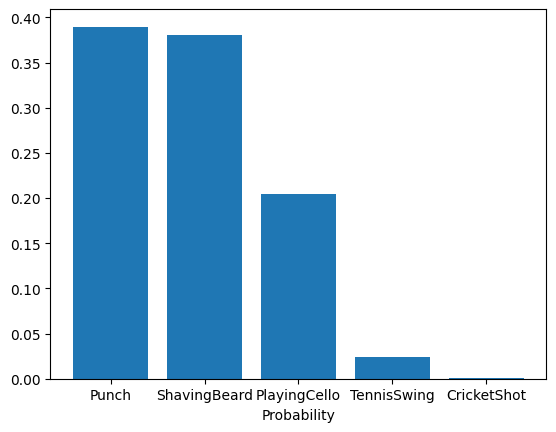

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g05_c07.avi
1/1 [==============================] - 0s 57ms/step
  ShavingBeard: 92.12%
  PlayingCello:  7.57%
  Punch:  0.30%
  TennisSwing:  0.00%
  CricketShot:  0.00%


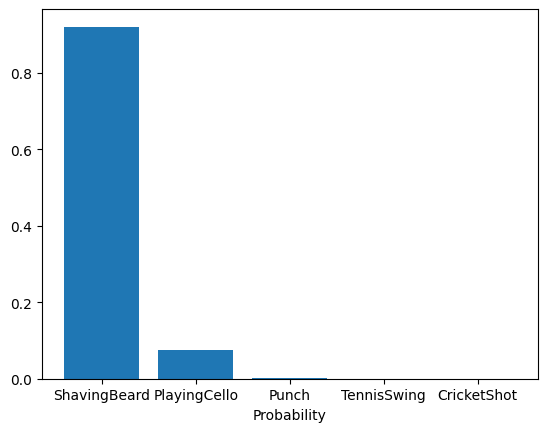

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g06_c01.avi
1/1 [==============================] - 0s 31ms/step
  Punch: 56.80%
  TennisSwing: 26.61%
  PlayingCello: 12.52%
  ShavingBeard:  3.96%
  CricketShot:  0.11%


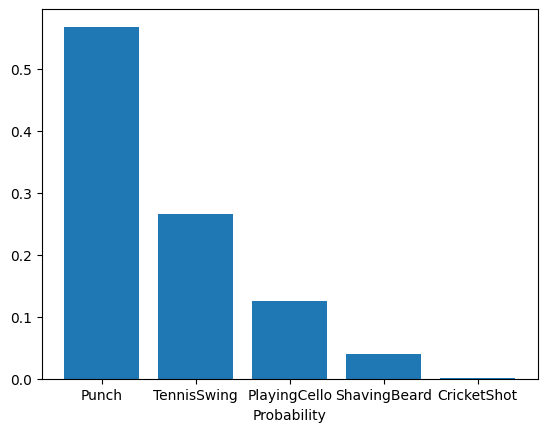

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g06_c02.avi
1/1 [==============================] - 0s 69ms/step
  Punch: 92.49%
  TennisSwing:  3.72%
  PlayingCello:  2.72%
  ShavingBeard:  1.05%
  CricketShot:  0.03%


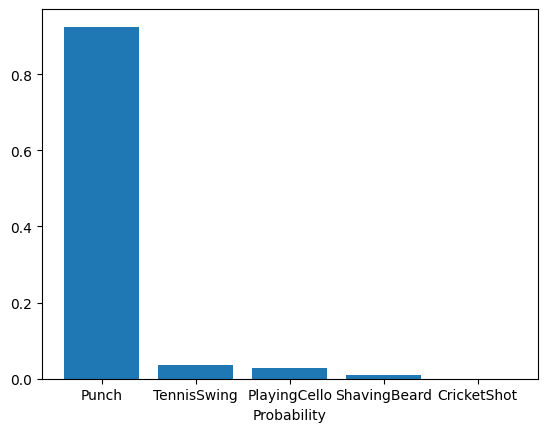

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g06_c03.avi
1/1 [==============================] - 0s 30ms/step
  Punch: 63.51%
  PlayingCello: 31.27%
  ShavingBeard:  3.81%
  TennisSwing:  1.40%
  CricketShot:  0.01%


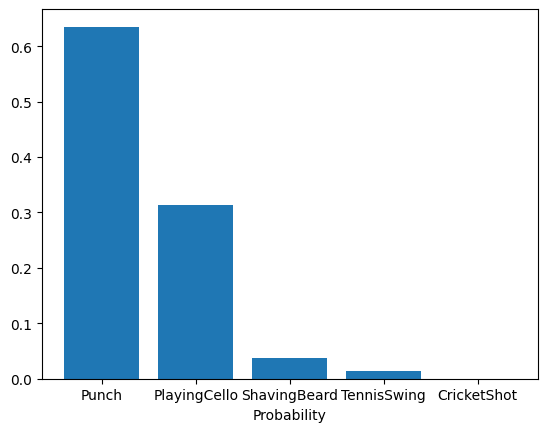

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g06_c04.avi
1/1 [==============================] - 0s 73ms/step
  TennisSwing: 45.76%
  Punch: 35.11%
  PlayingCello: 11.83%
  ShavingBeard:  7.17%
  CricketShot:  0.14%


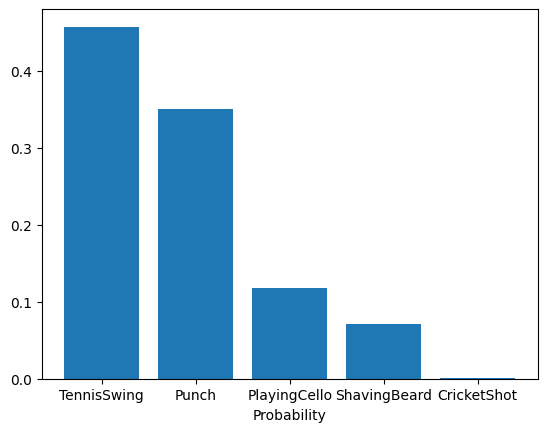

Ground truth: Punch
Predicted label: TennisSwing


Test video path: v_Punch_g06_c05.avi
1/1 [==============================] - 0s 46ms/step
  Punch: 71.96%
  PlayingCello: 24.45%
  TennisSwing:  1.84%
  ShavingBeard:  1.76%
  CricketShot:  0.00%


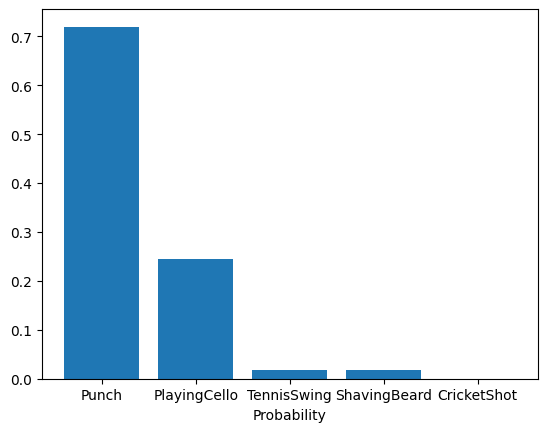

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g06_c06.avi
1/1 [==============================] - 0s 40ms/step
  PlayingCello: 75.86%
  Punch: 17.43%
  ShavingBeard:  5.24%
  TennisSwing:  1.46%
  CricketShot:  0.00%


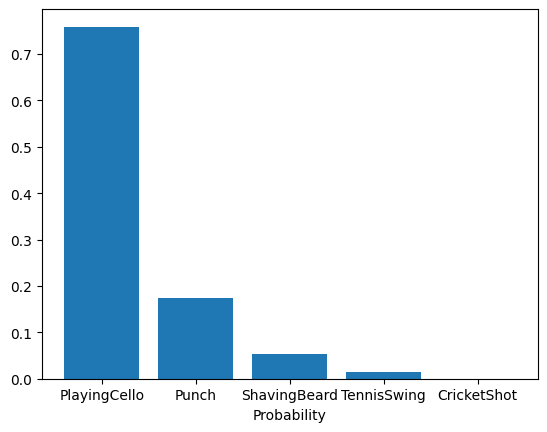

Ground truth: Punch
Predicted label: PlayingCello


Test video path: v_Punch_g06_c07.avi
1/1 [==============================] - 0s 37ms/step
  TennisSwing: 45.09%
  Punch: 40.87%
  ShavingBeard:  9.51%
  PlayingCello:  4.00%
  CricketShot:  0.52%


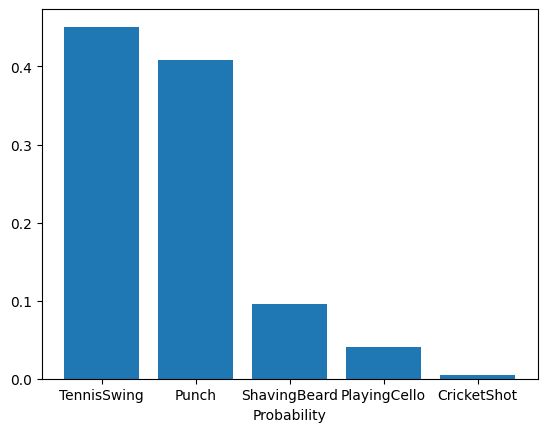

Ground truth: Punch
Predicted label: TennisSwing


Test video path: v_Punch_g07_c01.avi
1/1 [==============================] - 0s 42ms/step
  ShavingBeard: 95.22%
  Punch:  4.30%
  PlayingCello:  0.40%
  TennisSwing:  0.07%
  CricketShot:  0.00%


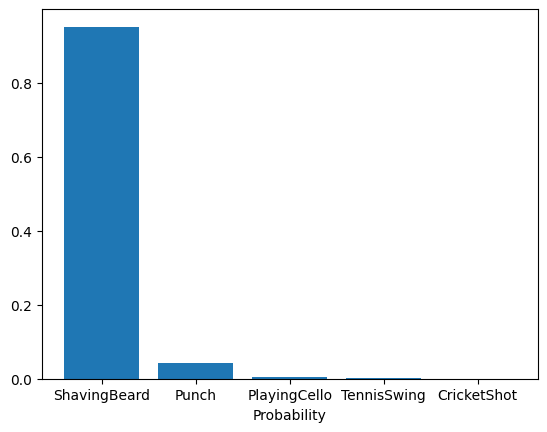

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g07_c02.avi
1/1 [==============================] - 0s 37ms/step
  Punch: 51.40%
  PlayingCello: 23.72%
  ShavingBeard: 16.02%
  TennisSwing:  8.85%
  CricketShot:  0.01%


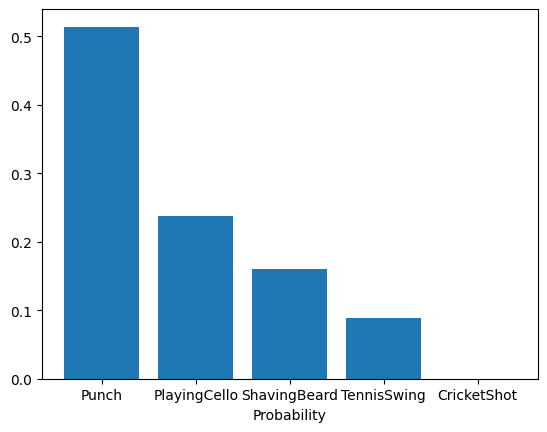

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g07_c03.avi
1/1 [==============================] - 0s 45ms/step
  ShavingBeard: 99.47%
  PlayingCello:  0.36%
  Punch:  0.17%
  TennisSwing:  0.00%
  CricketShot:  0.00%


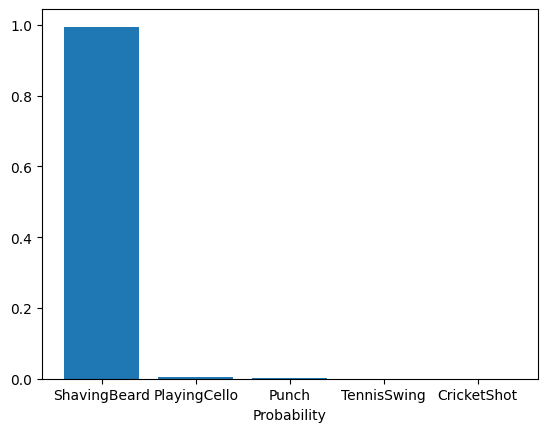

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g07_c04.avi
1/1 [==============================] - 0s 42ms/step
  ShavingBeard: 99.44%
  Punch:  0.35%
  PlayingCello:  0.21%
  TennisSwing:  0.00%
  CricketShot:  0.00%


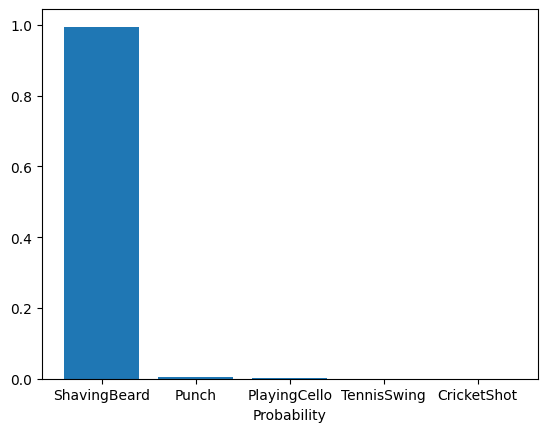

Ground truth: Punch
Predicted label: ShavingBeard


Test video path: v_Punch_g07_c05.avi
1/1 [==============================] - 0s 38ms/step
  Punch: 90.48%
  PlayingCello:  7.08%
  ShavingBeard:  2.07%
  TennisSwing:  0.37%
  CricketShot:  0.00%


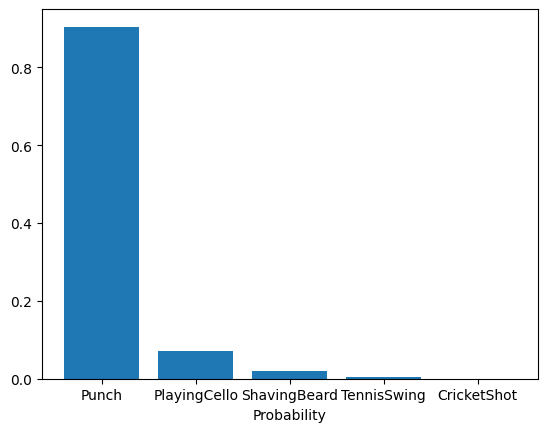

Ground truth: Punch
Predicted label: Punch


Test video path: v_Punch_g07_c06.avi
1/1 [==============================] - 0s 52ms/step
  PlayingCello: 47.42%
  Punch: 39.15%
  ShavingBeard: 11.83%
  TennisSwing:  1.60%
  CricketShot:  0.01%


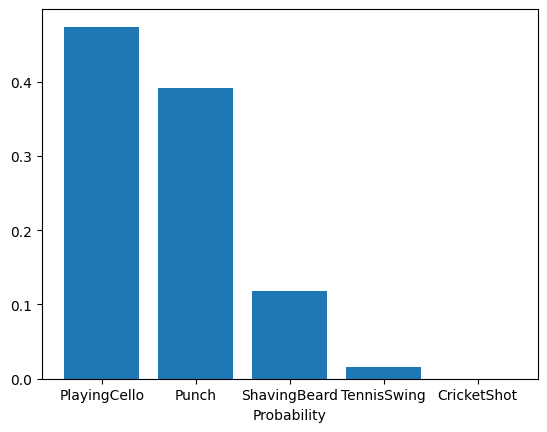

Ground truth: Punch
Predicted label: PlayingCello


Test video path: v_Punch_g07_c07.avi
1/1 [==============================] - 0s 33ms/step
  TennisSwing: 60.89%
  PlayingCello: 25.22%
  Punch:  6.99%
  ShavingBeard:  5.03%
  CricketShot:  1.87%


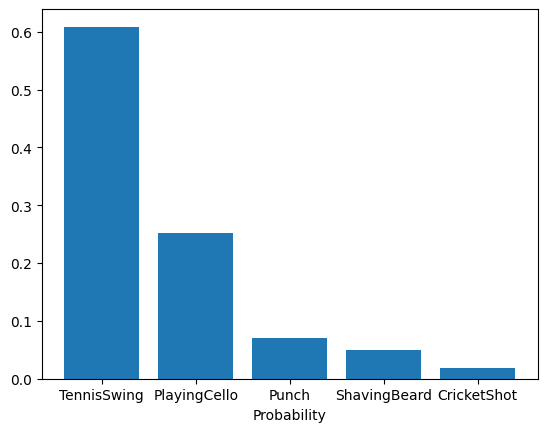

Ground truth: Punch
Predicted label: TennisSwing


Test video path: v_ShavingBeard_g01_c01.avi
1/1 [==============================] - 0s 45ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


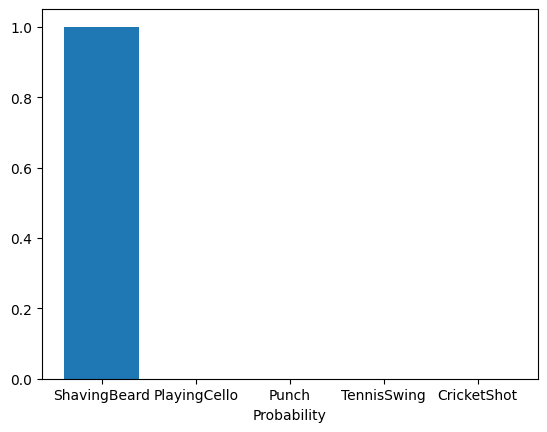

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g01_c02.avi
1/1 [==============================] - 0s 34ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


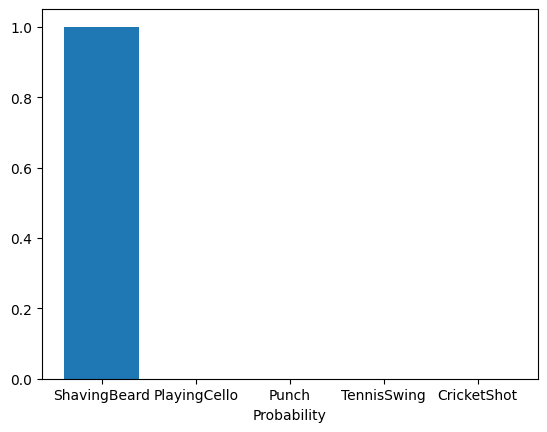

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g01_c03.avi
1/1 [==============================] - 0s 33ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


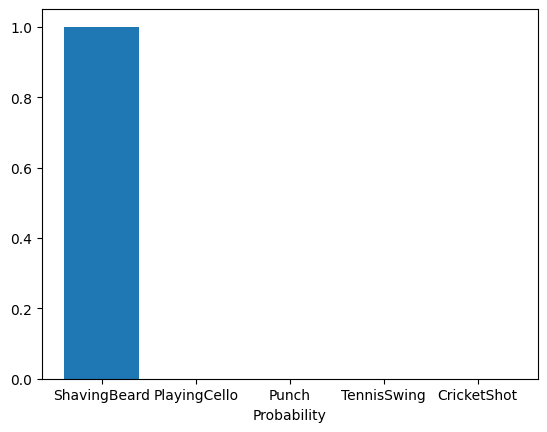

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g01_c04.avi
1/1 [==============================] - 0s 36ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


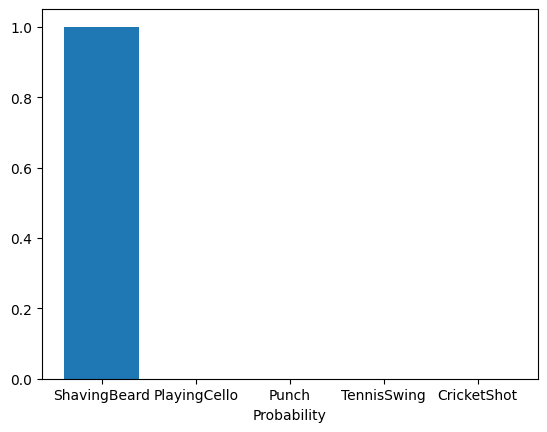

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g02_c01.avi
1/1 [==============================] - 0s 34ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


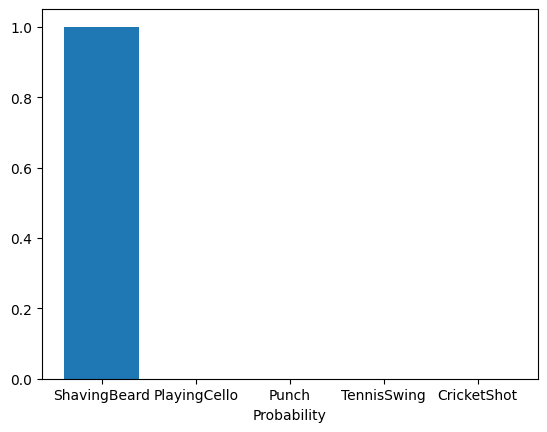

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g02_c02.avi
1/1 [==============================] - 0s 32ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


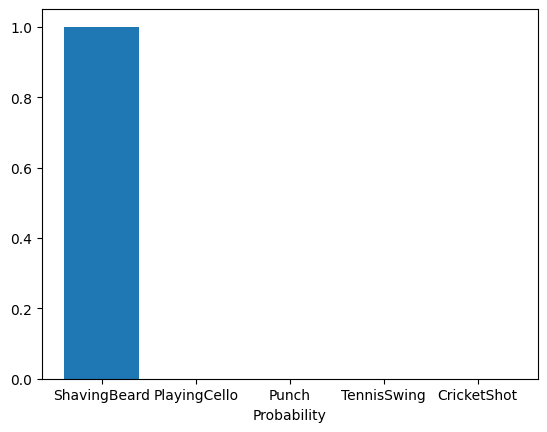

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g02_c03.avi
1/1 [==============================] - 0s 31ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


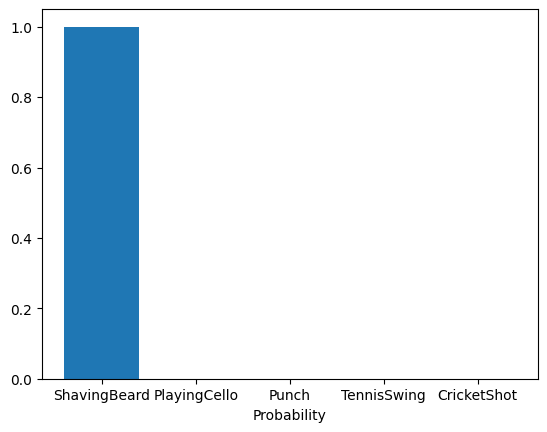

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g02_c04.avi
1/1 [==============================] - 0s 51ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


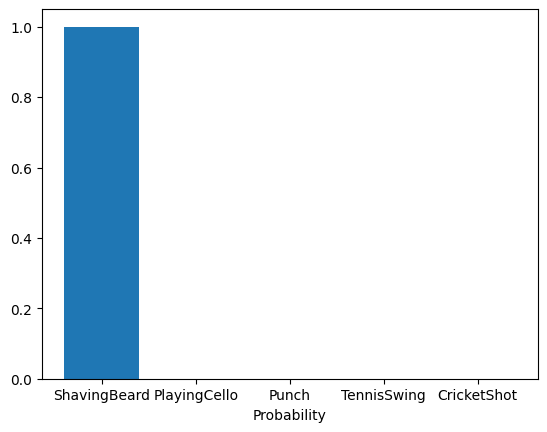

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g02_c05.avi
1/1 [==============================] - 0s 34ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


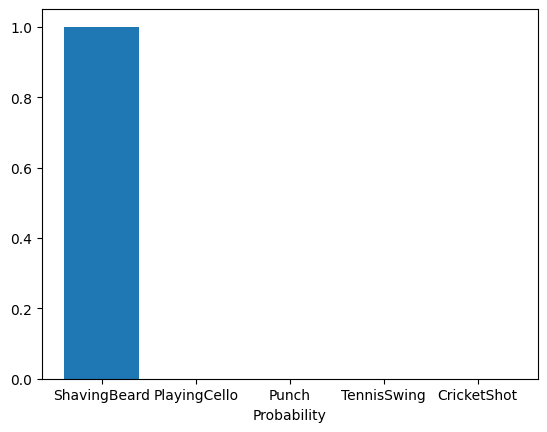

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g02_c06.avi
1/1 [==============================] - 0s 45ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


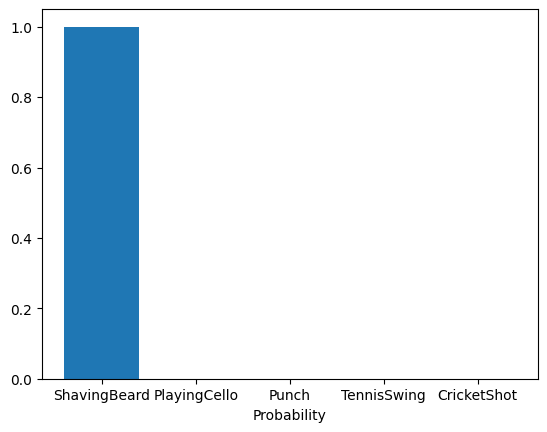

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g02_c07.avi
1/1 [==============================] - 0s 36ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


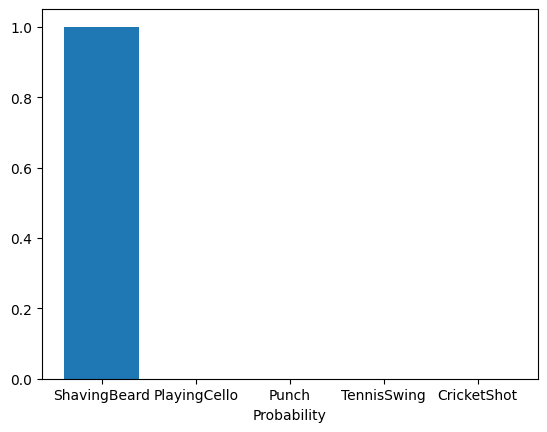

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g03_c01.avi
1/1 [==============================] - 0s 47ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


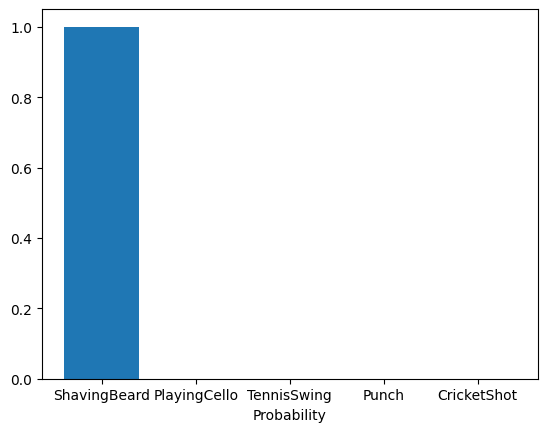

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g03_c02.avi
1/1 [==============================] - 0s 37ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


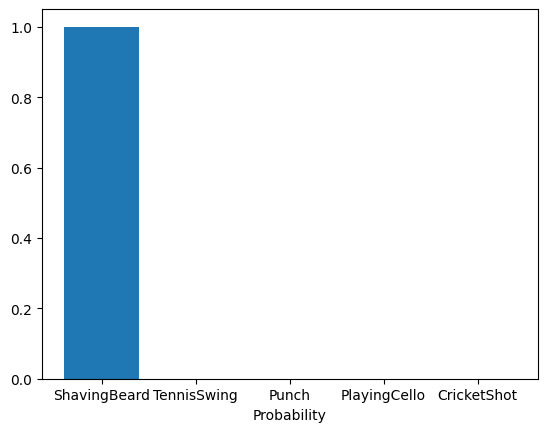

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g03_c03.avi
1/1 [==============================] - 0s 33ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


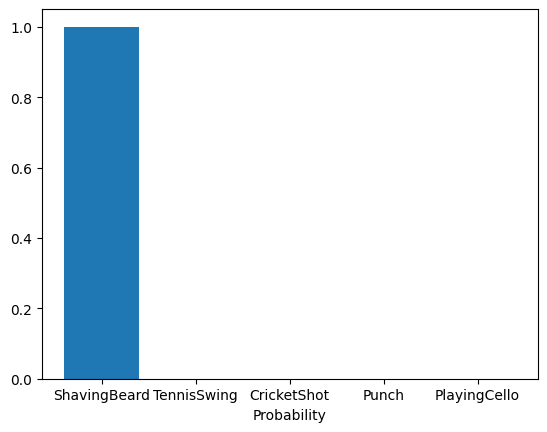

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g03_c04.avi
1/1 [==============================] - 0s 31ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%
  PlayingCello:  0.00%


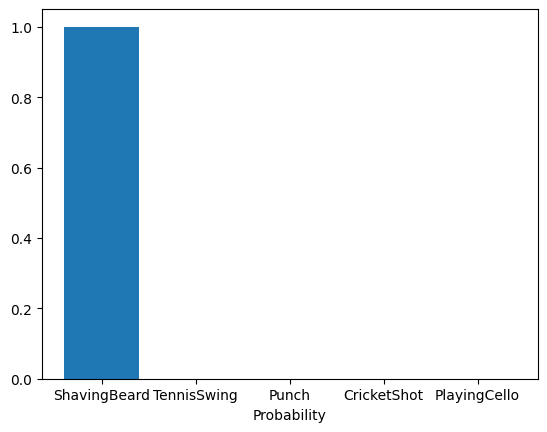

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g03_c05.avi
1/1 [==============================] - 0s 41ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


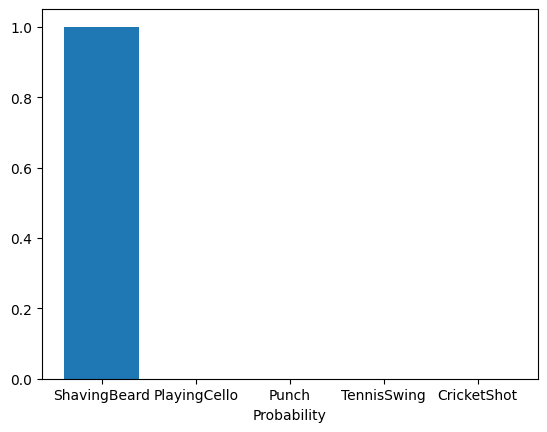

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g03_c06.avi
1/1 [==============================] - 0s 45ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


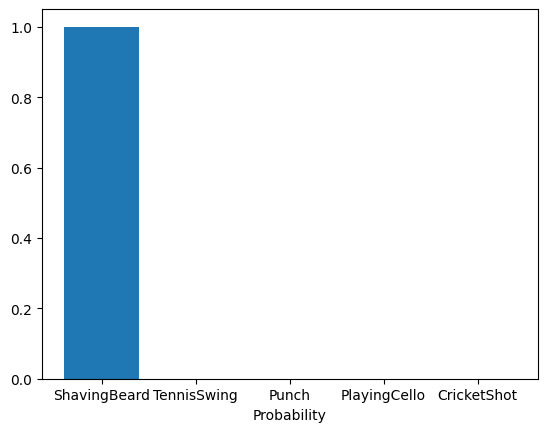

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g03_c07.avi
1/1 [==============================] - 0s 31ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%
  Punch:  0.00%


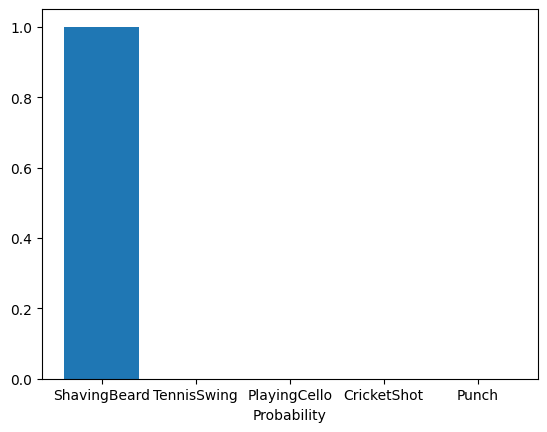

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g04_c01.avi
1/1 [==============================] - 0s 69ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


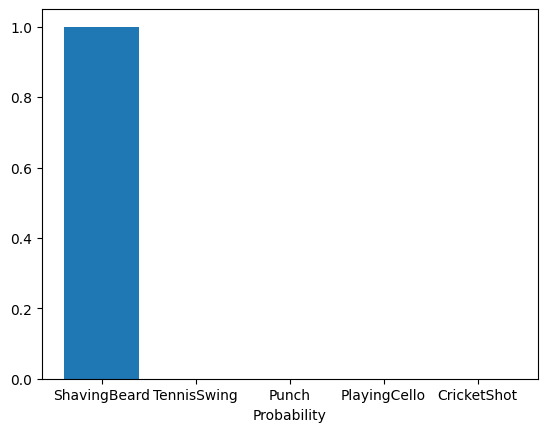

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g04_c02.avi
1/1 [==============================] - 0s 37ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


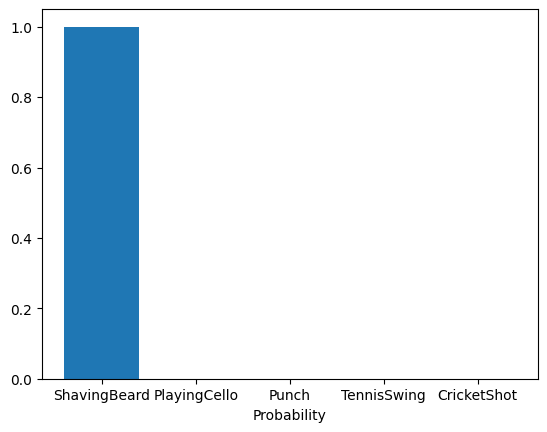

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g04_c03.avi
1/1 [==============================] - 0s 33ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%
  Punch:  0.00%


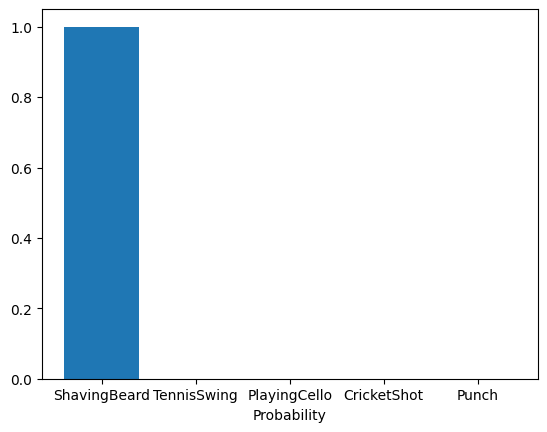

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g04_c04.avi
1/1 [==============================] - 0s 34ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


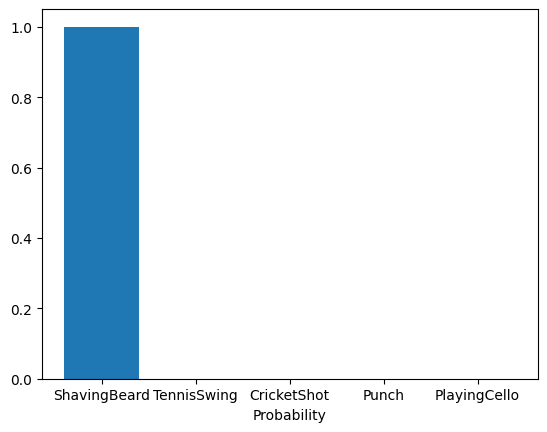

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g05_c01.avi
1/1 [==============================] - 0s 52ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


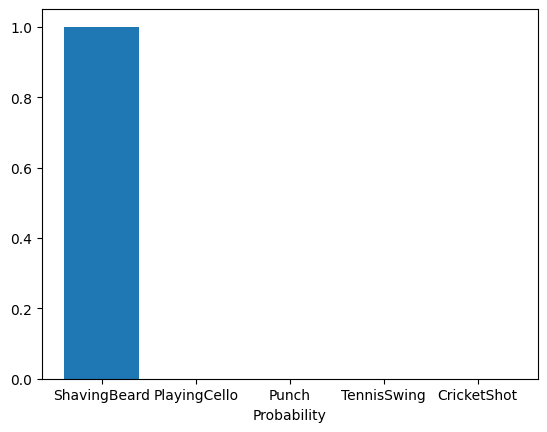

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g05_c02.avi
1/1 [==============================] - 0s 29ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%


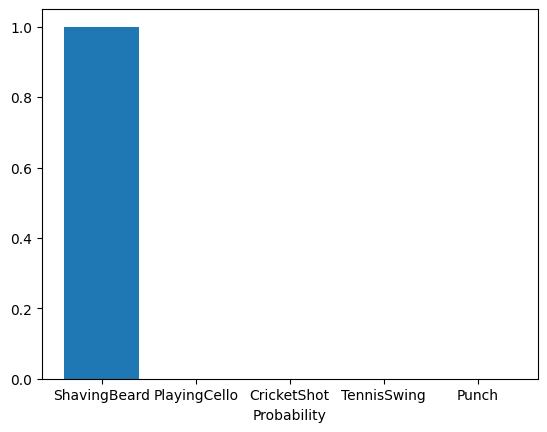

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g05_c03.avi
1/1 [==============================] - 0s 29ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


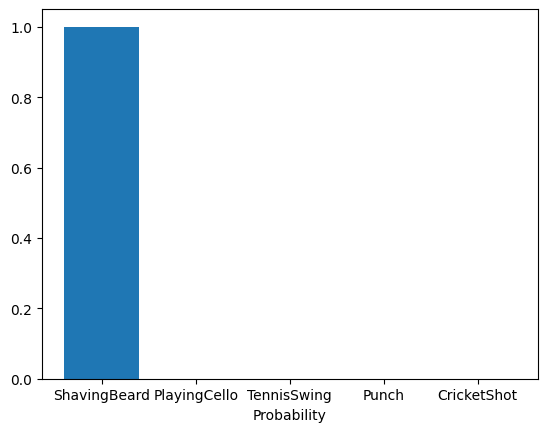

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g05_c04.avi
1/1 [==============================] - 0s 45ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


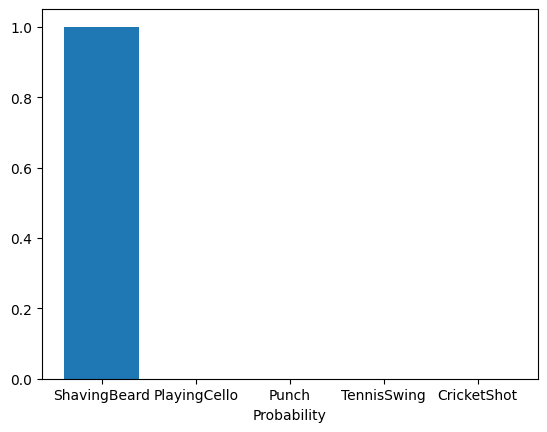

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g05_c05.avi
1/1 [==============================] - 0s 36ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


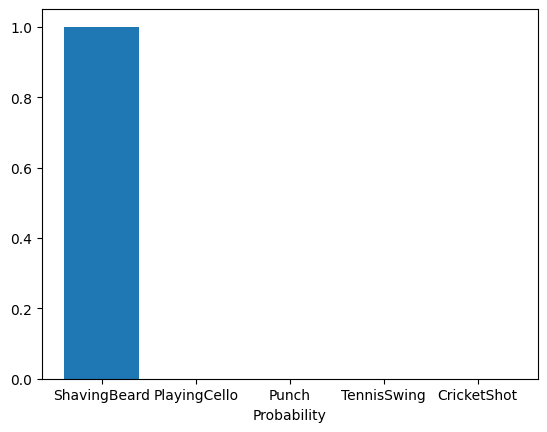

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g05_c06.avi
1/1 [==============================] - 0s 38ms/step
  ShavingBeard: 100.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


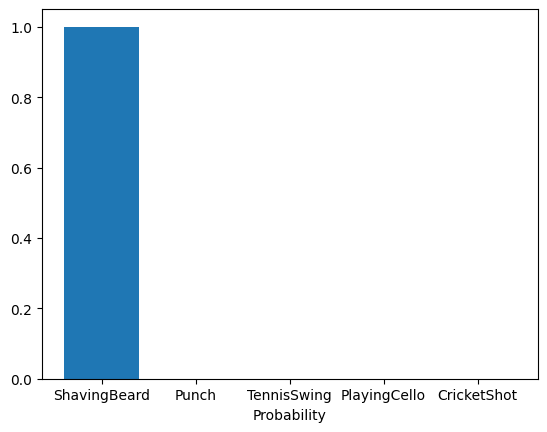

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g05_c07.avi
1/1 [==============================] - 0s 44ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


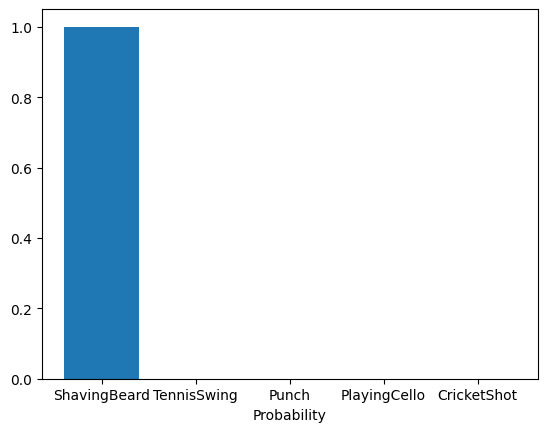

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g06_c01.avi
1/1 [==============================] - 0s 35ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


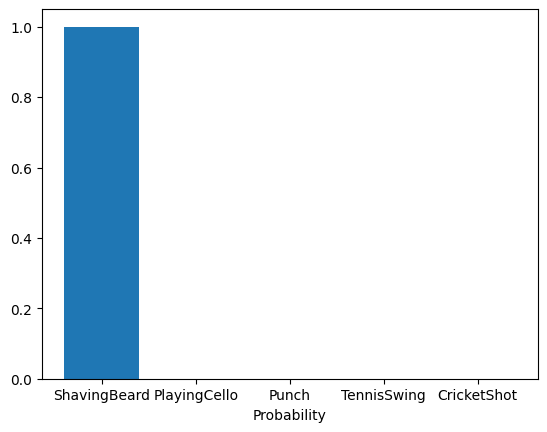

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g06_c02.avi
1/1 [==============================] - 0s 40ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


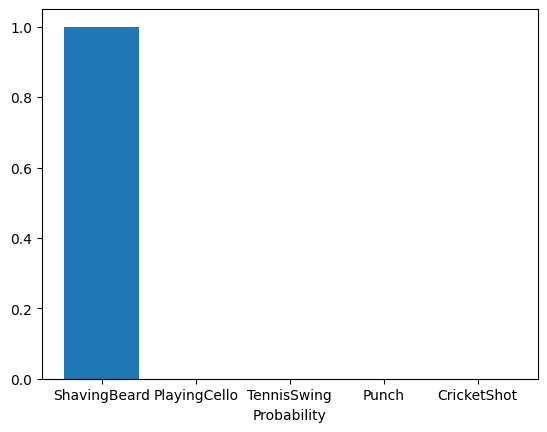

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g06_c03.avi
1/1 [==============================] - 0s 35ms/step
  ShavingBeard: 100.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


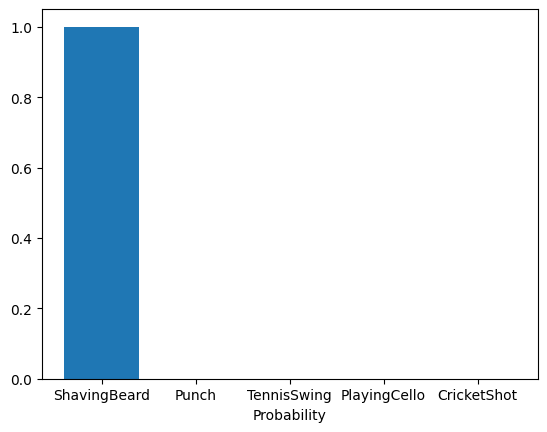

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g06_c04.avi
1/1 [==============================] - 0s 38ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


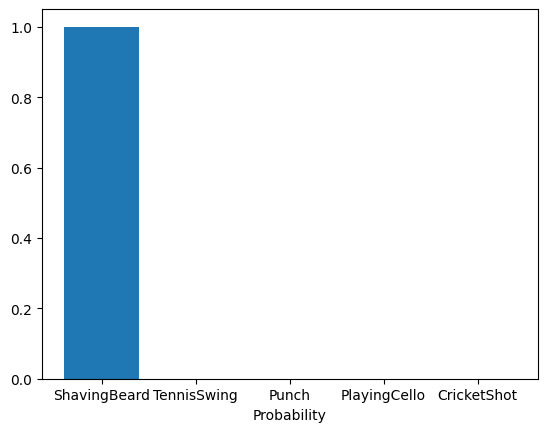

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g06_c05.avi
1/1 [==============================] - 0s 41ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


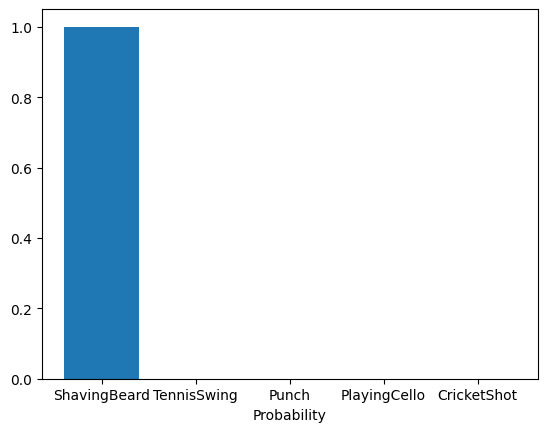

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g06_c06.avi
1/1 [==============================] - 0s 41ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%


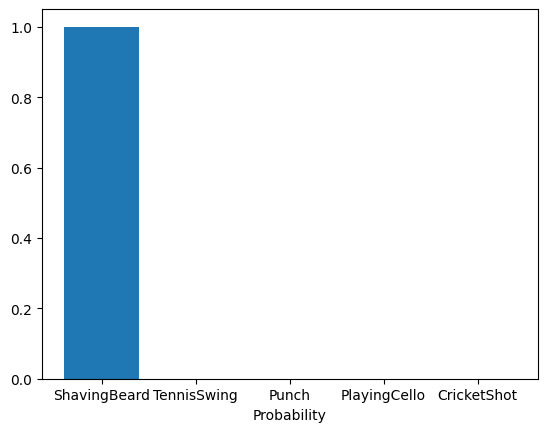

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g06_c07.avi
1/1 [==============================] - 0s 34ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


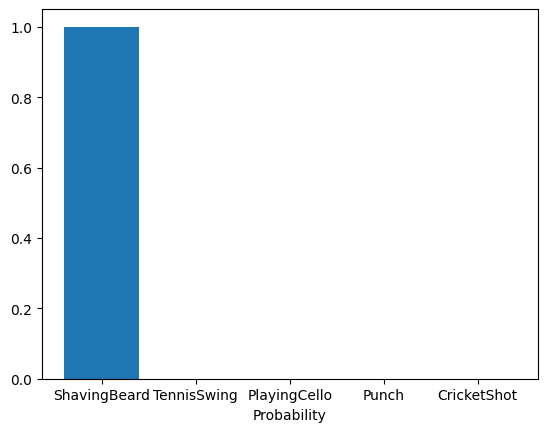

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g07_c01.avi
1/1 [==============================] - 0s 42ms/step
  ShavingBeard: 99.99%
  PlayingCello:  0.01%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


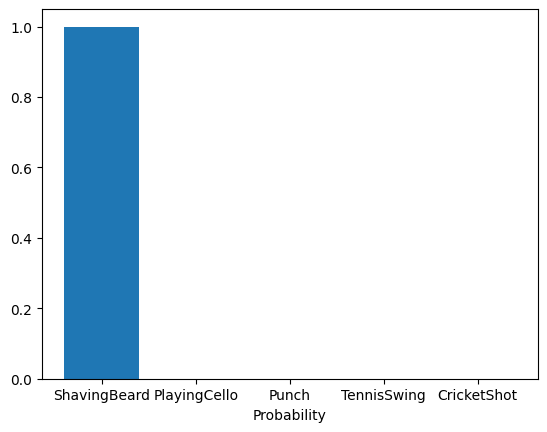

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g07_c02.avi
1/1 [==============================] - 0s 44ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


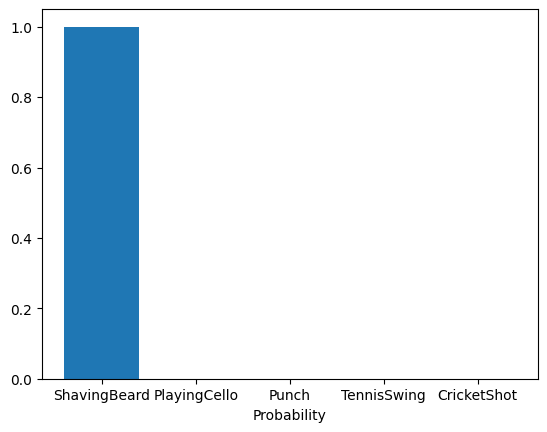

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g07_c03.avi
1/1 [==============================] - 0s 37ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


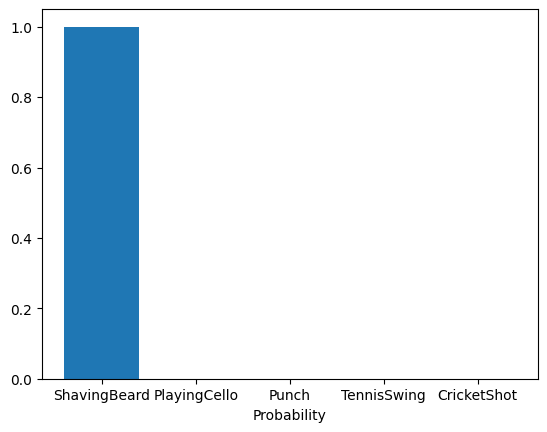

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g07_c04.avi
1/1 [==============================] - 0s 53ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


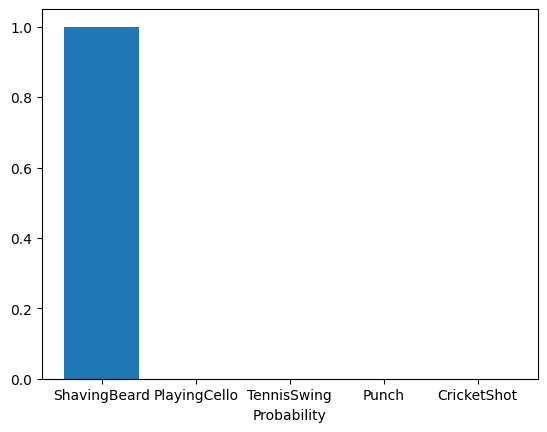

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g07_c05.avi
1/1 [==============================] - 0s 32ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


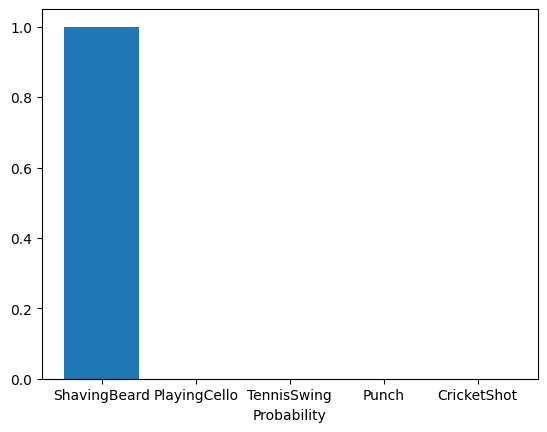

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g07_c06.avi
1/1 [==============================] - 0s 42ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  Punch:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


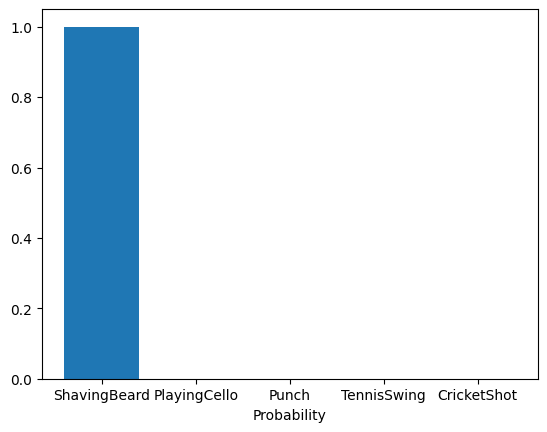

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_ShavingBeard_g07_c07.avi
1/1 [==============================] - 0s 43ms/step
  ShavingBeard: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  Punch:  0.00%
  CricketShot:  0.00%


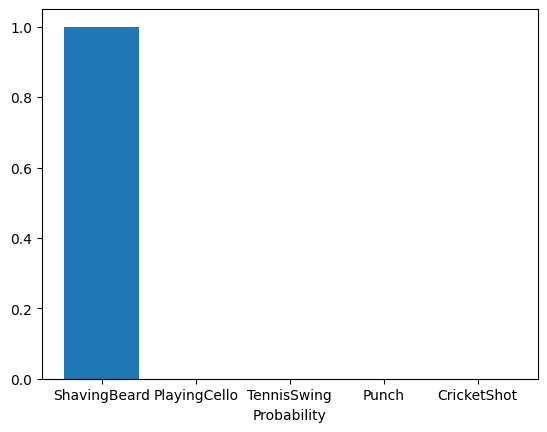

Ground truth: ShavingBeard
Predicted label: ShavingBeard


Test video path: v_TennisSwing_g01_c01.avi
1/1 [==============================] - 0s 40ms/step
  TennisSwing: 81.39%
  CricketShot: 18.61%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


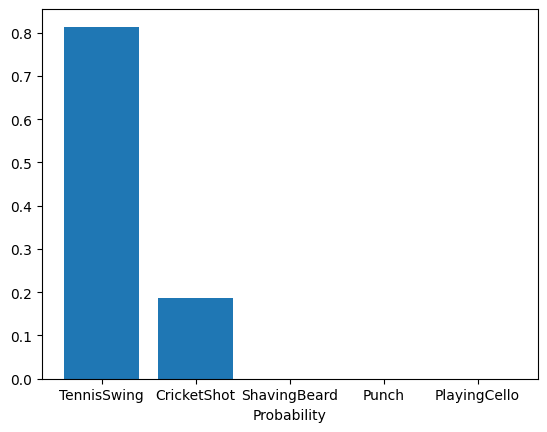

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g01_c02.avi
1/1 [==============================] - 0s 42ms/step
  TennisSwing: 91.22%
  CricketShot:  8.76%
  ShavingBeard:  0.02%
  Punch:  0.00%
  PlayingCello:  0.00%


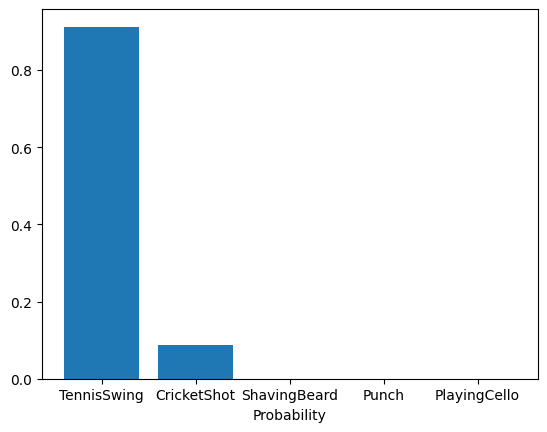

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g01_c03.avi
1/1 [==============================] - 0s 58ms/step
  TennisSwing: 90.50%
  CricketShot:  9.38%
  ShavingBeard:  0.12%
  Punch:  0.01%
  PlayingCello:  0.00%


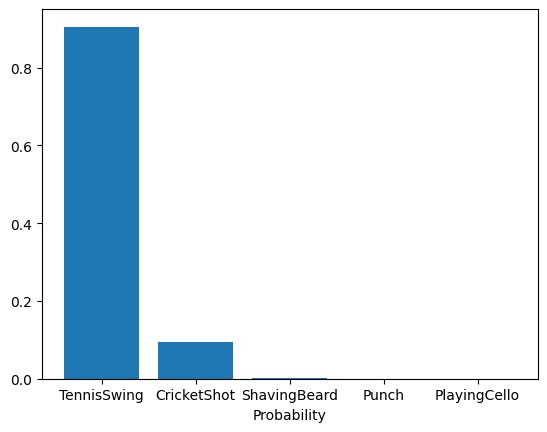

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g01_c04.avi
1/1 [==============================] - 0s 34ms/step
  TennisSwing: 87.30%
  CricketShot: 12.63%
  ShavingBeard:  0.06%
  Punch:  0.00%
  PlayingCello:  0.00%


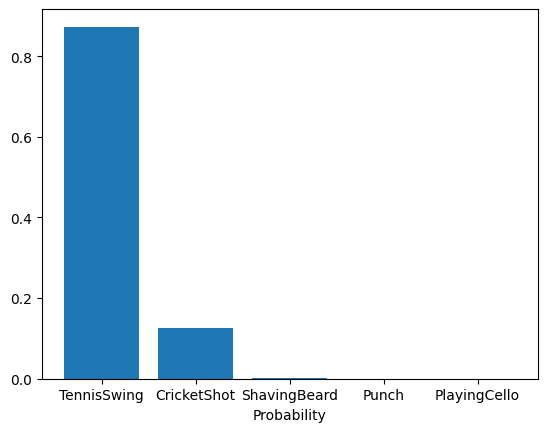

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g01_c05.avi
1/1 [==============================] - 0s 38ms/step
  TennisSwing: 94.91%
  CricketShot:  4.99%
  ShavingBeard:  0.09%
  Punch:  0.01%
  PlayingCello:  0.00%


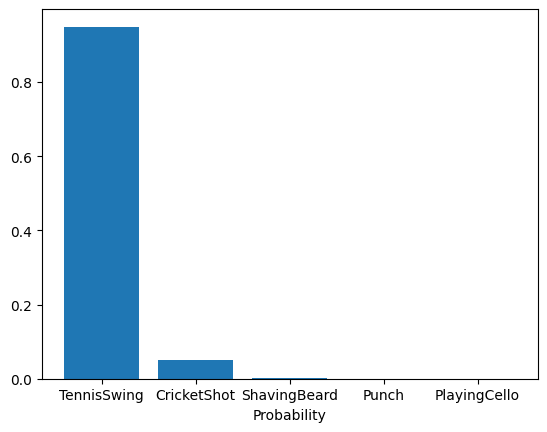

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g01_c06.avi
1/1 [==============================] - 0s 35ms/step
  TennisSwing: 93.18%
  CricketShot:  6.69%
  ShavingBeard:  0.13%
  Punch:  0.01%
  PlayingCello:  0.00%


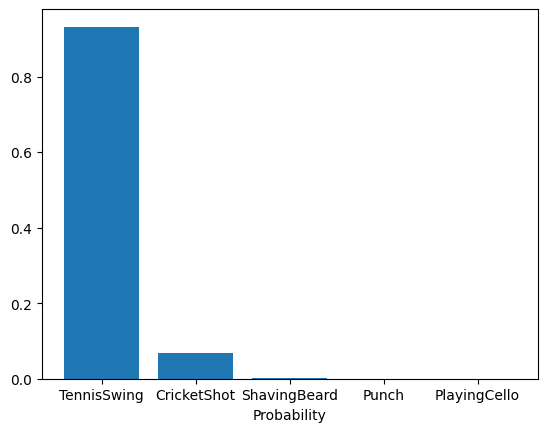

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g01_c07.avi
1/1 [==============================] - 0s 38ms/step
  TennisSwing: 91.62%
  CricketShot:  8.37%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


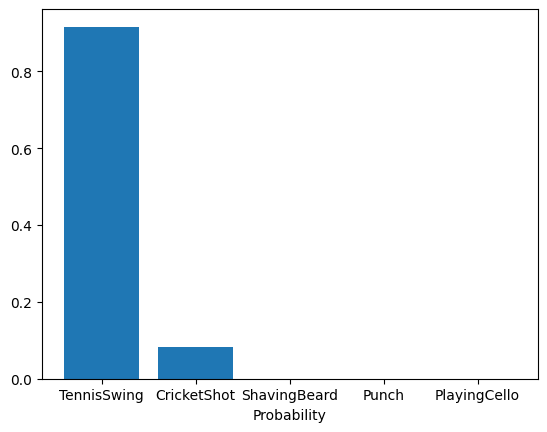

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g02_c01.avi
1/1 [==============================] - 0s 76ms/step
  TennisSwing: 83.69%
  ShavingBeard:  6.44%
  CricketShot:  4.97%
  Punch:  2.98%
  PlayingCello:  1.93%


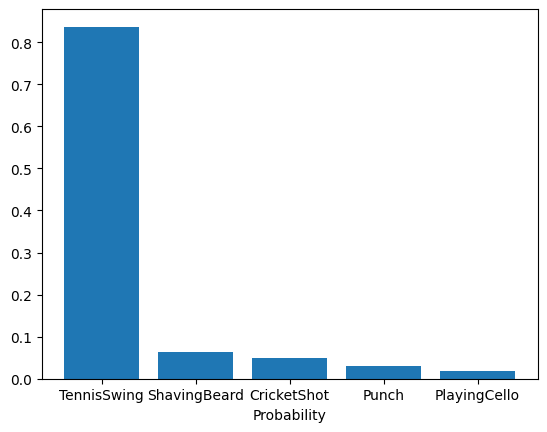

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g02_c02.avi
1/1 [==============================] - 0s 30ms/step
  TennisSwing: 80.31%
  ShavingBeard: 14.31%
  CricketShot:  4.16%
  PlayingCello:  0.79%
  Punch:  0.43%


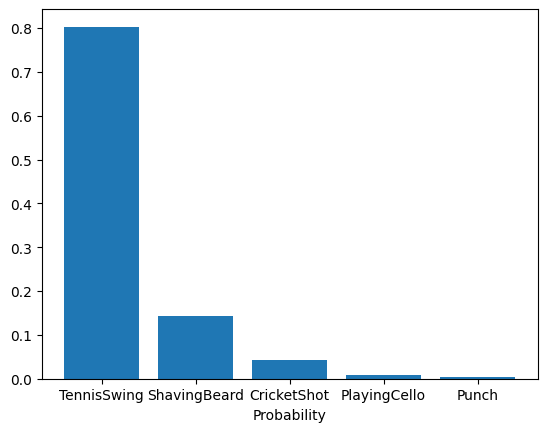

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g02_c03.avi
1/1 [==============================] - 0s 31ms/step
  PlayingCello: 57.54%
  TennisSwing: 39.66%
  ShavingBeard:  1.84%
  Punch:  0.50%
  CricketShot:  0.46%


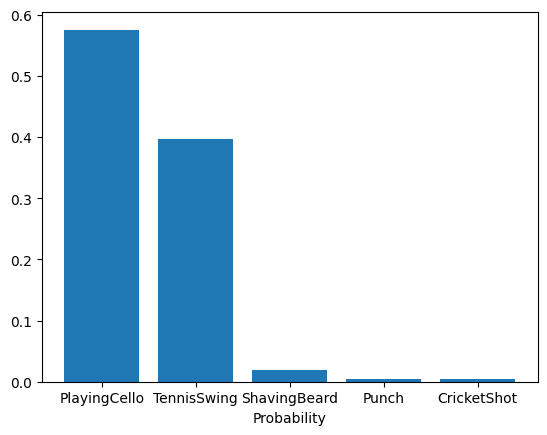

Ground truth: TennisSwing
Predicted label: PlayingCello


Test video path: v_TennisSwing_g02_c04.avi
1/1 [==============================] - 0s 47ms/step
  TennisSwing: 78.02%
  CricketShot:  8.84%
  ShavingBeard:  7.38%
  PlayingCello:  4.11%
  Punch:  1.65%


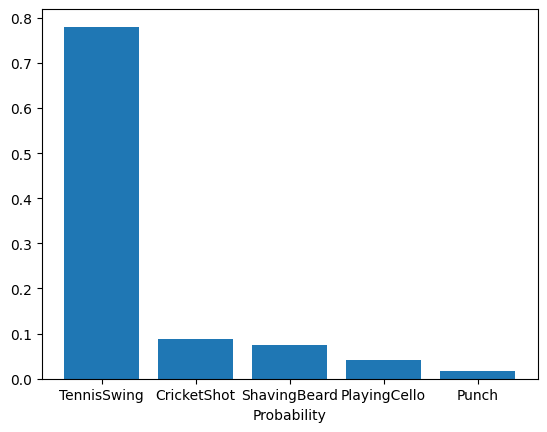

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g02_c05.avi
1/1 [==============================] - 0s 32ms/step
  TennisSwing: 79.70%
  CricketShot: 18.04%
  ShavingBeard:  1.56%
  Punch:  0.45%
  PlayingCello:  0.24%


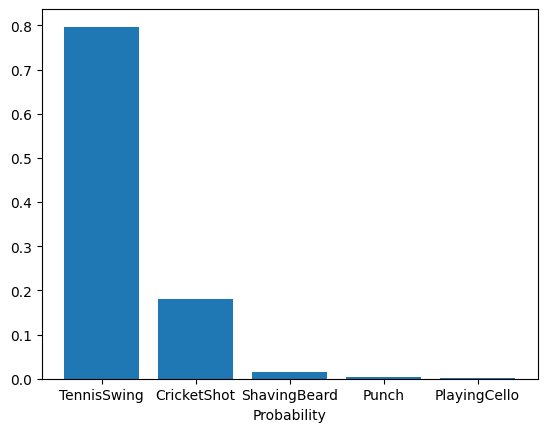

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g02_c06.avi
1/1 [==============================] - 0s 67ms/step
  TennisSwing: 56.02%
  ShavingBeard: 22.80%
  PlayingCello: 11.05%
  CricketShot:  6.38%
  Punch:  3.75%


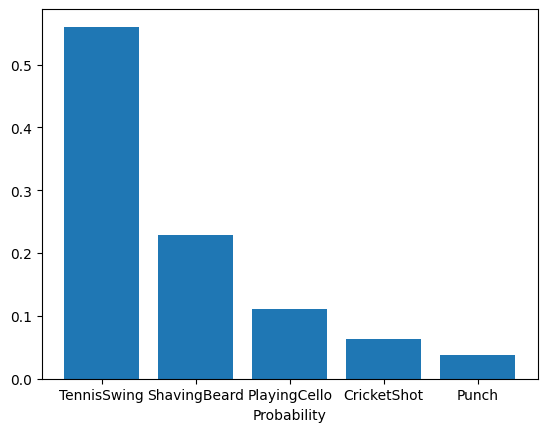

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g02_c07.avi
1/1 [==============================] - 0s 42ms/step
  PlayingCello: 54.92%
  TennisSwing: 37.75%
  ShavingBeard:  4.05%
  Punch:  2.42%
  CricketShot:  0.87%


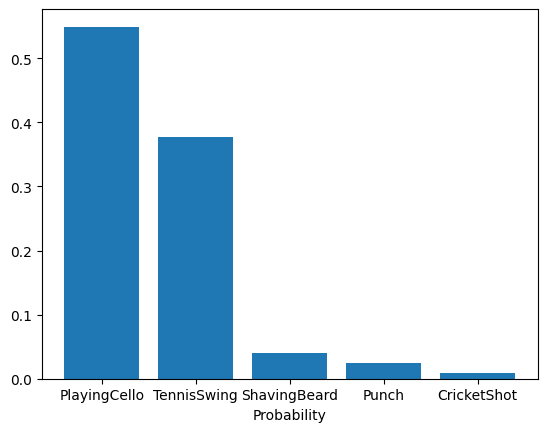

Ground truth: TennisSwing
Predicted label: PlayingCello


Test video path: v_TennisSwing_g03_c01.avi
1/1 [==============================] - 0s 43ms/step
  TennisSwing: 90.45%
  CricketShot:  9.50%
  ShavingBeard:  0.04%
  Punch:  0.01%
  PlayingCello:  0.00%


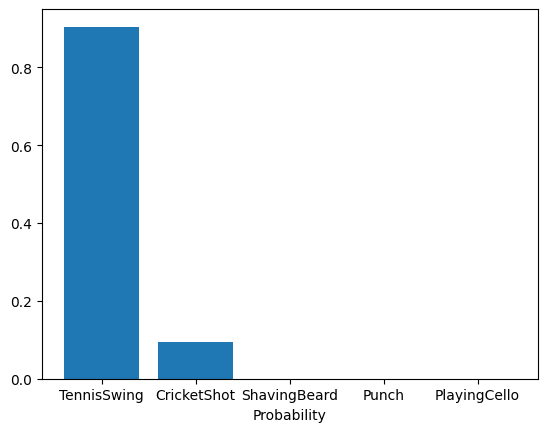

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g03_c02.avi
1/1 [==============================] - 0s 32ms/step
  TennisSwing: 90.42%
  CricketShot:  8.46%
  ShavingBeard:  1.00%
  Punch:  0.09%
  PlayingCello:  0.03%


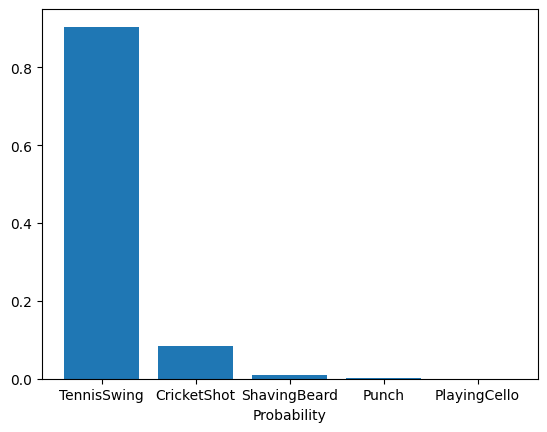

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g03_c03.avi
1/1 [==============================] - 0s 46ms/step
  TennisSwing: 93.67%
  CricketShot:  6.29%
  ShavingBeard:  0.03%
  Punch:  0.01%
  PlayingCello:  0.00%


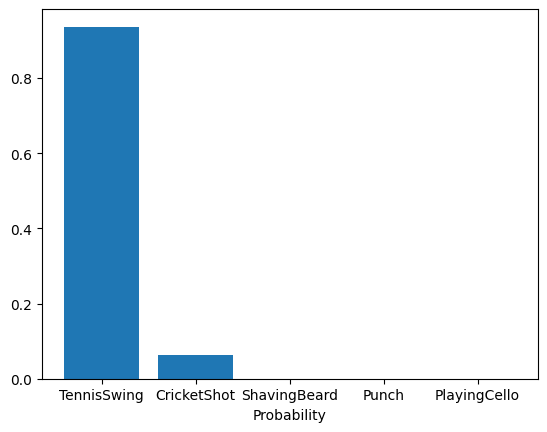

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g03_c04.avi
1/1 [==============================] - 0s 31ms/step
  TennisSwing: 76.94%
  CricketShot: 22.40%
  ShavingBeard:  0.61%
  Punch:  0.05%
  PlayingCello:  0.00%


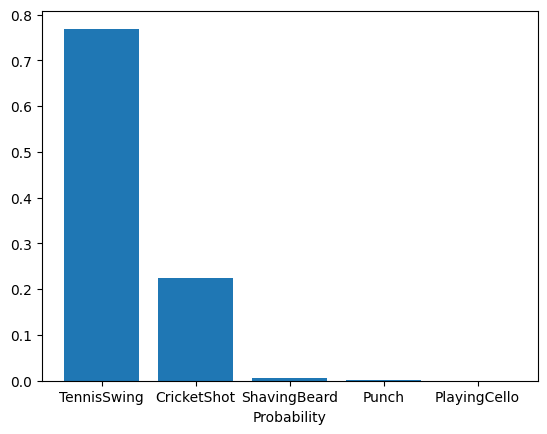

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g03_c05.avi
1/1 [==============================] - 0s 40ms/step
  TennisSwing: 91.18%
  CricketShot:  8.71%
  ShavingBeard:  0.09%
  Punch:  0.01%
  PlayingCello:  0.00%


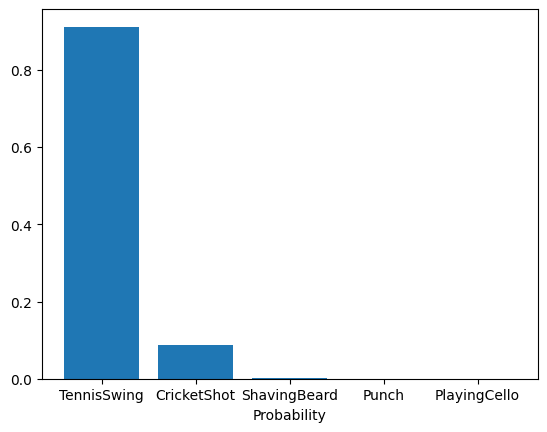

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g03_c06.avi
1/1 [==============================] - 0s 75ms/step
  TennisSwing: 84.70%
  CricketShot: 15.11%
  ShavingBeard:  0.18%
  PlayingCello:  0.00%
  Punch:  0.00%


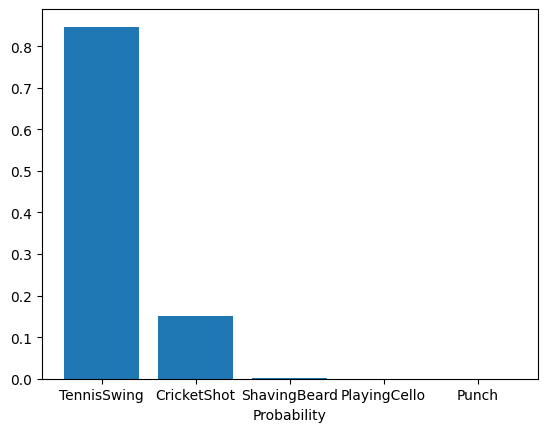

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g03_c07.avi
1/1 [==============================] - 0s 54ms/step
  TennisSwing: 83.80%
  CricketShot: 15.62%
  ShavingBeard:  0.53%
  Punch:  0.02%
  PlayingCello:  0.02%


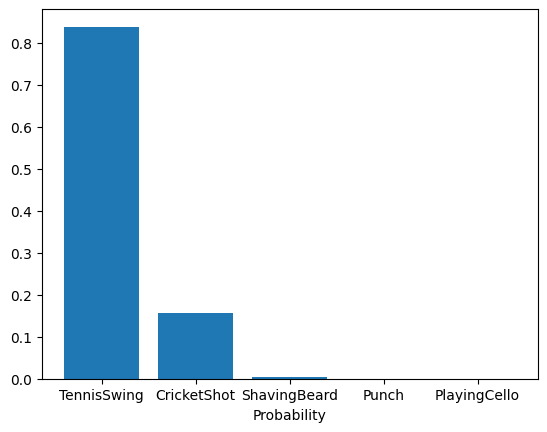

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g04_c01.avi
1/1 [==============================] - 0s 62ms/step
  TennisSwing: 92.10%
  CricketShot:  7.89%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


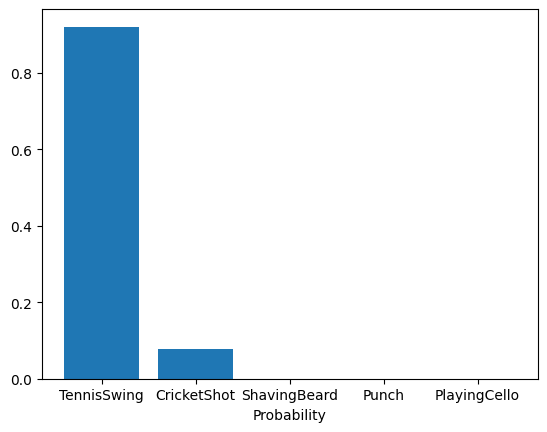

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g04_c02.avi
1/1 [==============================] - 0s 52ms/step
  TennisSwing: 58.25%
  CricketShot: 41.74%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


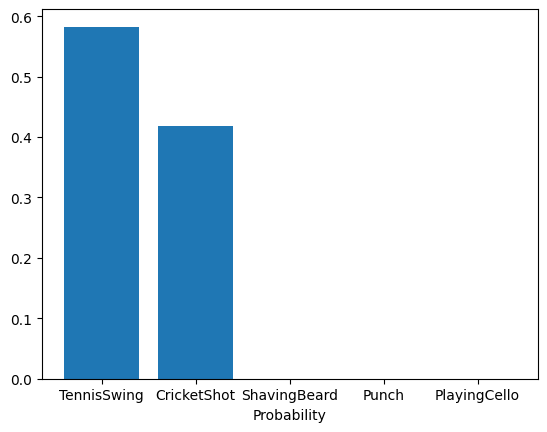

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g04_c03.avi
1/1 [==============================] - 0s 35ms/step
  TennisSwing: 90.00%
  CricketShot: 10.00%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


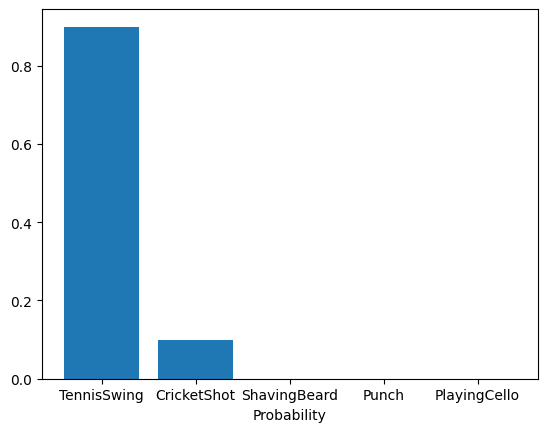

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g04_c04.avi
1/1 [==============================] - 0s 44ms/step
  TennisSwing: 80.84%
  CricketShot: 19.16%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


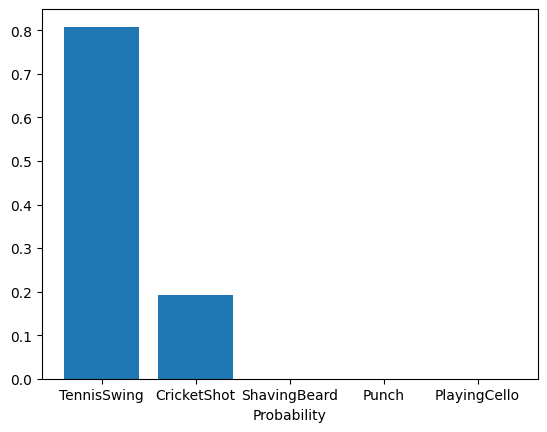

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g04_c05.avi
1/1 [==============================] - 0s 37ms/step
  TennisSwing: 78.65%
  CricketShot: 21.34%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


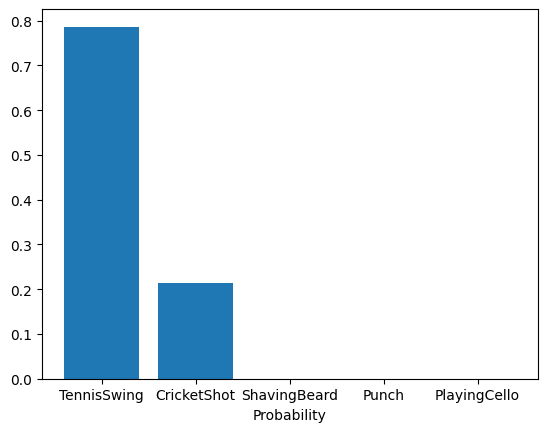

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g04_c06.avi
1/1 [==============================] - 0s 63ms/step
  TennisSwing: 85.48%
  CricketShot: 14.51%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


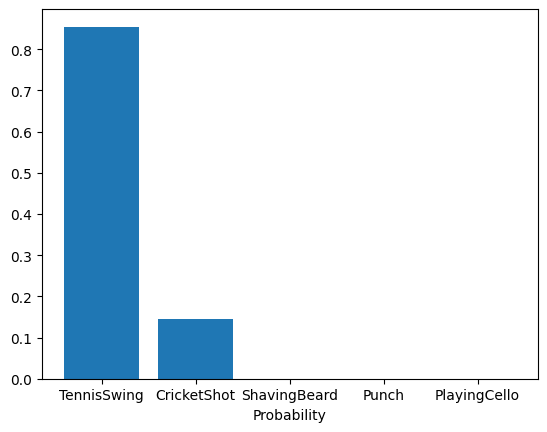

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g04_c07.avi
1/1 [==============================] - 0s 51ms/step
  TennisSwing: 83.66%
  CricketShot: 16.34%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


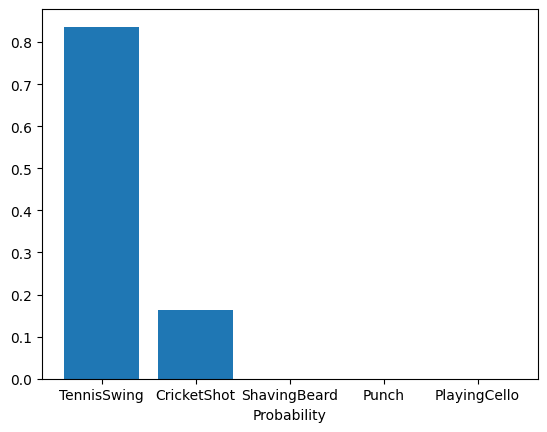

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g05_c01.avi
1/1 [==============================] - 0s 32ms/step
  TennisSwing: 51.34%
  CricketShot: 48.66%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


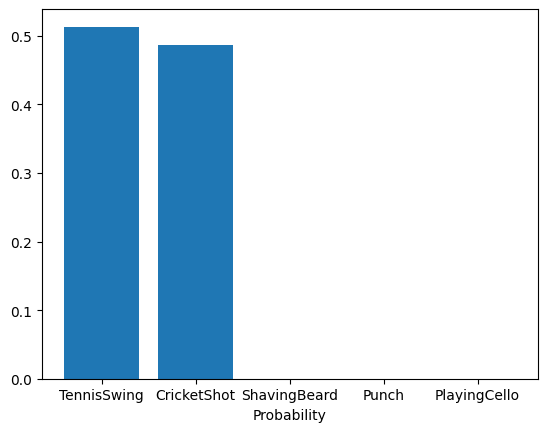

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g05_c02.avi
1/1 [==============================] - 0s 43ms/step
  CricketShot: 58.98%
  TennisSwing: 41.02%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


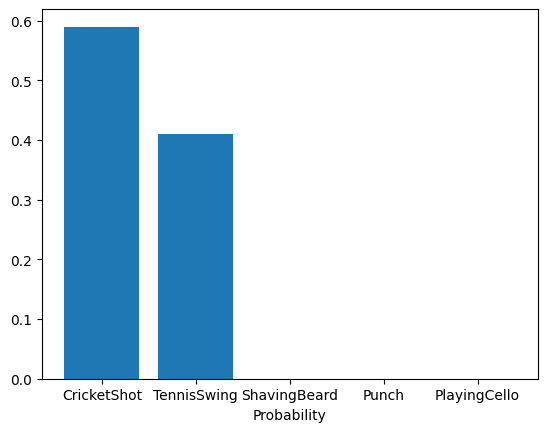

Ground truth: TennisSwing
Predicted label: CricketShot


Test video path: v_TennisSwing_g05_c03.avi
1/1 [==============================] - 0s 35ms/step
  CricketShot: 64.98%
  TennisSwing: 29.45%
  ShavingBeard:  5.30%
  Punch:  0.24%
  PlayingCello:  0.03%


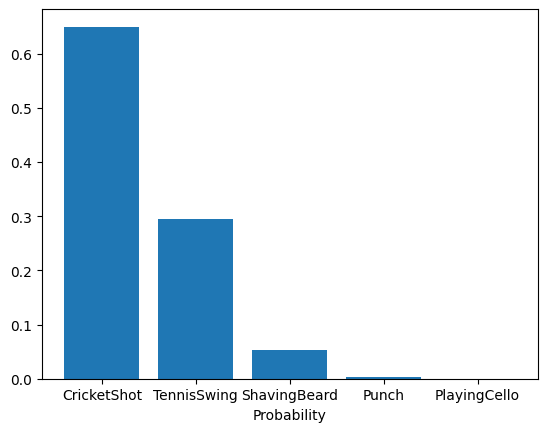

Ground truth: TennisSwing
Predicted label: CricketShot


Test video path: v_TennisSwing_g05_c04.avi
1/1 [==============================] - 0s 31ms/step
  TennisSwing: 83.96%
  CricketShot: 15.96%
  ShavingBeard:  0.07%
  Punch:  0.01%
  PlayingCello:  0.00%


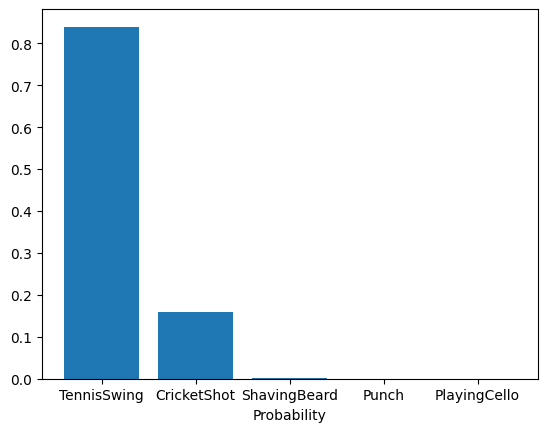

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g05_c05.avi
1/1 [==============================] - 0s 36ms/step
  TennisSwing: 91.05%
  CricketShot:  8.95%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


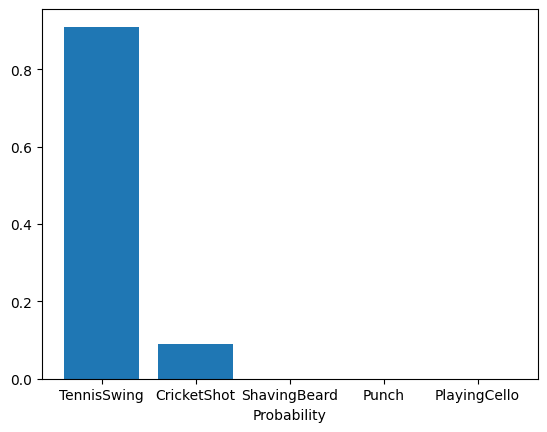

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g05_c06.avi
1/1 [==============================] - 0s 32ms/step
  TennisSwing: 80.92%
  CricketShot: 19.08%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


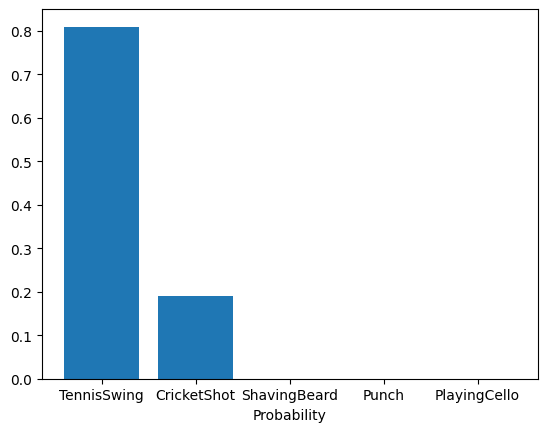

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g05_c07.avi
1/1 [==============================] - 0s 45ms/step
  TennisSwing: 63.72%
  CricketShot: 36.28%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


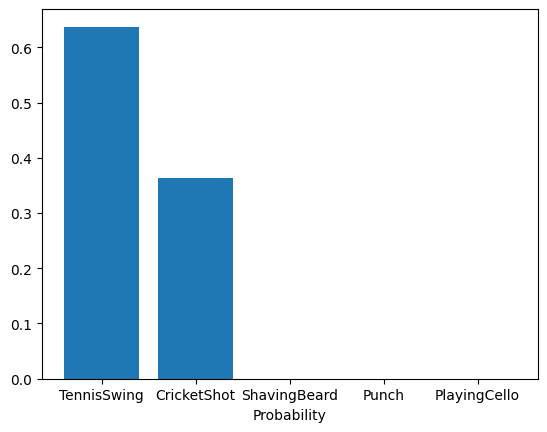

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g06_c01.avi
1/1 [==============================] - 0s 74ms/step
  TennisSwing: 52.85%
  CricketShot: 47.14%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


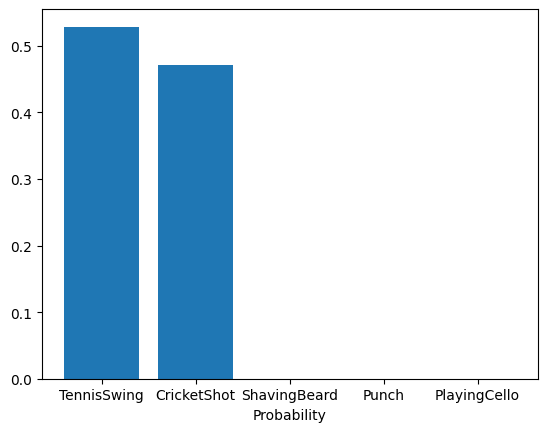

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g06_c02.avi
1/1 [==============================] - 0s 31ms/step
  TennisSwing: 80.48%
  CricketShot: 19.51%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


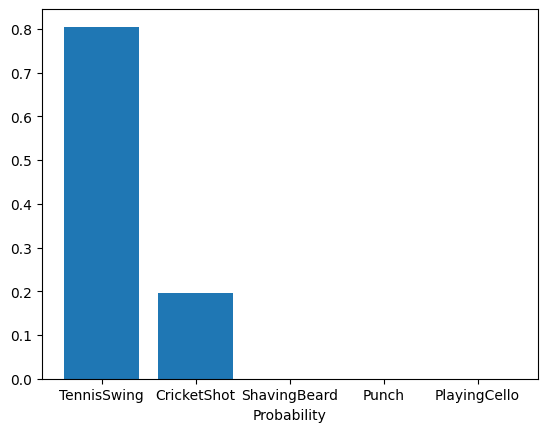

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g06_c03.avi
1/1 [==============================] - 0s 67ms/step
  TennisSwing: 88.08%
  CricketShot: 11.91%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


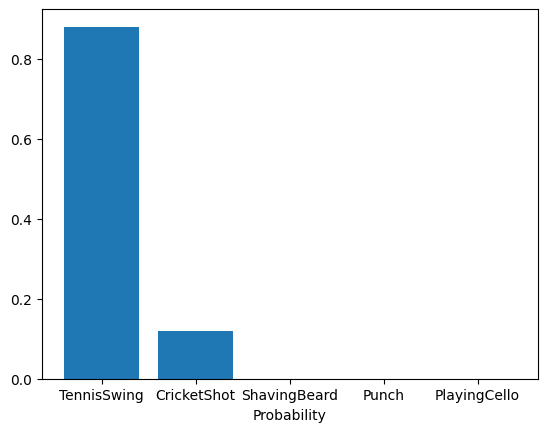

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g06_c04.avi
1/1 [==============================] - 0s 45ms/step
  TennisSwing: 87.79%
  CricketShot: 12.19%
  ShavingBeard:  0.02%
  Punch:  0.00%
  PlayingCello:  0.00%


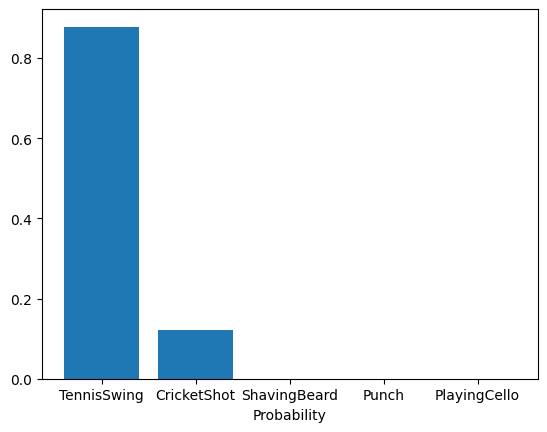

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g06_c05.avi
1/1 [==============================] - 0s 53ms/step
  TennisSwing: 85.26%
  CricketShot: 14.74%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


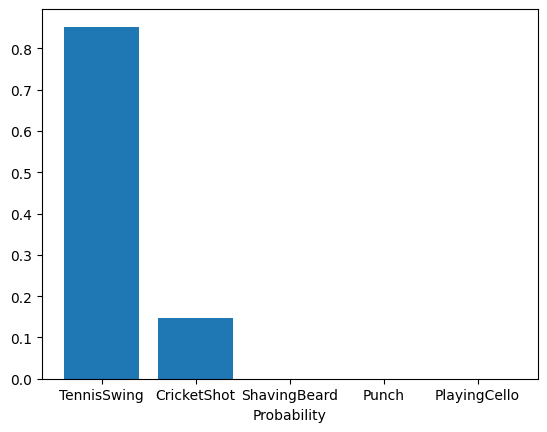

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g06_c06.avi
1/1 [==============================] - 0s 47ms/step
  TennisSwing: 85.44%
  CricketShot: 14.55%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


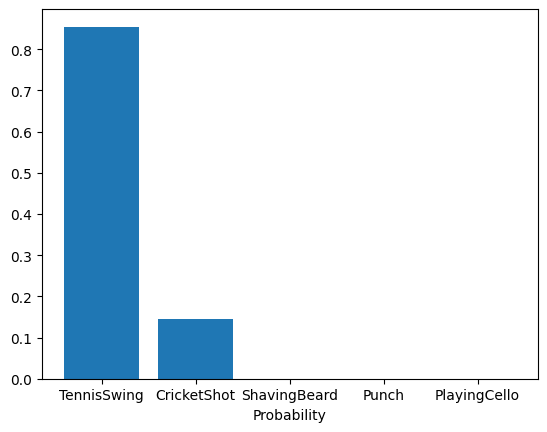

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g06_c07.avi
1/1 [==============================] - 0s 61ms/step
  TennisSwing: 84.17%
  CricketShot: 15.83%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


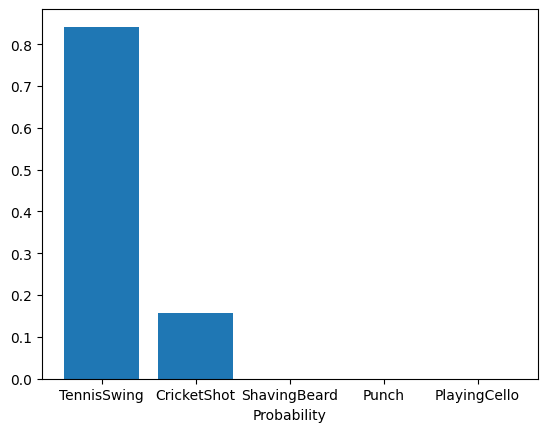

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g07_c01.avi
1/1 [==============================] - 0s 31ms/step
  CricketShot: 82.25%
  PlayingCello:  8.26%
  ShavingBeard:  7.22%
  TennisSwing:  1.50%
  Punch:  0.77%


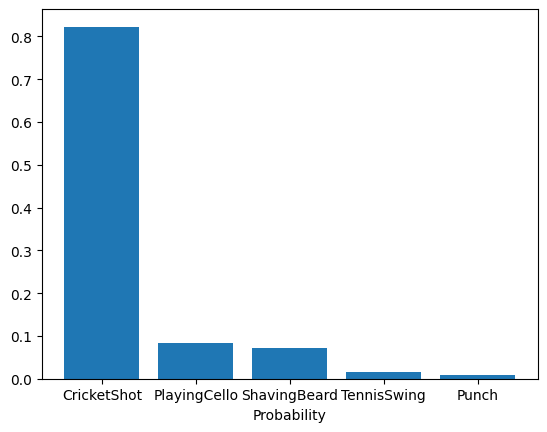

Ground truth: TennisSwing
Predicted label: CricketShot


Test video path: v_TennisSwing_g07_c02.avi
1/1 [==============================] - 0s 100ms/step
  CricketShot: 53.92%
  TennisSwing: 44.98%
  ShavingBeard:  1.00%
  Punch:  0.06%
  PlayingCello:  0.05%


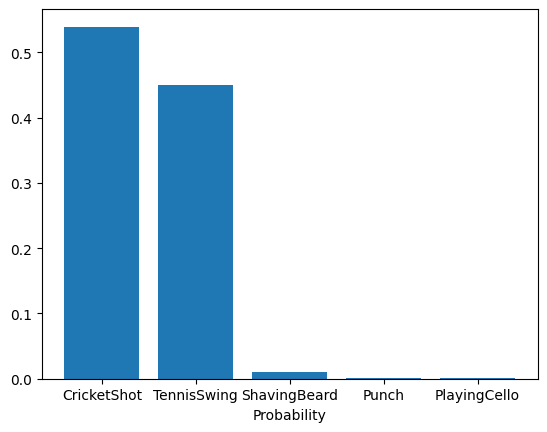

Ground truth: TennisSwing
Predicted label: CricketShot


Test video path: v_TennisSwing_g07_c03.avi
1/1 [==============================] - 0s 52ms/step
  TennisSwing: 62.93%
  CricketShot: 36.01%
  ShavingBeard:  1.05%
  Punch:  0.01%
  PlayingCello:  0.00%


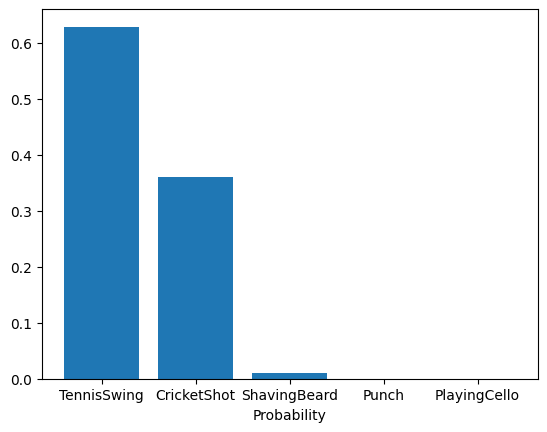

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g07_c04.avi
1/1 [==============================] - 0s 31ms/step
  CricketShot: 68.13%
  TennisSwing: 28.62%
  ShavingBeard:  3.22%
  Punch:  0.02%
  PlayingCello:  0.01%


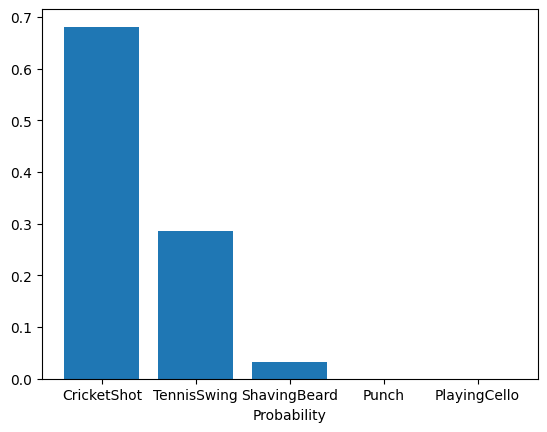

Ground truth: TennisSwing
Predicted label: CricketShot


Test video path: v_TennisSwing_g07_c05.avi
1/1 [==============================] - 0s 42ms/step
  TennisSwing: 76.06%
  CricketShot: 23.63%
  ShavingBeard:  0.28%
  Punch:  0.03%
  PlayingCello:  0.01%


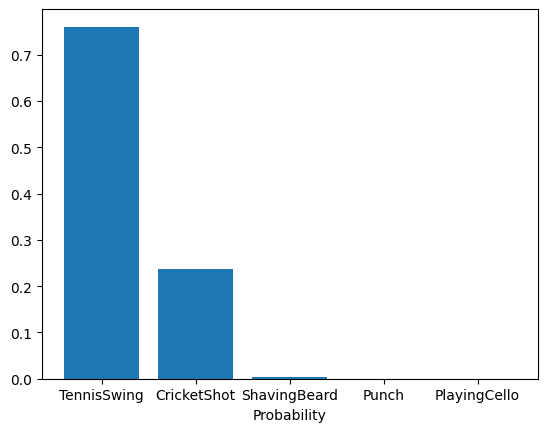

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g07_c06.avi
1/1 [==============================] - 0s 43ms/step
  TennisSwing: 65.68%
  CricketShot: 25.43%
  ShavingBeard:  8.56%
  PlayingCello:  0.25%
  Punch:  0.07%


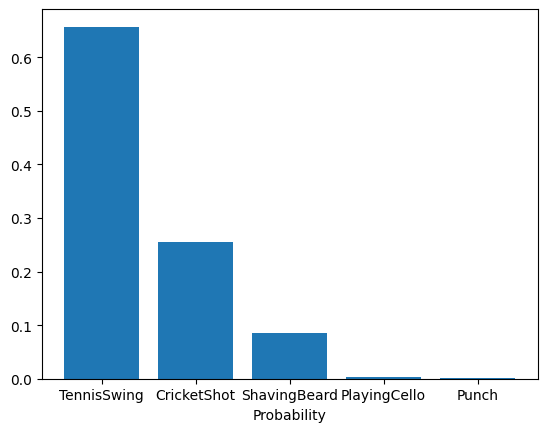

Ground truth: TennisSwing
Predicted label: TennisSwing


Test video path: v_TennisSwing_g07_c07.avi
1/1 [==============================] - 0s 74ms/step
  TennisSwing: 76.21%
  CricketShot: 23.59%
  ShavingBeard:  0.16%
  Punch:  0.03%
  PlayingCello:  0.02%


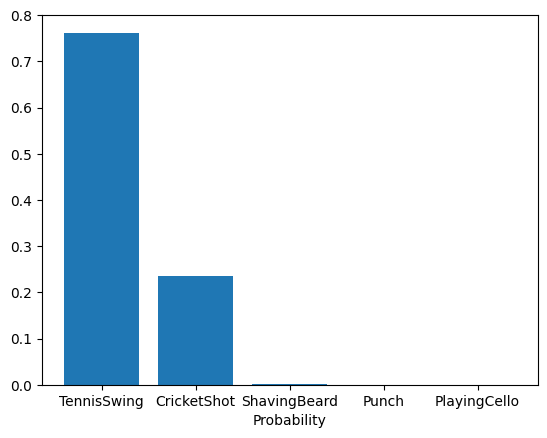

Ground truth: TennisSwing
Predicted label: TennisSwing




In [128]:
def infer_all_videos(test_df):
    predictions = []
    probabilites= []
    for _, row in test_df.iterrows():
        video_path = row['video_name']
        true_label = row['tag']
        print(f"Test video path: {video_path}")

        pred_label, _ = predict_action(video_path)
        predictions.append((true_label, pred_label))
        probabilites.append(probs)

        print("Ground truth:", true_label)
        print("Predicted label:", pred_label)
        print("\n")

    return predictions,probabilites

# Call the function to infer all videos
all_predictions ,all_probabilites = infer_all_videos(test_df)


In [131]:
y_true_all, y_pred_all = zip(*all_predictions)
class_vocab=label_processor.get_vocabulary()
print(all_probabilites)

[array([[[[ 44.,  68.,  26.],
         [ 35.,  59.,  17.],
         [ 33.,  58.,  13.],
         ...,
         [108., 137.,  84.],
         [108., 137.,  84.],
         [108., 137.,  84.]],

        [[ 47.,  71.,  29.],
         [ 45.,  69.,  27.],
         [ 49.,  74.,  29.],
         ...,
         [108., 137.,  84.],
         [108., 137.,  84.],
         [108., 137.,  84.]],

        [[ 46.,  70.,  28.],
         [ 54.,  78.,  36.],
         [ 69.,  94.,  49.],
         ...,
         [108., 137.,  84.],
         [108., 137.,  84.],
         [108., 137.,  84.]],

        ...,

        [[ 82., 130.,  61.],
         [ 82., 130.,  61.],
         [ 85., 130.,  62.],
         ...,
         [ 90., 129.,  66.],
         [ 90., 129.,  66.],
         [ 90., 129.,  66.]],

        [[ 79., 127.,  58.],
         [ 81., 129.,  60.],
         [ 84., 129.,  61.],
         ...,
         [ 90., 129.,  66.],
         [ 90., 129.,  66.],
         [ 90., 129.,  66.]],

        [[ 78., 126.,  57.],
      

In [1]:

def reshape_features(all_features):
    # Combine all features into a single array
    combined_features = np.concatenate(all_features)
    # Reshape the combined features into a 2D array
    reshaped_features = combined_features.reshape(combined_features.shape[0], -1)
    return reshaped_features

def visualize_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    transformed = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed[:, 0], transformed[:, 1], c=labels, cmap='Set1')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(label='Class')
    plt.show()

# Reshape the features
reshaped_features = reshape_features(all_probabilites)

# Assuming y_pred_all contains the predicted labels
# Now you can visualize the features using t-SNE
visualize_tsne(reshaped_features, y_pred_all)


NameError: name 'all_probabilites' is not defined

In [115]:
# 4. Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# 5. Receiver Operating Characteristic (ROC) Curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (AUC={:.2f})'.format(auc))
    plt.show()

# 6. TSNE Visualization
def visualize_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    transformed = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=labels, palette='Set1')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Class')
    plt.show()

# 7. PCA Visualization
def visualize_pca(features, labels):
    pca = PCA(n_components=2, random_state=42)
    transformed = pca.fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=labels, palette='Set1')
    plt.title('PCA Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Class')
    plt.show()

In [140]:
all_probabilities_np = np.array(all_probabilites)

# Now you can pass all_probabilities_np to the visualize_tsne function
visualize_tsne(all_probabilities_np, y_pred_all)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (224,) + inhomogeneous part.

In [122]:
# 1.Loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 2. Training and Validation Accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 3. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# 8. Plot Model Architecture
def plot_model_architecture(model, filepath='model_architecture.png'):
    plot_model(model, to_file=filepath, show_shapes=True, show_layer_names=True)

In [61]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.layers import Layer


MAX_SEQ_LENGTH = 20
IMG_SIZE = 128
NUM_FEATURES = 1024

class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        inputs = tf.keras.backend.cast(inputs, self.compute_dtype)
        length = tf.keras.backend.shape(inputs)[1]
        positions = tf.keras.backend.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def get_config(self):
        config = super().get_config()
        config.update({
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim,
        })
        return config

class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(dense_dim, activation=tf.keras.activations.gelu),
                tf.keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

# Register the layer
tf.keras.utils.get_custom_objects()['TransformerEncoder'] = TransformerEncoder

# Define necessary functions

def load_video(path, max_frames=0, offload_to_cpu=False):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
            frame = crop_center(frame)
            if offload_to_cpu and keras.backend.backend() == "torch":
                frame = frame.to("cpu")
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = tf.squeeze(cropped).numpy()
    return cropped


def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(frames):
    class_vocab = label_processor.get_vocabulary()

    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

# Load the saved model
model_path = 'content/tfmodel.keras'  # Path to the saved model
loaded_model = load_model(model_path)

# Run inference on real-life video
video_path = '/content/WhatsApp Video 2024-04-05 at 00.50.05_05a53e7b.mp4'
frames = load_video(video_path)
predict_action(frames)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 239ms/step
  CricketShot: 88.18%
  TennisSwing: 11.81%
  ShavingBeard:  0.01%
  Punch:  0.00%
  PlayingCello:  0.00%


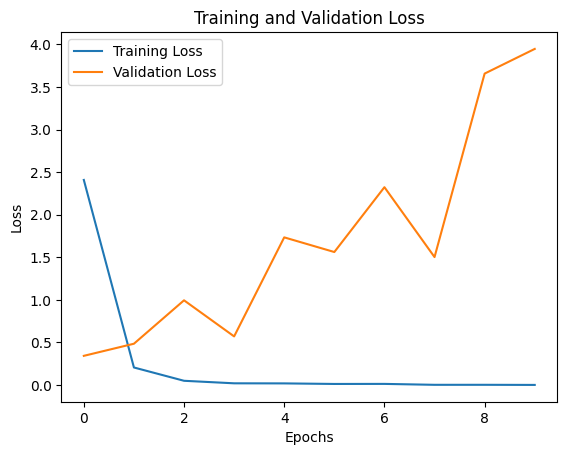

In [64]:

plot_loss(history)

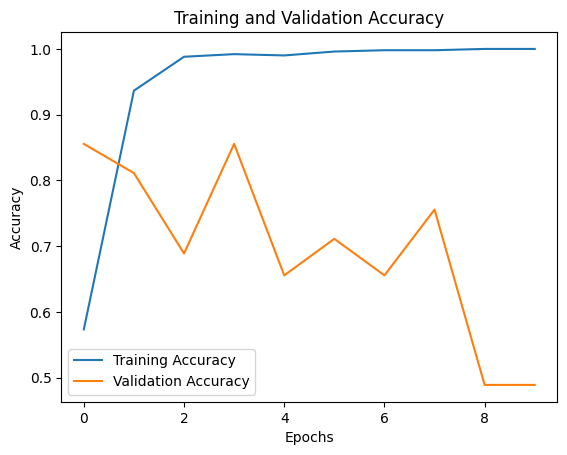

In [66]:
plot_accuracy(history)


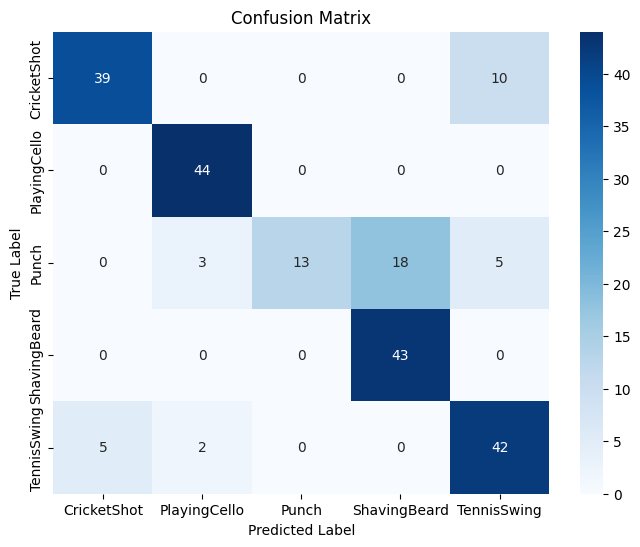

In [123]:
plot_confusion_matrix(y_true_all, y_pred_all, classes=class_vocab)

In [78]:
!pip install pydot graphviz

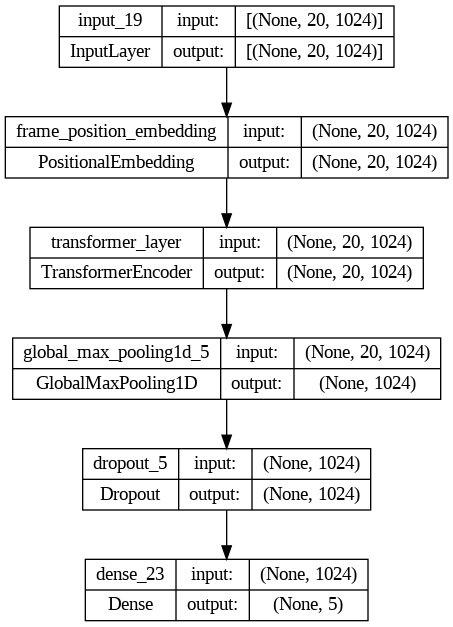

In [80]:
from tensorflow.keras.utils import plot_model

# Visualize the architecture of the trained model
plot_model(trained_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


The performance of our model is far from optimal, because it was trained on a
small dataset.